In [ ]:
import time
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

from itertools import chain

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
d1 = pd.read_csv("/content/drive/My Drive/Colab Notebooks/causes4_1.csv", on_bad_lines = 'skip').reset_index()
d2 = pd.read_csv("/content/drive/My Drive/Colab Notebooks/causes4_2.csv", on_bad_lines = 'skip').reset_index()
d3 = pd.read_csv("/content/drive/My Drive/Colab Notebooks/causes3.csv", on_bad_lines = 'skip')
d3 = d3.drop(["level_0", "Unnamed: 0.1", "Unnamed: 0.3", "index", "Unnamed: 0", "Report2.1", "Report1.1"], axis=1)
d4 = pd.read_csv("/content/drive/My Drive/Colab Notebooks/causes2.csv", on_bad_lines = 'skip').reset_index()
d5 = pd.read_csv("/content/drive/My Drive/Colab Notebooks/causes1.csv", on_bad_lines = 'skip').reset_index()

In [ ]:
result = pd.concat([d1, d2, d3, d4, d5])
result = result.drop(["level_0", "Unnamed: 0.1", "index", "Unnamed: 0"], axis=1)

In [ ]:
!pip install keybert

In [ ]:
!pip install keybert[flair]
!pip install keybert[gensim]
!pip install keybert[spacy]
!pip install keybert[use]

In [ ]:
causes = result["CAUSES"]
kw = list()
kwm = KeyBERT()
for i in causes:
  temp = i
  for j in ["patient", "cause", "readmission", "patients", "causes", "readmissions", "complications", "complication", "information", "provided"]:
    temp = temp.replace(j, "")

  kw.append(kwm.extract_keywords(temp))

In [ ]:
def KWE(k):
  return [t[0] for t in k]

In [ ]:
result["KEYWORDS"] = kw
result["KEYWORDS"] = result["KEYWORDS"].apply(KWE)
result.to_csv("/content/drive/My Drive/Colab Notebooks/data_with_keywords.csv", encoding='utf-8')

In [ ]:
df = pd.read_csv("/content/drive/My Drive/data_with_keywords.csv", encoding='utf-8')

In [ ]:

import re

all_words = []
df['KEYWORDS'].apply(lambda x: all_words.extend(re.findall(r'\b\w+\b', x.lower())))


0      None
1      None
2      None
3      None
4      None
       ... 
420    None
421    None
422    None
423    None
424    None
Name: KEYWORDS, Length: 425, dtype: object

In [ ]:
len(all_words)

2039

In [ ]:
import requests
import csv
def results_list(string):

    api_key = "6849c13d-2343-4f08-930c-a9be39c8467e"
    version = "current"
    uri = "https://uts-ws.nlm.nih.gov"
    content_endpoint = "/rest/search/"+version
    full_url = uri+content_endpoint

    output_file = "output.tsv"
    with open(output_file, 'a', newline='') as csvfile:
                    fieldnames = ['INPUT', 'UI', 'Name', 'Source Vocabulary']
                    writer = csv.DictWriter(csvfile, fieldnames=fieldnames, delimiter='\t')

                    writer.writerow({
                            'INPUT': "INPUT",
                            'UI': "CUI",
                            'Name': "NAME",
                            'Source Vocabulary': "SOURCE VOCAB"
                        })

    for st in string:
        page = 0
        try:
            while True:
                page += 1
                query = {'string':st,'apiKey':api_key, 'pageNumber':page}
                query['sabs'] = "MTH"
                query['searchType'] = "exact"
                r = requests.get(full_url,params=query)
                r.raise_for_status()
                #print(r.url)
                r.encoding = 'utf-8'
                outputs  = r.json()

                items = (([outputs['result']])[0])['results']

                if len(items) == 0:
                    if page == 1:
                        print('No results found.'+'\n')
                        break
                    else:
                        break

                print("Results for page " + str(page)+"\n")

                output_file = "output.tsv"
                with open(output_file, 'a', newline='') as csvfile:
                    fieldnames = ['INPUT', 'UI', 'Name', 'Source Vocabulary']
                    writer = csv.DictWriter(csvfile, fieldnames=fieldnames, delimiter='\t')

                    # Write the data for each item to append
                    for result in items:
                        writer.writerow({
                            'INPUT': st,
                            'UI': result['ui'],
                            'Name': result['name'],
                            'Source Vocabulary': result['rootSource']
                        })

            print('*********')

        except Exception as except_error:
            print(except_error)




In [ ]:
results_list(all_words)

Streaming output truncated to the last 5000 lines.
*********
Results for page 1

*********
Results for page 1

*********
No results found.

*********
Results for page 1

*********
Results for page 1

*********
Results for page 1

*********
No results found.

*********
Results for page 1

*********
Results for page 1

*********
No results found.

*********
Results for page 1

*********
Results for page 1

*********
No results found.

*********
No results found.

*********
Results for page 1

*********
No results found.

*********
Results for page 1

*********
No results found.

*********
Results for page 1

*********
Results for page 1

*********
No results found.

*********
Results for page 1

*********
Results for page 1

*********
Results for page 1

*********
No results found.

*********
No results found.

*********
No results found.

*********
No results found.

*********
Results for page 1

*********
Results for page 1

*********
No results found.

*********
Results for page 1

**

In [ ]:
unique = []
with open('output.tsv', 'r', newline='', encoding='utf-8') as tsv_file:
    # Create a CSV reader for TSV files
    reader = csv.DictReader(tsv_file, delimiter='\t')

    # Iterate over rows and extract values from the specified column
    for row in reader:
      unique.append(row['CUI'])

In [ ]:
len(unique)

1033

In [ ]:
disease_list = []
from tqdm import tqdm
with open('UMLSConcepts.txt', 'w') as f:
  for cui in tqdm(unique):
    try:
      base_uri = "https://uts-ws.nlm.nih.gov"
      path = "/rest/content/" + "current" + "/CUI/" + cui
      query = {'apiKey':  "6849c13d-2343-4f08-930c-a9be39c8467e"}
      output = requests.get(base_uri + path, params=query)
      output.encoding = 'utf-8'
      outputJson = output.json()
      if (outputJson['result']['semanticTypes'][0]['name'] == 'Disease or Syndrome') or (outputJson['result']['semanticTypes'][0]['name'] == 'Sign or Symptom'):
        f.write(outputJson['result']['name'] + '\n')
        disease_list.append(outputJson['result']['name'])
    except:
      continue

  0%|          | 1/1033 [00:00<14:35,  1.18it/s]

{'ui': 'C0021270', 'name': 'Infant', 'majorRevisionDate': '07-19-2018', 'dateAdded': '09-30-1990', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Age Group', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T100'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021270/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021270/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021270/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021270/atoms/preferred', 'atomCount': 95, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 14}


  0%|          | 2/1033 [00:01<14:30,  1.18it/s]

{'ui': 'C0018787', 'name': 'Heart', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-28-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018787/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018787/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018787/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018787/atoms/preferred', 'atomCount': 83, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 318}


  0%|          | 3/1033 [00:02<14:35,  1.18it/s]

{'ui': 'C0013604', 'name': 'Edema', 'dateAdded': '09-30-1990', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013604/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013604/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013604/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013604/atoms/preferred', 'atomCount': 370, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 112}


  0%|          | 4/1033 [00:03<14:31,  1.18it/s]

{'ui': 'C4018909', 'name': 'Overdose', 'dateAdded': '11-09-2015', 'majorRevisionDate': '09-07-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Finding', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T033'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C4018909/atoms', 'definitions': 'NONE', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C4018909/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C4018909/atoms/preferred', 'atomCount': 9, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 2}


  0%|          | 5/1033 [00:04<14:25,  1.19it/s]

{'ui': 'C0348026', 'name': 'Diagnostic', 'dateAdded': '01-01-1997', 'majorRevisionDate': '08-18-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Functional Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T169'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0348026/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0348026/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0348026/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0348026/atoms/preferred', 'atomCount': 14, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 13}


  1%|          | 6/1033 [00:05<14:23,  1.19it/s]

{'ui': 'C0220825', 'name': 'Evaluation', 'majorRevisionDate': '09-13-2023', 'dateAdded': '04-17-1995', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Health Care Activity', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T058'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0220825/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0220825/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0220825/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0220825/atoms/preferred', 'atomCount': 22, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 41}


  1%|          | 7/1033 [00:05<14:26,  1.18it/s]

{'ui': 'C0237154', 'name': 'Homelessness', 'dateAdded': '04-17-1995', 'majorRevisionDate': '09-15-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Finding', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T033'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0237154/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0237154/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0237154/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0237154/atoms/preferred', 'atomCount': 119, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 14}


  1%|          | 8/1033 [00:06<14:27,  1.18it/s]

{'ui': 'C0036572', 'name': 'Seizures', 'dateAdded': '09-30-1990', 'majorRevisionDate': '08-28-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0036572/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0036572/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0036572/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0036572/atoms/preferred', 'atomCount': 410, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 73}


  1%|          | 9/1033 [00:07<14:22,  1.19it/s]

{'ui': 'C1546935', 'name': 'Abuse', 'majorRevisionDate': '05-14-2021', 'dateAdded': '11-21-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Event', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T051'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1546935/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1546935/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1546935/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1546935/atoms/preferred', 'atomCount': 47, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 2}


  1%|          | 10/1033 [00:08<14:23,  1.18it/s]

{'ui': 'C1444749', 'name': 'Exacerbated', 'majorRevisionDate': '07-27-2017', 'dateAdded': '11-15-2004', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Qualitative Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T080'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1444749/atoms', 'definitions': 'NONE', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1444749/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1444749/atoms/preferred', 'atomCount': 6, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


  1%|          | 11/1033 [00:09<14:22,  1.19it/s]

{'ui': 'C0348080', 'name': 'Condition', 'majorRevisionDate': '04-29-2021', 'dateAdded': '01-01-1997', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Qualitative Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T080'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0348080/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0348080/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0348080/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0348080/atoms/preferred', 'atomCount': 11, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 3}


  1%|          | 12/1033 [00:10<14:18,  1.19it/s]

{'ui': 'C0027497', 'name': 'Nausea', 'dateAdded': '09-30-1990', 'majorRevisionDate': '08-12-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0027497/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0027497/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0027497/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0027497/atoms/preferred', 'atomCount': 322, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 29}


  1%|▏         | 13/1033 [00:10<14:17,  1.19it/s]

{'ui': 'C0018681', 'name': 'Headache', 'dateAdded': '09-30-1990', 'majorRevisionDate': '03-09-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018681/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018681/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018681/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018681/atoms/preferred', 'atomCount': 416, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 61}


  1%|▏         | 14/1033 [00:11<14:20,  1.18it/s]

{'ui': 'C0042963', 'name': 'Vomiting', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-18-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0042963/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0042963/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0042963/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0042963/atoms/preferred', 'atomCount': 337, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 35}


  1%|▏         | 15/1033 [00:12<14:17,  1.19it/s]

{'ui': 'C0016976', 'name': 'Gallbladder', 'dateAdded': '09-30-1990', 'majorRevisionDate': '03-04-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016976/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016976/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016976/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016976/atoms/preferred', 'atomCount': 69, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 40}


  2%|▏         | 16/1033 [00:13<14:16,  1.19it/s]

{'ui': 'C0023884', 'name': 'Liver', 'dateAdded': '09-30-1990', 'majorRevisionDate': '07-23-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023884/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023884/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023884/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023884/atoms/preferred', 'atomCount': 74, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 92}


  2%|▏         | 17/1033 [00:14<14:12,  1.19it/s]

{'ui': 'C0040578', 'name': 'Trachea', 'majorRevisionDate': '09-20-2021', 'dateAdded': '09-30-1990', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0040578/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0040578/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0040578/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0040578/atoms/preferred', 'atomCount': 67, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 53}


  2%|▏         | 19/1033 [00:15<12:00,  1.41it/s]

{'ui': 'C0040053', 'name': 'Thrombosis', 'majorRevisionDate': '11-01-2021', 'dateAdded': '09-30-1990', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0040053/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0040053/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0040053/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0040053/atoms/preferred', 'atomCount': 128, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 47}


  2%|▏         | 20/1033 [00:16<12:34,  1.34it/s]

{'ui': 'C1522564', 'name': 'Myocardial', 'dateAdded': '07-18-2005', 'majorRevisionDate': '02-16-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522564/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522564/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522564/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522564/atoms/preferred', 'atomCount': 2, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


  2%|▏         | 21/1033 [00:17<13:03,  1.29it/s]

{'ui': 'C0021308', 'name': 'Infarction', 'dateAdded': '09-30-1990', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021308/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021308/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021308/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021308/atoms/preferred', 'atomCount': 145, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 19}


  2%|▏         | 22/1033 [00:17<13:22,  1.26it/s]

{'ui': 'C0015967', 'name': 'Fever', 'dateAdded': '09-30-1990', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015967/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015967/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015967/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015967/atoms/preferred', 'atomCount': 474, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 34}


  2%|▏         | 23/1033 [00:18<13:34,  1.24it/s]

{'ui': 'C1524072', 'name': 'Placement', 'majorRevisionDate': '04-28-2021', 'dateAdded': '07-18-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Qualitative Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T080'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1524072/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1524072/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1524072/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1524072/atoms/preferred', 'atomCount': 2, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


  2%|▏         | 25/1033 [00:19<10:33,  1.59it/s]

{'ui': 'C1522318', 'name': 'Coronary', 'dateAdded': '07-18-2005', 'majorRevisionDate': '02-08-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522318/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522318/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522318/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522318/atoms/preferred', 'atomCount': 2, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


  3%|▎         | 26/1033 [00:20<11:24,  1.47it/s]

{'ui': 'C1444749', 'name': 'Exacerbated', 'majorRevisionDate': '07-27-2017', 'dateAdded': '11-15-2004', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Qualitative Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T080'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1444749/atoms', 'definitions': 'NONE', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1444749/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1444749/atoms/preferred', 'atomCount': 6, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


  3%|▎         | 27/1033 [00:21<12:06,  1.38it/s]

{'ui': 'C1442162', 'name': 'GIVEN', 'majorRevisionDate': '07-18-2018', 'dateAdded': '11-15-2004', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Functional Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T169'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1442162/atoms', 'definitions': 'NONE', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1442162/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1442162/atoms/preferred', 'atomCount': 4, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


  3%|▎         | 28/1033 [00:22<12:36,  1.33it/s]

{'ui': 'C0521346', 'name': 'respiratory', 'dateAdded': '01-01-1998', 'majorRevisionDate': '08-17-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Functional Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T169'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521346/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521346/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521346/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521346/atoms/preferred', 'atomCount': 9, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 7}


  3%|▎         | 30/1033 [00:23<09:46,  1.71it/s]

{'ui': 'C1522318', 'name': 'Coronary', 'dateAdded': '07-18-2005', 'majorRevisionDate': '02-08-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522318/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522318/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522318/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522318/atoms/preferred', 'atomCount': 2, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


  3%|▎         | 31/1033 [00:23<10:56,  1.53it/s]

{'ui': 'C0012634', 'name': 'Disease', 'majorRevisionDate': '01-25-2023', 'dateAdded': '09-30-1990', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0012634/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0012634/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0012634/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0012634/atoms/preferred', 'atomCount': 91, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 225}


  3%|▎         | 32/1033 [00:24<11:45,  1.42it/s]

{'ui': 'C1522565', 'name': 'Ventricular', 'dateAdded': '07-18-2005', 'majorRevisionDate': '02-16-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522565/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522565/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522565/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522565/atoms/preferred', 'atomCount': 2, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


  3%|▎         | 33/1033 [00:25<12:24,  1.34it/s]

{'ui': 'C0018787', 'name': 'Heart', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-28-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018787/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018787/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018787/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018787/atoms/preferred', 'atomCount': 83, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 318}


  3%|▎         | 34/1033 [00:26<12:49,  1.30it/s]

{'ui': 'C0237477', 'name': 'Arrested progression', 'dateAdded': '04-17-1995', 'majorRevisionDate': '12-17-2010', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Temporal Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T079'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0237477/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0237477/definitions', 'relations': 'NONE', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0237477/atoms/preferred', 'atomCount': 13, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 0}


  3%|▎         | 35/1033 [00:27<13:08,  1.27it/s]

{'ui': 'C0002940', 'name': 'Aneurysm', 'dateAdded': '09-30-1990', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0002940/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0002940/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0002940/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0002940/atoms/preferred', 'atomCount': 169, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 72}


  3%|▎         | 36/1033 [00:28<13:22,  1.24it/s]

{'ui': 'C0205385', 'name': 'Ascending', 'dateAdded': '04-12-1994', 'majorRevisionDate': '01-04-2011', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Qualitative Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T080'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205385/atoms', 'definitions': 'NONE', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205385/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205385/atoms/preferred', 'atomCount': 8, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


  4%|▎         | 37/1033 [00:28<13:29,  1.23it/s]

{'ui': 'C0038454', 'name': 'Cerebrovascular accident', 'dateAdded': '09-30-1990', 'majorRevisionDate': '09-15-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0038454/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0038454/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0038454/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0038454/atoms/preferred', 'atomCount': 456, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 34}


  4%|▎         | 38/1033 [00:29<13:37,  1.22it/s]

{'ui': 'C0037817', 'name': 'Speech', 'dateAdded': '09-30-1990', 'majorRevisionDate': '09-13-2017', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Organism Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T040'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0037817/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0037817/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0037817/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0037817/atoms/preferred', 'atomCount': 48, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 22}


  4%|▍         | 39/1033 [00:30<13:42,  1.21it/s]

{'ui': 'C5202986', 'name': 'Facial', 'dateAdded': '05-04-2020', 'majorRevisionDate': '04-28-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C5202986/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C5202986/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C5202986/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C5202986/atoms/preferred', 'atomCount': 2, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


  4%|▍         | 40/1033 [00:31<13:45,  1.20it/s]

{'ui': 'C1457887', 'name': 'Symptoms', 'dateAdded': '01-18-2005', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1457887/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1457887/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1457887/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1457887/atoms/preferred', 'atomCount': 52, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 100}


  4%|▍         | 41/1033 [00:32<13:45,  1.20it/s]

{'ui': 'C0023884', 'name': 'Liver', 'dateAdded': '09-30-1990', 'majorRevisionDate': '07-23-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023884/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023884/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023884/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023884/atoms/preferred', 'atomCount': 74, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 92}


  4%|▍         | 42/1033 [00:33<13:47,  1.20it/s]

{'ui': 'C3841811', 'name': 'Transplant', 'dateAdded': '11-01-2014', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Finding', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T033'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3841811/atoms', 'definitions': 'NONE', 'relations': 'NONE', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3841811/atoms/preferred', 'atomCount': 2, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 0}


  4%|▍         | 43/1033 [00:33<13:47,  1.20it/s]

{'ui': 'C0012634', 'name': 'Disease', 'majorRevisionDate': '01-25-2023', 'dateAdded': '09-30-1990', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0012634/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0012634/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0012634/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0012634/atoms/preferred', 'atomCount': 91, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 225}


  4%|▍         | 44/1033 [00:34<13:44,  1.20it/s]

{'ui': 'C0011847', 'name': 'Diabetes', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0011847/atoms', 'definitions': 'NONE', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0011847/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0011847/atoms/preferred', 'atomCount': 9, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 17}


  4%|▍         | 45/1033 [00:35<13:43,  1.20it/s]

{'ui': 'C0011847', 'name': 'Diabetes', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0011847/atoms', 'definitions': 'NONE', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0011847/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0011847/atoms/preferred', 'atomCount': 9, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 17}


  4%|▍         | 46/1033 [00:36<13:46,  1.19it/s]

{'ui': 'C0032617', 'name': 'Polyuria', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-18-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032617/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032617/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032617/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032617/atoms/preferred', 'atomCount': 192, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 10}


  5%|▍         | 47/1033 [00:37<13:44,  1.20it/s]

{'ui': 'C0021641', 'name': 'Insulin', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-28-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Amino Acid, Peptide, or Protein', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T116'}, {'name': 'Pharmacologic Substance', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T121'}, {'name': 'Hormone', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T125'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021641/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021641/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021641/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021641/atoms/preferred', 'atomCount': 127, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 92}


  5%|▍         | 48/1033 [00:38<13:42,  1.20it/s]

{'ui': 'C1457887', 'name': 'Symptoms', 'dateAdded': '01-18-2005', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1457887/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1457887/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1457887/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1457887/atoms/preferred', 'atomCount': 52, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 100}


  5%|▍         | 49/1033 [00:38<13:42,  1.20it/s]

{'ui': 'C0032285', 'name': 'Pneumonia', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-20-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/atoms/preferred', 'atomCount': 230, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 55}


  5%|▍         | 50/1033 [00:39<13:42,  1.20it/s]

{'ui': 'C0019682', 'name': 'HIV', 'dateAdded': '09-30-1990', 'majorRevisionDate': '03-10-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Virus', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T005'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019682/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019682/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019682/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019682/atoms/preferred', 'atomCount': 194, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 26}


  5%|▍         | 51/1033 [00:40<13:42,  1.19it/s]

{'ui': 'C1522564', 'name': 'Myocardial', 'dateAdded': '07-18-2005', 'majorRevisionDate': '02-16-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522564/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522564/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522564/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522564/atoms/preferred', 'atomCount': 2, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


  5%|▌         | 52/1033 [00:41<13:41,  1.19it/s]

{'ui': 'C0128513', 'name': 'milrinone', 'dateAdded': '08-30-1992', 'majorRevisionDate': '05-13-2020', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Organic Chemical', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T109'}, {'name': 'Pharmacologic Substance', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T121'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0128513/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0128513/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0128513/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0128513/atoms/preferred', 'atomCount': 57, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 6}


  5%|▌         | 53/1033 [00:42<13:39,  1.20it/s]

{'ui': 'C0817096', 'name': 'Chest', 'majorRevisionDate': '06-07-2023', 'dateAdded': '05-01-2000', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Location or Region', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T029'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0817096/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0817096/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0817096/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0817096/atoms/preferred', 'atomCount': 103, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 242}


  5%|▌         | 54/1033 [00:43<13:36,  1.20it/s]

{'ui': 'C1522564', 'name': 'Myocardial', 'dateAdded': '07-18-2005', 'majorRevisionDate': '02-16-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522564/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522564/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522564/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522564/atoms/preferred', 'atomCount': 2, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


  5%|▌         | 55/1033 [00:43<13:35,  1.20it/s]

{'ui': 'C0021308', 'name': 'Infarction', 'dateAdded': '09-30-1990', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021308/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021308/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021308/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021308/atoms/preferred', 'atomCount': 145, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 19}


  5%|▌         | 56/1033 [00:44<13:34,  1.20it/s]

{'ui': 'C0205091', 'name': 'Left', 'dateAdded': '04-12-1994', 'majorRevisionDate': '03-10-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205091/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205091/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205091/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205091/atoms/preferred', 'atomCount': 29, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 6}


  6%|▌         | 57/1033 [00:45<13:35,  1.20it/s]

{'ui': 'C1522564', 'name': 'Myocardial', 'dateAdded': '07-18-2005', 'majorRevisionDate': '02-16-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522564/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522564/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522564/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522564/atoms/preferred', 'atomCount': 2, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


  6%|▌         | 58/1033 [00:46<13:36,  1.19it/s]

{'ui': 'C0018787', 'name': 'Heart', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-28-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018787/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018787/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018787/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018787/atoms/preferred', 'atomCount': 83, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 318}


  6%|▌         | 59/1033 [00:47<13:38,  1.19it/s]

{'ui': 'C0442800', 'name': 'Enlarged', 'dateAdded': '01-01-1998', 'majorRevisionDate': '07-17-2018', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Qualitative Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T080'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0442800/atoms', 'definitions': 'NONE', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0442800/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0442800/atoms/preferred', 'atomCount': 10, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 29}


  6%|▌         | 60/1033 [00:48<13:34,  1.19it/s]

{'ui': 'C0002940', 'name': 'Aneurysm', 'dateAdded': '09-30-1990', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0002940/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0002940/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0002940/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0002940/atoms/preferred', 'atomCount': 169, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 72}


  6%|▌         | 61/1033 [00:48<13:32,  1.20it/s]

{'ui': 'C1522720', 'name': 'Pleural', 'majorRevisionDate': '06-07-2023', 'dateAdded': '07-18-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522720/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522720/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522720/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522720/atoms/preferred', 'atomCount': 6, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 2}


  6%|▌         | 62/1033 [00:49<13:32,  1.19it/s]

{'ui': 'C0013687', 'name': 'effusion', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-28-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013687/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013687/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013687/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013687/atoms/preferred', 'atomCount': 62, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 27}


  6%|▌         | 63/1033 [00:50<13:30,  1.20it/s]

{'ui': 'C0024109', 'name': 'Lung', 'dateAdded': '09-30-1990', 'majorRevisionDate': '03-22-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024109/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024109/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024109/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024109/atoms/preferred', 'atomCount': 78, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 102}


  6%|▌         | 64/1033 [00:51<13:30,  1.19it/s]

{'ui': 'C0030664', 'name': 'Pathology', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-28-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Biomedical Occupation or Discipline', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T091'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030664/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030664/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030664/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030664/atoms/preferred', 'atomCount': 49, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 11}


  6%|▋         | 65/1033 [00:52<13:30,  1.19it/s]

{'ui': 'C0025222', 'name': 'Melena', 'dateAdded': '09-30-1990', 'majorRevisionDate': '08-02-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0025222/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0025222/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0025222/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0025222/atoms/preferred', 'atomCount': 204, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 19}


  6%|▋         | 66/1033 [00:53<13:28,  1.20it/s]

{'ui': 'C0018935', 'name': 'Hematocrit Measurement', 'dateAdded': '09-30-1990', 'majorRevisionDate': '02-06-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Laboratory Procedure', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T059'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018935/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018935/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018935/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018935/atoms/preferred', 'atomCount': 225, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 30}


  6%|▋         | 67/1033 [00:53<13:27,  1.20it/s]

{'ui': 'C0011847', 'name': 'Diabetes', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0011847/atoms', 'definitions': 'NONE', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0011847/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0011847/atoms/preferred', 'atomCount': 9, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 17}


  7%|▋         | 68/1033 [00:54<13:28,  1.19it/s]

{'ui': 'C0022116', 'name': 'Ischemia', 'dateAdded': '09-30-1990', 'majorRevisionDate': '10-31-2018', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022116/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022116/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022116/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022116/atoms/preferred', 'atomCount': 131, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 31}


  7%|▋         | 69/1033 [00:55<13:27,  1.19it/s]

{'ui': 'C0020649', 'name': 'Hypotension', 'dateAdded': '09-30-1990', 'majorRevisionDate': '08-05-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Finding', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T033'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020649/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020649/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020649/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020649/atoms/preferred', 'atomCount': 619, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 41}


  7%|▋         | 70/1033 [00:56<13:24,  1.20it/s]

{'ui': 'C0002871', 'name': 'Anemia', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-15-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0002871/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0002871/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0002871/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0002871/atoms/preferred', 'atomCount': 286, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 85}


  7%|▋         | 71/1033 [00:57<13:22,  1.20it/s]

{'ui': 'C0221464', 'name': 'Arterial', 'dateAdded': '04-17-1995', 'majorRevisionDate': '06-07-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0221464/atoms', 'definitions': 'NONE', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0221464/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0221464/atoms/preferred', 'atomCount': 11, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 2}


  7%|▋         | 72/1033 [00:58<13:23,  1.20it/s]

{'ui': 'C0038999', 'name': 'Swelling', 'dateAdded': '09-30-1990', 'majorRevisionDate': '08-20-2020', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Finding', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T033'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0038999/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0038999/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0038999/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0038999/atoms/preferred', 'atomCount': 154, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 110}


  7%|▋         | 73/1033 [00:58<13:24,  1.19it/s]

{'ui': 'C0030274', 'name': 'Pancreas', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-28-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030274/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030274/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030274/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030274/atoms/preferred', 'atomCount': 74, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 47}


  7%|▋         | 74/1033 [00:59<13:24,  1.19it/s]

{'ui': 'C3714514', 'name': 'Infection', 'dateAdded': '11-01-2014', 'majorRevisionDate': '09-13-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714514/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714514/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714514/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714514/atoms/preferred', 'atomCount': 150, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 6}


  7%|▋         | 75/1033 [01:00<13:30,  1.18it/s]

{'ui': 'C0015967', 'name': 'Fever', 'dateAdded': '09-30-1990', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015967/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015967/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015967/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015967/atoms/preferred', 'atomCount': 474, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 34}


  7%|▋         | 76/1033 [01:01<13:26,  1.19it/s]

{'ui': 'C1261287', 'name': 'Stenosis', 'dateAdded': '04-15-2004', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1261287/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1261287/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1261287/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1261287/atoms/preferred', 'atomCount': 153, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 75}


  7%|▋         | 77/1033 [01:02<13:24,  1.19it/s]

{'ui': 'C2348535', 'name': 'Stenting', 'dateAdded': '11-03-2008', 'majorRevisionDate': '12-07-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Therapeutic or Preventive Procedure', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T061'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C2348535/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C2348535/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C2348535/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C2348535/atoms/preferred', 'atomCount': 84, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 2}


  8%|▊         | 78/1033 [01:03<13:22,  1.19it/s]

{'ui': 'C0003842', 'name': 'Arteries', 'dateAdded': '09-30-1990', 'majorRevisionDate': '07-19-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0003842/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0003842/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0003842/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0003842/atoms/preferred', 'atomCount': 87, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 97}


  8%|▊         | 79/1033 [01:04<13:24,  1.19it/s]

{'ui': 'C0030193', 'name': 'Pain', 'dateAdded': '09-30-1990', 'majorRevisionDate': '08-10-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030193/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030193/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030193/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030193/atoms/preferred', 'atomCount': 195, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 138}


  8%|▊         | 80/1033 [01:04<13:26,  1.18it/s]

{'ui': 'C0817096', 'name': 'Chest', 'majorRevisionDate': '06-07-2023', 'dateAdded': '05-01-2000', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Location or Region', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T029'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0817096/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0817096/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0817096/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0817096/atoms/preferred', 'atomCount': 103, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 242}


  8%|▊         | 81/1033 [01:05<13:24,  1.18it/s]

{'ui': 'C0027950', 'name': 'neutrophil', 'dateAdded': '09-30-1990', 'majorRevisionDate': '09-13-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Cell', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T025'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0027950/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0027950/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0027950/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0027950/atoms/preferred', 'atomCount': 180, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 28}


  8%|▊         | 82/1033 [01:06<13:18,  1.19it/s]

{'ui': 'C0206698', 'name': 'Cholangiocarcinoma', 'dateAdded': '04-12-1994', 'majorRevisionDate': '09-06-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Neoplastic Process', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T191'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0206698/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0206698/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0206698/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0206698/atoms/preferred', 'atomCount': 167, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 14}


  8%|▊         | 83/1033 [01:07<13:15,  1.19it/s]

{'ui': 'C0205039', 'name': 'Bronchial', 'majorRevisionDate': '06-07-2023', 'dateAdded': '04-12-1994', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205039/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205039/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205039/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205039/atoms/preferred', 'atomCount': 12, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 8}


  8%|▊         | 84/1033 [01:08<13:20,  1.18it/s]

{'ui': 'C0027651', 'name': 'Neoplasms', 'majorRevisionDate': '01-25-2023', 'dateAdded': '09-30-1990', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Neoplastic Process', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T191'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0027651/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0027651/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0027651/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0027651/atoms/preferred', 'atomCount': 386, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 288}


  8%|▊         | 85/1033 [01:09<13:21,  1.18it/s]

{'ui': 'C0015967', 'name': 'Fever', 'dateAdded': '09-30-1990', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015967/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015967/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015967/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015967/atoms/preferred', 'atomCount': 474, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 34}


  8%|▊         | 86/1033 [01:09<13:16,  1.19it/s]

{'ui': 'C1457887', 'name': 'Symptoms', 'dateAdded': '01-18-2005', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1457887/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1457887/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1457887/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1457887/atoms/preferred', 'atomCount': 52, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 100}


  8%|▊         | 87/1033 [01:10<13:17,  1.19it/s]

{'ui': 'C0013687', 'name': 'effusion', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-28-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013687/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013687/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013687/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013687/atoms/preferred', 'atomCount': 62, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 27}


  9%|▊         | 88/1033 [01:11<13:18,  1.18it/s]

{'ui': 'C0032284', 'name': 'Pneumonectomy', 'dateAdded': '09-30-1990', 'majorRevisionDate': '09-13-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Therapeutic or Preventive Procedure', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T061'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032284/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032284/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032284/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032284/atoms/preferred', 'atomCount': 114, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 17}


  9%|▊         | 89/1033 [01:12<13:14,  1.19it/s]

{'ui': 'C0024109', 'name': 'Lung', 'dateAdded': '09-30-1990', 'majorRevisionDate': '03-22-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024109/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024109/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024109/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024109/atoms/preferred', 'atomCount': 78, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 102}


  9%|▊         | 90/1033 [01:13<13:13,  1.19it/s]

{'ui': 'C0449584', 'name': 'Opacification', 'dateAdded': '01-01-1998', 'majorRevisionDate': '06-23-2015', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Qualitative Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T080'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0449584/atoms', 'definitions': 'NONE', 'relations': 'NONE', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0449584/atoms/preferred', 'atomCount': 8, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 0}


  9%|▉         | 91/1033 [01:14<13:11,  1.19it/s]

{'ui': 'C0043210', 'name': 'Woman', 'dateAdded': '09-30-1990', 'majorRevisionDate': '05-14-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Population Group', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T098'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0043210/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0043210/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0043210/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0043210/atoms/preferred', 'atomCount': 64, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 10}


  9%|▉         | 92/1033 [01:15<13:13,  1.19it/s]

{'ui': 'C0025222', 'name': 'Melena', 'dateAdded': '09-30-1990', 'majorRevisionDate': '08-02-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0025222/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0025222/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0025222/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0025222/atoms/preferred', 'atomCount': 204, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 19}


  9%|▉         | 93/1033 [01:15<13:09,  1.19it/s]

{'ui': 'C1522318', 'name': 'Coronary', 'dateAdded': '07-18-2005', 'majorRevisionDate': '02-08-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522318/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522318/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522318/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522318/atoms/preferred', 'atomCount': 2, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


  9%|▉         | 94/1033 [01:16<13:06,  1.19it/s]

{'ui': 'C0012634', 'name': 'Disease', 'majorRevisionDate': '01-25-2023', 'dateAdded': '09-30-1990', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0012634/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0012634/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0012634/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0012634/atoms/preferred', 'atomCount': 91, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 225}


  9%|▉         | 95/1033 [01:17<13:04,  1.20it/s]

{'ui': 'C0018787', 'name': 'Heart', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-28-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018787/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018787/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018787/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018787/atoms/preferred', 'atomCount': 83, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 318}


  9%|▉         | 96/1033 [01:18<13:02,  1.20it/s]

{'ui': 'C0030193', 'name': 'Pain', 'dateAdded': '09-30-1990', 'majorRevisionDate': '08-10-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030193/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030193/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030193/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030193/atoms/preferred', 'atomCount': 195, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 138}


  9%|▉         | 97/1033 [01:19<12:59,  1.20it/s]

{'ui': 'C0021308', 'name': 'Infarction', 'dateAdded': '09-30-1990', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021308/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021308/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021308/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021308/atoms/preferred', 'atomCount': 145, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 19}


  9%|▉         | 98/1033 [01:20<12:57,  1.20it/s]

{'ui': 'C1522564', 'name': 'Myocardial', 'dateAdded': '07-18-2005', 'majorRevisionDate': '02-16-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522564/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522564/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522564/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522564/atoms/preferred', 'atomCount': 2, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 10%|▉         | 99/1033 [01:20<12:56,  1.20it/s]

{'ui': 'C0702240', 'name': 'Elevation', 'dateAdded': '01-01-2000', 'majorRevisionDate': '01-19-2011', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0702240/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0702240/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0702240/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0702240/atoms/preferred', 'atomCount': 13, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 10%|▉         | 100/1033 [01:21<12:57,  1.20it/s]

{'ui': 'C0032285', 'name': 'Pneumonia', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-20-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/atoms/preferred', 'atomCount': 230, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 55}


 10%|▉         | 101/1033 [01:22<12:56,  1.20it/s]

{'ui': 'C0004610', 'name': 'Bacteremia', 'dateAdded': '09-30-1990', 'majorRevisionDate': '08-22-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Finding', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T033'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0004610/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0004610/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0004610/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0004610/atoms/preferred', 'atomCount': 227, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 12}


 10%|▉         | 102/1033 [01:23<12:55,  1.20it/s]

{'ui': 'C0013687', 'name': 'effusion', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-28-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013687/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013687/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013687/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013687/atoms/preferred', 'atomCount': 62, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 27}


 10%|▉         | 103/1033 [01:24<12:57,  1.20it/s]

{'ui': 'C0020538', 'name': 'Hypertensive disease', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-17-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020538/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020538/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020538/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020538/atoms/preferred', 'atomCount': 446, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 94}


 10%|█         | 104/1033 [01:25<12:56,  1.20it/s]

{'ui': 'C0036341', 'name': 'Schizophrenia', 'dateAdded': '09-30-1990', 'majorRevisionDate': '07-23-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Mental or Behavioral Dysfunction', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T048'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0036341/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0036341/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0036341/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0036341/atoms/preferred', 'atomCount': 302, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 38}


 10%|█         | 105/1033 [01:25<12:55,  1.20it/s]

{'ui': 'C1522564', 'name': 'Myocardial', 'dateAdded': '07-18-2005', 'majorRevisionDate': '02-16-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522564/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522564/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522564/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522564/atoms/preferred', 'atomCount': 2, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 10%|█         | 106/1033 [01:26<12:54,  1.20it/s]

{'ui': 'C0012634', 'name': 'Disease', 'majorRevisionDate': '01-25-2023', 'dateAdded': '09-30-1990', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0012634/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0012634/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0012634/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0012634/atoms/preferred', 'atomCount': 91, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 225}


 10%|█         | 107/1033 [01:27<12:55,  1.19it/s]

{'ui': 'C0040046', 'name': 'Thrombophlebitis', 'dateAdded': '09-30-1990', 'majorRevisionDate': '08-29-2018', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0040046/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0040046/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0040046/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0040046/atoms/preferred', 'atomCount': 144, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 55}


 10%|█         | 108/1033 [01:28<13:03,  1.18it/s]

{'ui': 'C1801960', 'name': 'Vascular', 'majorRevisionDate': '04-29-2021', 'dateAdded': '06-20-2007', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Qualitative Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T080'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1801960/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1801960/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1801960/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1801960/atoms/preferred', 'atomCount': 5, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 4}


 11%|█         | 109/1033 [01:29<16:21,  1.06s/it]

{'ui': 'C0221198', 'name': 'Lesion', 'dateAdded': '04-17-1995', 'majorRevisionDate': '03-09-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Finding', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T033'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0221198/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0221198/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0221198/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0221198/atoms/preferred', 'atomCount': 22, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 67}


 11%|█         | 110/1033 [01:31<16:30,  1.07s/it]

{'ui': 'C0019080', 'name': 'Hemorrhage', 'dateAdded': '09-30-1990', 'majorRevisionDate': '07-06-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019080/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019080/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019080/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019080/atoms/preferred', 'atomCount': 436, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 284}


 11%|█         | 111/1033 [01:32<16:01,  1.04s/it]

{'ui': 'C0032285', 'name': 'Pneumonia', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-20-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/atoms/preferred', 'atomCount': 230, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 55}


 11%|█         | 112/1033 [01:32<15:03,  1.02it/s]

{'ui': 'C0001418', 'name': 'Adenocarcinoma', 'dateAdded': '09-30-1990', 'majorRevisionDate': '05-24-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Neoplastic Process', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T191'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0001418/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0001418/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0001418/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0001418/atoms/preferred', 'atomCount': 181, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 59}


 11%|█         | 113/1033 [01:33<14:20,  1.07it/s]

{'ui': 'C0024109', 'name': 'Lung', 'dateAdded': '09-30-1990', 'majorRevisionDate': '03-22-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024109/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024109/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024109/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024109/atoms/preferred', 'atomCount': 78, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 102}


 11%|█         | 114/1033 [01:34<13:50,  1.11it/s]

{'ui': 'C0205091', 'name': 'Left', 'dateAdded': '04-12-1994', 'majorRevisionDate': '03-10-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205091/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205091/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205091/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205091/atoms/preferred', 'atomCount': 29, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 6}


 11%|█         | 115/1033 [01:35<13:29,  1.13it/s]

{'ui': 'C0006104', 'name': 'Brain', 'dateAdded': '09-30-1990', 'majorRevisionDate': '07-09-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0006104/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0006104/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0006104/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0006104/atoms/preferred', 'atomCount': 72, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 82}


 11%|█         | 116/1033 [01:36<13:16,  1.15it/s]

{'ui': 'C0019080', 'name': 'Hemorrhage', 'dateAdded': '09-30-1990', 'majorRevisionDate': '07-06-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019080/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019080/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019080/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019080/atoms/preferred', 'atomCount': 436, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 284}


 11%|█▏        | 117/1033 [01:37<13:09,  1.16it/s]

{'ui': 'C5700138', 'name': 'Subdural', 'dateAdded': '05-01-2023', 'majorRevisionDate': '03-08-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C5700138/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C5700138/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C5700138/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C5700138/atoms/preferred', 'atomCount': 3, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 11%|█▏        | 118/1033 [01:37<13:01,  1.17it/s]

{'ui': 'C0018944', 'name': 'Hematoma', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-18-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018944/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018944/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018944/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018944/atoms/preferred', 'atomCount': 181, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 41}


 12%|█▏        | 119/1033 [01:38<12:55,  1.18it/s]

{'ui': 'C0013604', 'name': 'Edema', 'dateAdded': '09-30-1990', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013604/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013604/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013604/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013604/atoms/preferred', 'atomCount': 370, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 112}


 12%|█▏        | 120/1033 [01:39<12:55,  1.18it/s]

{'ui': 'C0013404', 'name': 'Dyspnea', 'dateAdded': '09-30-1990', 'majorRevisionDate': '02-22-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013404/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013404/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013404/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013404/atoms/preferred', 'atomCount': 568, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 49}


 12%|█▏        | 121/1033 [01:40<12:52,  1.18it/s]

{'ui': 'C0817096', 'name': 'Chest', 'majorRevisionDate': '06-07-2023', 'dateAdded': '05-01-2000', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Location or Region', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T029'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0817096/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0817096/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0817096/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0817096/atoms/preferred', 'atomCount': 103, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 242}


 12%|█▏        | 122/1033 [01:41<12:54,  1.18it/s]

{'ui': 'C0015967', 'name': 'Fever', 'dateAdded': '09-30-1990', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015967/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015967/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015967/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015967/atoms/preferred', 'atomCount': 474, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 34}


 12%|█▏        | 123/1033 [01:42<12:49,  1.18it/s]

{'ui': 'C3714514', 'name': 'Infection', 'dateAdded': '11-01-2014', 'majorRevisionDate': '09-13-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714514/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714514/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714514/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714514/atoms/preferred', 'atomCount': 150, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 6}


 12%|█▏        | 124/1033 [01:42<12:50,  1.18it/s]

{'ui': 'C0348080', 'name': 'Condition', 'majorRevisionDate': '04-29-2021', 'dateAdded': '01-01-1997', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Qualitative Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T080'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0348080/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0348080/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0348080/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0348080/atoms/preferred', 'atomCount': 11, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 3}


 12%|█▏        | 125/1033 [01:43<12:45,  1.19it/s]

{'ui': 'C0489786', 'name': 'Height', 'dateAdded': '01-01-1998', 'majorRevisionDate': '11-26-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Quantitative Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T081'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0489786/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0489786/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0489786/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0489786/atoms/preferred', 'atomCount': 13, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 3}


 12%|█▏        | 126/1033 [01:44<12:41,  1.19it/s]

{'ui': 'C0750502', 'name': 'Significant', 'dateAdded': '01-01-2000', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Idea or Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T078'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0750502/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0750502/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0750502/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0750502/atoms/preferred', 'atomCount': 19, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 12%|█▏        | 127/1033 [01:45<12:39,  1.19it/s]

{'ui': 'C1522619', 'name': 'Esophageal', 'majorRevisionDate': '04-28-2021', 'dateAdded': '07-18-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522619/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522619/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522619/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522619/atoms/preferred', 'atomCount': 11, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 12%|█▏        | 128/1033 [01:46<12:36,  1.20it/s]

{'ui': 'C1623038', 'name': 'Cirrhosis', 'majorRevisionDate': '01-27-2017', 'dateAdded': '05-01-2006', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1623038/atoms', 'definitions': 'NONE', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1623038/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1623038/atoms/preferred', 'atomCount': 13, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 2}


 12%|█▏        | 129/1033 [01:47<12:33,  1.20it/s]

{'ui': 'C1522564', 'name': 'Myocardial', 'dateAdded': '07-18-2005', 'majorRevisionDate': '02-16-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522564/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522564/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522564/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522564/atoms/preferred', 'atomCount': 2, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 13%|█▎        | 130/1033 [01:47<12:35,  1.19it/s]

{'ui': 'C0021308', 'name': 'Infarction', 'dateAdded': '09-30-1990', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021308/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021308/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021308/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021308/atoms/preferred', 'atomCount': 145, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 19}


 13%|█▎        | 131/1033 [01:48<12:32,  1.20it/s]

{'ui': 'C0348026', 'name': 'Diagnostic', 'dateAdded': '01-01-1997', 'majorRevisionDate': '08-18-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Functional Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T169'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0348026/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0348026/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0348026/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0348026/atoms/preferred', 'atomCount': 14, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 13}


 13%|█▎        | 132/1033 [01:49<12:32,  1.20it/s]

{'ui': 'C0817096', 'name': 'Chest', 'majorRevisionDate': '06-07-2023', 'dateAdded': '05-01-2000', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Location or Region', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T029'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0817096/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0817096/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0817096/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0817096/atoms/preferred', 'atomCount': 103, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 242}


 13%|█▎        | 133/1033 [01:50<12:30,  1.20it/s]

{'ui': 'C2004489', 'name': 'Regurgitation', 'dateAdded': '11-03-2008', 'majorRevisionDate': '05-24-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C2004489/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C2004489/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C2004489/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C2004489/atoms/preferred', 'atomCount': 61, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 13}


 13%|█▎        | 134/1033 [01:51<12:28,  1.20it/s]

{'ui': 'C1522318', 'name': 'Coronary', 'dateAdded': '07-18-2005', 'majorRevisionDate': '02-08-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522318/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522318/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522318/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522318/atoms/preferred', 'atomCount': 2, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 13%|█▎        | 135/1033 [01:52<12:26,  1.20it/s]

{'ui': 'C0013687', 'name': 'effusion', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-28-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013687/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013687/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013687/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013687/atoms/preferred', 'atomCount': 62, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 27}


 13%|█▎        | 136/1033 [01:52<12:26,  1.20it/s]

{'ui': 'C1623038', 'name': 'Cirrhosis', 'majorRevisionDate': '01-27-2017', 'dateAdded': '05-01-2006', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1623038/atoms', 'definitions': 'NONE', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1623038/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1623038/atoms/preferred', 'atomCount': 13, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 2}


 13%|█▎        | 137/1033 [01:53<12:26,  1.20it/s]

{'ui': 'C0025222', 'name': 'Melena', 'dateAdded': '09-30-1990', 'majorRevisionDate': '08-02-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0025222/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0025222/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0025222/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0025222/atoms/preferred', 'atomCount': 204, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 19}


 13%|█▎        | 138/1033 [01:54<12:27,  1.20it/s]

{'ui': 'C0027121', 'name': 'Myositis', 'dateAdded': '09-30-1990', 'majorRevisionDate': '08-05-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0027121/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0027121/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0027121/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0027121/atoms/preferred', 'atomCount': 201, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 25}


 13%|█▎        | 139/1033 [01:55<12:27,  1.20it/s]

{'ui': 'C1457887', 'name': 'Symptoms', 'dateAdded': '01-18-2005', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1457887/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1457887/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1457887/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1457887/atoms/preferred', 'atomCount': 52, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 100}


 14%|█▎        | 140/1033 [01:56<12:29,  1.19it/s]

{'ui': 'C0036341', 'name': 'Schizophrenia', 'dateAdded': '09-30-1990', 'majorRevisionDate': '07-23-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Mental or Behavioral Dysfunction', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T048'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0036341/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0036341/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0036341/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0036341/atoms/preferred', 'atomCount': 302, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 38}


 14%|█▎        | 141/1033 [01:57<12:30,  1.19it/s]

{'ui': 'C0015967', 'name': 'Fever', 'dateAdded': '09-30-1990', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015967/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015967/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015967/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015967/atoms/preferred', 'atomCount': 474, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 34}


 14%|█▎        | 142/1033 [01:57<12:29,  1.19it/s]

{'ui': 'C0032326', 'name': 'Pneumothorax', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-21-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032326/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032326/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032326/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032326/atoms/preferred', 'atomCount': 149, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 18}


 14%|█▍        | 143/1033 [01:58<12:26,  1.19it/s]

{'ui': 'C1524119', 'name': 'urinary', 'majorRevisionDate': '04-28-2021', 'dateAdded': '07-18-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Qualitative Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T080'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1524119/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1524119/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1524119/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1524119/atoms/preferred', 'atomCount': 3, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 2}


 14%|█▍        | 144/1033 [01:59<12:25,  1.19it/s]

{'ui': 'C0022646', 'name': 'Kidney', 'dateAdded': '09-30-1990', 'majorRevisionDate': '03-09-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022646/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022646/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022646/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022646/atoms/preferred', 'atomCount': 96, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 82}


 14%|█▍        | 145/1033 [02:00<12:24,  1.19it/s]

{'ui': 'C0700106', 'name': 'Transplanted', 'dateAdded': '01-01-1999', 'majorRevisionDate': '07-23-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Functional Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T169'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0700106/atoms', 'definitions': 'NONE', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0700106/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0700106/atoms/preferred', 'atomCount': 5, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 11}


 14%|█▍        | 146/1033 [02:01<12:21,  1.20it/s]

{'ui': 'C0043210', 'name': 'Woman', 'dateAdded': '09-30-1990', 'majorRevisionDate': '05-14-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Population Group', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T098'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0043210/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0043210/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0043210/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0043210/atoms/preferred', 'atomCount': 64, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 10}


 14%|█▍        | 147/1033 [02:02<12:22,  1.19it/s]

{'ui': 'C0580836', 'name': 'Old', 'dateAdded': '01-01-1999', 'majorRevisionDate': '03-21-2019', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Temporal Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T079'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0580836/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0580836/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0580836/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0580836/atoms/preferred', 'atomCount': 10, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 2}


 14%|█▍        | 148/1033 [02:03<12:19,  1.20it/s]

{'ui': 'C0018944', 'name': 'Hematoma', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-18-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018944/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018944/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018944/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018944/atoms/preferred', 'atomCount': 181, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 41}


 14%|█▍        | 149/1033 [02:03<12:19,  1.19it/s]

{'ui': 'C5700138', 'name': 'Subdural', 'dateAdded': '05-01-2023', 'majorRevisionDate': '03-08-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C5700138/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C5700138/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C5700138/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C5700138/atoms/preferred', 'atomCount': 3, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 15%|█▍        | 150/1033 [02:04<12:19,  1.19it/s]

{'ui': 'C1801960', 'name': 'Vascular', 'majorRevisionDate': '04-29-2021', 'dateAdded': '06-20-2007', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Qualitative Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T080'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1801960/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1801960/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1801960/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1801960/atoms/preferred', 'atomCount': 5, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 4}


 15%|█▍        | 151/1033 [02:05<12:19,  1.19it/s]

{'ui': 'C0021308', 'name': 'Infarction', 'dateAdded': '09-30-1990', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021308/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021308/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021308/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021308/atoms/preferred', 'atomCount': 145, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 19}


 15%|█▍        | 152/1033 [02:06<12:19,  1.19it/s]

{'ui': 'C0000726', 'name': 'Abdomen', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Location or Region', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T029'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0000726/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0000726/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0000726/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0000726/atoms/preferred', 'atomCount': 79, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 66}


 15%|█▍        | 153/1033 [02:07<12:18,  1.19it/s]

{'ui': 'C0021270', 'name': 'Infant', 'majorRevisionDate': '07-19-2018', 'dateAdded': '09-30-1990', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Age Group', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T100'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021270/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021270/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021270/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021270/atoms/preferred', 'atomCount': 95, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 14}


 15%|█▍        | 154/1033 [02:08<12:20,  1.19it/s]

{'ui': 'C0019993', 'name': 'Hospitalization', 'dateAdded': '09-30-1990', 'majorRevisionDate': '08-05-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Health Care Activity', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T058'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019993/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019993/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019993/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019993/atoms/preferred', 'atomCount': 148, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 19}


 15%|█▌        | 155/1033 [02:08<12:21,  1.18it/s]

{'ui': 'C0032285', 'name': 'Pneumonia', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-20-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/atoms/preferred', 'atomCount': 230, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 55}


 15%|█▌        | 156/1033 [02:09<12:20,  1.18it/s]

{'ui': 'C0002940', 'name': 'Aneurysm', 'dateAdded': '09-30-1990', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0002940/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0002940/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0002940/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0002940/atoms/preferred', 'atomCount': 169, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 72}


 15%|█▌        | 157/1033 [02:10<12:21,  1.18it/s]

{'ui': 'C0015967', 'name': 'Fever', 'dateAdded': '09-30-1990', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015967/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015967/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015967/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015967/atoms/preferred', 'atomCount': 474, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 34}


 15%|█▌        | 158/1033 [02:11<12:17,  1.19it/s]

{'ui': 'C1522720', 'name': 'Pleural', 'majorRevisionDate': '06-07-2023', 'dateAdded': '07-18-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522720/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522720/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522720/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522720/atoms/preferred', 'atomCount': 6, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 2}


 15%|█▌        | 159/1033 [02:12<12:17,  1.19it/s]

{'ui': 'C1522564', 'name': 'Myocardial', 'dateAdded': '07-18-2005', 'majorRevisionDate': '02-16-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522564/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522564/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522564/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522564/atoms/preferred', 'atomCount': 2, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 15%|█▌        | 160/1033 [02:13<12:14,  1.19it/s]

{'ui': 'C0021308', 'name': 'Infarction', 'dateAdded': '09-30-1990', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021308/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021308/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021308/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021308/atoms/preferred', 'atomCount': 145, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 19}


 16%|█▌        | 161/1033 [02:13<12:11,  1.19it/s]

{'ui': 'C0026549', 'name': 'morphine', 'dateAdded': '09-30-1990', 'majorRevisionDate': '03-29-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Organic Chemical', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T109'}, {'name': 'Pharmacologic Substance', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T121'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0026549/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0026549/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0026549/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0026549/atoms/preferred', 'atomCount': 96, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 99}


 16%|█▌        | 162/1033 [02:14<12:11,  1.19it/s]

{'ui': 'C0024109', 'name': 'Lung', 'dateAdded': '09-30-1990', 'majorRevisionDate': '03-22-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024109/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024109/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024109/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024109/atoms/preferred', 'atomCount': 78, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 102}


 16%|█▌        | 163/1033 [02:15<12:12,  1.19it/s]

{'ui': 'C0013604', 'name': 'Edema', 'dateAdded': '09-30-1990', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013604/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013604/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013604/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013604/atoms/preferred', 'atomCount': 370, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 112}


 16%|█▌        | 164/1033 [02:16<12:10,  1.19it/s]

{'ui': 'C0010200', 'name': 'Coughing', 'dateAdded': '09-30-1990', 'majorRevisionDate': '03-06-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0010200/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0010200/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0010200/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0010200/atoms/preferred', 'atomCount': 216, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 29}


 16%|█▌        | 165/1033 [02:17<12:11,  1.19it/s]

{'ui': 'C1261287', 'name': 'Stenosis', 'dateAdded': '04-15-2004', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1261287/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1261287/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1261287/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1261287/atoms/preferred', 'atomCount': 153, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 75}


 16%|█▌        | 166/1033 [02:18<12:06,  1.19it/s]

{'ui': 'C3887532', 'name': 'Ulceration', 'dateAdded': '11-09-2015', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3887532/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3887532/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3887532/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3887532/atoms/preferred', 'atomCount': 33, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 3}


 16%|█▌        | 167/1033 [02:18<12:04,  1.20it/s]

{'ui': 'C0038402', 'name': 'Streptococcus', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Bacterium', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T007'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0038402/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0038402/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0038402/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0038402/atoms/preferred', 'atomCount': 53, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 27}


 16%|█▋        | 168/1033 [02:19<12:02,  1.20it/s]

{'ui': 'C0019158', 'name': 'Hepatitis', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-21-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019158/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019158/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019158/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019158/atoms/preferred', 'atomCount': 253, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 55}


 16%|█▋        | 169/1033 [02:20<12:00,  1.20it/s]

{'ui': 'C0021270', 'name': 'Infant', 'majorRevisionDate': '07-19-2018', 'dateAdded': '09-30-1990', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Age Group', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T100'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021270/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021270/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021270/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021270/atoms/preferred', 'atomCount': 95, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 14}


 16%|█▋        | 170/1033 [02:21<12:02,  1.19it/s]

{'ui': 'C0521362', 'name': 'gastrointestinal', 'dateAdded': '01-01-1998', 'majorRevisionDate': '07-13-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521362/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521362/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521362/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521362/atoms/preferred', 'atomCount': 17, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 16}


 17%|█▋        | 171/1033 [02:22<12:02,  1.19it/s]

{'ui': 'C1457887', 'name': 'Symptoms', 'dateAdded': '01-18-2005', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1457887/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1457887/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1457887/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1457887/atoms/preferred', 'atomCount': 52, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 100}


 17%|█▋        | 172/1033 [02:23<12:01,  1.19it/s]

{'ui': 'C3841811', 'name': 'Transplant', 'dateAdded': '11-01-2014', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Finding', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T033'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3841811/atoms', 'definitions': 'NONE', 'relations': 'NONE', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3841811/atoms/preferred', 'atomCount': 2, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 0}


 17%|█▋        | 173/1033 [02:24<12:01,  1.19it/s]

{'ui': 'C0022646', 'name': 'Kidney', 'dateAdded': '09-30-1990', 'majorRevisionDate': '03-09-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022646/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022646/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022646/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022646/atoms/preferred', 'atomCount': 96, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 82}


 17%|█▋        | 174/1033 [02:24<11:59,  1.19it/s]

{'ui': 'C0018944', 'name': 'Hematoma', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-18-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018944/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018944/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018944/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018944/atoms/preferred', 'atomCount': 181, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 41}


 17%|█▋        | 175/1033 [02:25<11:57,  1.20it/s]

{'ui': 'C0043210', 'name': 'Woman', 'dateAdded': '09-30-1990', 'majorRevisionDate': '05-14-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Population Group', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T098'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0043210/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0043210/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0043210/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0043210/atoms/preferred', 'atomCount': 64, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 10}


 17%|█▋        | 176/1033 [02:26<11:58,  1.19it/s]

{'ui': 'C0022742', 'name': 'Knee', 'dateAdded': '09-30-1990', 'majorRevisionDate': '05-23-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022742/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022742/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022742/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022742/atoms/preferred', 'atomCount': 57, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 23}


 17%|█▋        | 177/1033 [02:27<11:56,  1.20it/s]

{'ui': 'C1623038', 'name': 'Cirrhosis', 'majorRevisionDate': '01-27-2017', 'dateAdded': '05-01-2006', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1623038/atoms', 'definitions': 'NONE', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1623038/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1623038/atoms/preferred', 'atomCount': 13, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 2}


 17%|█▋        | 178/1033 [02:28<11:56,  1.19it/s]

{'ui': 'C0023884', 'name': 'Liver', 'dateAdded': '09-30-1990', 'majorRevisionDate': '07-23-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023884/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023884/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023884/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023884/atoms/preferred', 'atomCount': 74, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 92}


 17%|█▋        | 179/1033 [02:29<11:52,  1.20it/s]

{'ui': 'C0205054', 'name': 'Hepatic', 'majorRevisionDate': '04-28-2021', 'dateAdded': '04-12-1994', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Location or Region', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T029'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205054/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205054/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205054/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205054/atoms/preferred', 'atomCount': 13, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 7}


 17%|█▋        | 180/1033 [02:29<11:51,  1.20it/s]

{'ui': 'C0042449', 'name': 'Veins', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-28-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0042449/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0042449/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0042449/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0042449/atoms/preferred', 'atomCount': 76, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 81}


 18%|█▊        | 181/1033 [02:30<11:53,  1.19it/s]

{'ui': 'C0553534', 'name': 'Cardiopulmonary', 'majorRevisionDate': '07-19-2021', 'dateAdded': '01-01-1999', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Location or Region', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T029'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0553534/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0553534/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0553534/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0553534/atoms/preferred', 'atomCount': 19, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 18%|█▊        | 182/1033 [02:31<11:53,  1.19it/s]

{'ui': 'C1623038', 'name': 'Cirrhosis', 'majorRevisionDate': '01-27-2017', 'dateAdded': '05-01-2006', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1623038/atoms', 'definitions': 'NONE', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1623038/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1623038/atoms/preferred', 'atomCount': 13, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 2}


 18%|█▊        | 183/1033 [02:32<11:52,  1.19it/s]

{'ui': 'C0023884', 'name': 'Liver', 'dateAdded': '09-30-1990', 'majorRevisionDate': '07-23-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023884/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023884/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023884/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023884/atoms/preferred', 'atomCount': 74, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 92}


 18%|█▊        | 184/1033 [02:33<11:50,  1.20it/s]

{'ui': 'C0019158', 'name': 'Hepatitis', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-21-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019158/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019158/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019158/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019158/atoms/preferred', 'atomCount': 253, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 55}


 18%|█▊        | 185/1033 [02:34<11:49,  1.20it/s]

{'majorRevisionDate': 'NONE', 'ui': 'C5781115', 'name': 'THYROID', 'dateAdded': '11-06-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Organic Chemical', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T109'}, {'name': 'Pharmacologic Substance', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T121'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C5781115/atoms', 'definitions': 'NONE', 'relations': 'NONE', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C5781115/atoms/preferred', 'atomCount': 2, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 0}


 18%|█▊        | 186/1033 [02:34<11:48,  1.20it/s]

{'ui': 'C1457887', 'name': 'Symptoms', 'dateAdded': '01-18-2005', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1457887/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1457887/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1457887/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1457887/atoms/preferred', 'atomCount': 52, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 100}


 18%|█▊        | 187/1033 [02:35<11:49,  1.19it/s]

{'ui': 'C0442800', 'name': 'Enlarged', 'dateAdded': '01-01-1998', 'majorRevisionDate': '07-17-2018', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Qualitative Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T080'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0442800/atoms', 'definitions': 'NONE', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0442800/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0442800/atoms/preferred', 'atomCount': 10, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 29}


 18%|█▊        | 188/1033 [02:36<11:52,  1.19it/s]

{'ui': 'C0020538', 'name': 'Hypertensive disease', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-17-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020538/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020538/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020538/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020538/atoms/preferred', 'atomCount': 446, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 94}


 18%|█▊        | 189/1033 [02:37<11:49,  1.19it/s]

{'ui': 'C0796494', 'name': 'lobe', 'dateAdded': '01-01-2000', 'majorRevisionDate': '06-24-2016', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0796494/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0796494/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0796494/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0796494/atoms/preferred', 'atomCount': 10, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 18%|█▊        | 190/1033 [02:38<11:50,  1.19it/s]

{'ui': 'C0018787', 'name': 'Heart', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-28-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018787/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018787/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018787/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018787/atoms/preferred', 'atomCount': 83, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 318}


 18%|█▊        | 191/1033 [02:39<11:46,  1.19it/s]

{'ui': 'C0332448', 'name': 'Infiltration', 'dateAdded': '01-01-1997', 'majorRevisionDate': '03-10-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0332448/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0332448/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0332448/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0332448/atoms/preferred', 'atomCount': 66, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 3}


 19%|█▊        | 192/1033 [02:39<11:41,  1.20it/s]

{'ui': 'C1623038', 'name': 'Cirrhosis', 'majorRevisionDate': '01-27-2017', 'dateAdded': '05-01-2006', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1623038/atoms', 'definitions': 'NONE', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1623038/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1623038/atoms/preferred', 'atomCount': 13, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 2}


 19%|█▊        | 193/1033 [02:40<11:42,  1.20it/s]

{'ui': 'C0020461', 'name': 'Hyperkalemia', 'majorRevisionDate': '02-07-2023', 'dateAdded': '09-30-1990', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Finding', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T033'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020461/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020461/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020461/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020461/atoms/preferred', 'atomCount': 257, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 20}


 19%|█▉        | 194/1033 [02:41<11:40,  1.20it/s]

{'ui': 'C0023870', 'name': 'lithium', 'dateAdded': '09-30-1990', 'majorRevisionDate': '09-16-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pharmacologic Substance', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T121'}, {'name': 'Element, Ion, or Isotope', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T196'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023870/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023870/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023870/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023870/atoms/preferred', 'atomCount': 75, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 40}


 19%|█▉        | 195/1033 [02:42<11:41,  1.20it/s]

{'ui': 'C0011175', 'name': 'Dehydration', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-21-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0011175/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0011175/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0011175/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0011175/atoms/preferred', 'atomCount': 164, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 28}


 19%|█▉        | 196/1033 [02:43<11:38,  1.20it/s]

{'ui': 'C1457887', 'name': 'Symptoms', 'dateAdded': '01-18-2005', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1457887/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1457887/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1457887/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1457887/atoms/preferred', 'atomCount': 52, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 100}


 19%|█▉        | 197/1033 [02:44<11:36,  1.20it/s]

{'ui': 'C0023380', 'name': 'Lethargy', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-18-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023380/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023380/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023380/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023380/atoms/preferred', 'atomCount': 164, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 11}


 19%|█▉        | 198/1033 [02:44<11:37,  1.20it/s]

{'ui': 'C0016658', 'name': 'Fracture', 'dateAdded': '09-30-1990', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Injury or Poisoning', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T037'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/atoms/preferred', 'atomCount': 322, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 167}


 19%|█▉        | 199/1033 [02:45<11:39,  1.19it/s]

{'ui': 'C0038454', 'name': 'Cerebrovascular accident', 'dateAdded': '09-30-1990', 'majorRevisionDate': '09-15-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0038454/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0038454/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0038454/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0038454/atoms/preferred', 'atomCount': 456, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 34}


 19%|█▉        | 200/1033 [02:46<11:38,  1.19it/s]

{'ui': 'C1261287', 'name': 'Stenosis', 'dateAdded': '04-15-2004', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1261287/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1261287/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1261287/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1261287/atoms/preferred', 'atomCount': 153, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 75}


 19%|█▉        | 201/1033 [02:47<11:35,  1.20it/s]

{'ui': 'C1522318', 'name': 'Coronary', 'dateAdded': '07-18-2005', 'majorRevisionDate': '02-08-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522318/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522318/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522318/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522318/atoms/preferred', 'atomCount': 2, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 20%|█▉        | 202/1033 [02:48<11:35,  1.20it/s]

{'ui': 'C0004610', 'name': 'Bacteremia', 'dateAdded': '09-30-1990', 'majorRevisionDate': '08-22-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Finding', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T033'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0004610/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0004610/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0004610/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0004610/atoms/preferred', 'atomCount': 227, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 12}


 20%|█▉        | 203/1033 [02:49<11:36,  1.19it/s]

{'ui': 'C0002688', 'name': 'Amputation', 'dateAdded': '09-30-1990', 'majorRevisionDate': '09-13-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Therapeutic or Preventive Procedure', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T061'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0002688/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0002688/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0002688/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0002688/atoms/preferred', 'atomCount': 146, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 139}


 20%|█▉        | 204/1033 [02:49<11:37,  1.19it/s]

{'ui': 'C0011570', 'name': 'Mental Depression', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-12-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Mental or Behavioral Dysfunction', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T048'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0011570/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0011570/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0011570/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0011570/atoms/preferred', 'atomCount': 283, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 50}


 20%|█▉        | 205/1033 [02:50<11:34,  1.19it/s]

{'ui': 'C0004030', 'name': 'Aspergillosis', 'majorRevisionDate': '08-09-2022', 'dateAdded': '09-30-1990', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0004030/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0004030/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0004030/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0004030/atoms/preferred', 'atomCount': 203, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 33}


 20%|█▉        | 206/1033 [02:51<11:33,  1.19it/s]

{'ui': 'C0038317', 'name': 'Steroids', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Organic Chemical', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T109'}, {'name': 'Pharmacologic Substance', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T121'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0038317/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0038317/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0038317/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0038317/atoms/preferred', 'atomCount': 48, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 46}


 20%|██        | 207/1033 [02:52<11:32,  1.19it/s]

{'ui': 'C1442162', 'name': 'GIVEN', 'majorRevisionDate': '07-18-2018', 'dateAdded': '11-15-2004', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Functional Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T169'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1442162/atoms', 'definitions': 'NONE', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1442162/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1442162/atoms/preferred', 'atomCount': 4, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 20%|██        | 208/1033 [02:53<11:31,  1.19it/s]

{'ui': 'C0428977', 'name': 'Bradycardia', 'majorRevisionDate': '04-19-2022', 'dateAdded': '01-01-1998', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Finding', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T033'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0428977/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0428977/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0428977/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0428977/atoms/preferred', 'atomCount': 268, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 15}


 20%|██        | 209/1033 [02:54<11:28,  1.20it/s]

{'ui': 'C0007430', 'name': 'Catheterization', 'dateAdded': '09-30-1990', 'majorRevisionDate': '02-16-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Therapeutic or Preventive Procedure', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T061'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0007430/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0007430/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0007430/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0007430/atoms/preferred', 'atomCount': 69, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 189}


 20%|██        | 210/1033 [02:54<11:27,  1.20it/s]

{'ui': 'C0574895', 'name': 'Ectopic', 'dateAdded': '01-01-1999', 'majorRevisionDate': '11-16-2020', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0574895/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0574895/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0574895/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0574895/atoms/preferred', 'atomCount': 10, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 3}


 20%|██        | 211/1033 [02:55<11:25,  1.20it/s]

{'ui': 'C0221198', 'name': 'Lesion', 'dateAdded': '04-17-1995', 'majorRevisionDate': '03-09-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Finding', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T033'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0221198/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0221198/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0221198/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0221198/atoms/preferred', 'atomCount': 22, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 67}


 21%|██        | 212/1033 [02:56<11:22,  1.20it/s]

{'ui': 'C0007642', 'name': 'Cellulitis', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-15-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0007642/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0007642/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0007642/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0007642/atoms/preferred', 'atomCount': 142, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 84}


 21%|██        | 213/1033 [02:57<11:42,  1.17it/s]

{'ui': 'C0000833', 'name': 'Abscess', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-21-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0000833/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0000833/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0000833/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0000833/atoms/preferred', 'atomCount': 131, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 183}


 21%|██        | 214/1033 [02:58<11:56,  1.14it/s]

{'ui': 'C0443315', 'name': 'subcutaneous', 'dateAdded': '01-01-1998', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0443315/atoms', 'definitions': 'NONE', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0443315/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0443315/atoms/preferred', 'atomCount': 11, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 2}


 21%|██        | 215/1033 [02:59<11:45,  1.16it/s]

{'ui': 'C1522720', 'name': 'Pleural', 'majorRevisionDate': '06-07-2023', 'dateAdded': '07-18-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522720/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522720/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522720/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522720/atoms/preferred', 'atomCount': 6, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 2}


 21%|██        | 216/1033 [03:00<11:37,  1.17it/s]

{'ui': 'C1522318', 'name': 'Coronary', 'dateAdded': '07-18-2005', 'majorRevisionDate': '02-08-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522318/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522318/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522318/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522318/atoms/preferred', 'atomCount': 2, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 21%|██        | 217/1033 [03:00<11:31,  1.18it/s]

{'ui': 'C0013687', 'name': 'effusion', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-28-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013687/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013687/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013687/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013687/atoms/preferred', 'atomCount': 62, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 27}


 21%|██        | 218/1033 [03:01<11:29,  1.18it/s]

{'ui': 'C0348013', 'name': 'Venous', 'dateAdded': '01-01-1997', 'majorRevisionDate': '06-07-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0348013/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0348013/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0348013/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0348013/atoms/preferred', 'atomCount': 11, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 21%|██        | 219/1033 [03:02<11:27,  1.18it/s]

{'ui': 'C0018787', 'name': 'Heart', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-28-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018787/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018787/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018787/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018787/atoms/preferred', 'atomCount': 83, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 318}


 21%|██▏       | 220/1033 [03:03<11:26,  1.18it/s]

{'ui': 'C0205091', 'name': 'Left', 'dateAdded': '04-12-1994', 'majorRevisionDate': '03-10-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205091/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205091/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205091/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205091/atoms/preferred', 'atomCount': 29, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 6}


 21%|██▏       | 221/1033 [03:04<11:24,  1.19it/s]

{'ui': 'C0002871', 'name': 'Anemia', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-15-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0002871/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0002871/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0002871/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0002871/atoms/preferred', 'atomCount': 286, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 85}


 21%|██▏       | 222/1033 [03:05<11:26,  1.18it/s]

{'ui': 'C0013404', 'name': 'Dyspnea', 'dateAdded': '09-30-1990', 'majorRevisionDate': '02-22-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013404/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013404/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013404/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013404/atoms/preferred', 'atomCount': 568, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 49}


 22%|██▏       | 223/1033 [03:06<11:24,  1.18it/s]

{'ui': 'C1522565', 'name': 'Ventricular', 'dateAdded': '07-18-2005', 'majorRevisionDate': '02-16-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522565/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522565/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522565/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522565/atoms/preferred', 'atomCount': 2, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 22%|██▏       | 224/1033 [03:06<11:23,  1.18it/s]

{'ui': 'C0497156', 'name': 'Lymphadenopathy', 'majorRevisionDate': '01-25-2023', 'dateAdded': '01-01-1998', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0497156/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0497156/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0497156/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0497156/atoms/preferred', 'atomCount': 185, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 67}


 22%|██▏       | 225/1033 [03:07<11:21,  1.19it/s]

{'ui': 'C0024109', 'name': 'Lung', 'dateAdded': '09-30-1990', 'majorRevisionDate': '03-22-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024109/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024109/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024109/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024109/atoms/preferred', 'atomCount': 78, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 102}


 22%|██▏       | 226/1033 [03:08<11:23,  1.18it/s]

{'ui': 'C1522718', 'name': 'Mediastinal', 'majorRevisionDate': '11-16-2020', 'dateAdded': '07-18-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522718/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522718/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522718/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522718/atoms/preferred', 'atomCount': 2, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 2}


 22%|██▏       | 227/1033 [03:09<11:19,  1.19it/s]

{'ui': 'C0023884', 'name': 'Liver', 'dateAdded': '09-30-1990', 'majorRevisionDate': '07-23-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023884/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023884/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023884/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023884/atoms/preferred', 'atomCount': 74, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 92}


 22%|██▏       | 228/1033 [03:10<11:16,  1.19it/s]

{'ui': 'C3841811', 'name': 'Transplant', 'dateAdded': '11-01-2014', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Finding', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T033'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3841811/atoms', 'definitions': 'NONE', 'relations': 'NONE', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3841811/atoms/preferred', 'atomCount': 2, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 0}


 22%|██▏       | 229/1033 [03:11<11:13,  1.19it/s]

{'ui': 'C3163633', 'name': 'Elevated', 'dateAdded': '11-01-2011', 'majorRevisionDate': '07-07-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Qualitative Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T080'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3163633/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3163633/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3163633/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3163633/atoms/preferred', 'atomCount': 10, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 22%|██▏       | 230/1033 [03:11<11:14,  1.19it/s]

{'ui': 'C0003842', 'name': 'Arteries', 'dateAdded': '09-30-1990', 'majorRevisionDate': '07-19-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0003842/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0003842/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0003842/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0003842/atoms/preferred', 'atomCount': 87, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 97}


 22%|██▏       | 231/1033 [03:12<11:13,  1.19it/s]

{'ui': 'C0004153', 'name': 'Atherosclerosis', 'dateAdded': '09-30-1990', 'majorRevisionDate': '09-13-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0004153/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0004153/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0004153/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0004153/atoms/preferred', 'atomCount': 183, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 2}


 22%|██▏       | 232/1033 [03:13<11:11,  1.19it/s]

{'ui': 'C0005767', 'name': 'Blood', 'dateAdded': '09-30-1990', 'majorRevisionDate': '09-15-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Substance', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T031'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0005767/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0005767/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0005767/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0005767/atoms/preferred', 'atomCount': 55, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 153}


 23%|██▎       | 233/1033 [03:14<11:10,  1.19it/s]

{'ui': 'C1522720', 'name': 'Pleural', 'majorRevisionDate': '06-07-2023', 'dateAdded': '07-18-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522720/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522720/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522720/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522720/atoms/preferred', 'atomCount': 6, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 2}


 23%|██▎       | 234/1033 [03:15<11:11,  1.19it/s]

{'ui': 'C3887460', 'name': 'Cardiovascular', 'dateAdded': '11-09-2015', 'majorRevisionDate': '07-23-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body System', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T022'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3887460/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3887460/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3887460/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3887460/atoms/preferred', 'atomCount': 7, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 23%|██▎       | 235/1033 [03:16<11:09,  1.19it/s]

{'ui': 'C0013687', 'name': 'effusion', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-28-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013687/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013687/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013687/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013687/atoms/preferred', 'atomCount': 62, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 27}


 23%|██▎       | 236/1033 [03:16<11:11,  1.19it/s]

{'ui': 'C0030664', 'name': 'Pathology', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-28-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Biomedical Occupation or Discipline', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T091'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030664/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030664/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030664/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030664/atoms/preferred', 'atomCount': 49, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 11}


 23%|██▎       | 237/1033 [03:17<11:08,  1.19it/s]

{'ui': 'C1522318', 'name': 'Coronary', 'dateAdded': '07-18-2005', 'majorRevisionDate': '02-08-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522318/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522318/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522318/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522318/atoms/preferred', 'atomCount': 2, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 23%|██▎       | 238/1033 [03:18<11:09,  1.19it/s]

{'ui': 'C1522564', 'name': 'Myocardial', 'dateAdded': '07-18-2005', 'majorRevisionDate': '02-16-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522564/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522564/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522564/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522564/atoms/preferred', 'atomCount': 2, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 23%|██▎       | 239/1033 [03:19<11:08,  1.19it/s]

{'ui': 'C0021308', 'name': 'Infarction', 'dateAdded': '09-30-1990', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021308/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021308/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021308/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021308/atoms/preferred', 'atomCount': 145, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 19}


 23%|██▎       | 240/1033 [03:20<11:04,  1.19it/s]

{'ui': 'C0205178', 'name': 'acute', 'dateAdded': '04-12-1994', 'majorRevisionDate': '02-08-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Temporal Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T079'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205178/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205178/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205178/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205178/atoms/preferred', 'atomCount': 20, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 5}


 23%|██▎       | 241/1033 [03:21<11:02,  1.20it/s]

{'ui': 'C0022346', 'name': 'Icterus', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-18-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022346/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022346/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022346/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022346/atoms/preferred', 'atomCount': 241, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 42}


 23%|██▎       | 242/1033 [03:21<10:59,  1.20it/s]

{'ui': 'C2010848', 'name': 'jaundice', 'dateAdded': '11-03-2008', 'majorRevisionDate': '08-01-2017', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Finding', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T033'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C2010848/atoms', 'definitions': 'NONE', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C2010848/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C2010848/atoms/preferred', 'atomCount': 4, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 2}


 24%|██▎       | 243/1033 [03:22<10:57,  1.20it/s]

{'ui': 'C0030193', 'name': 'Pain', 'dateAdded': '09-30-1990', 'majorRevisionDate': '08-10-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030193/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030193/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030193/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030193/atoms/preferred', 'atomCount': 195, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 138}


 24%|██▎       | 244/1033 [03:23<10:58,  1.20it/s]

{'ui': 'C0205064', 'name': 'Cervical', 'dateAdded': '04-12-1994', 'majorRevisionDate': '06-07-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205064/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205064/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205064/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205064/atoms/preferred', 'atomCount': 15, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 26}


 24%|██▎       | 245/1033 [03:24<10:57,  1.20it/s]

{'ui': 'C1801960', 'name': 'Vascular', 'majorRevisionDate': '04-29-2021', 'dateAdded': '06-20-2007', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Qualitative Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T080'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1801960/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1801960/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1801960/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1801960/atoms/preferred', 'atomCount': 5, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 4}


 24%|██▍       | 246/1033 [03:25<10:59,  1.19it/s]

{'ui': 'C0015967', 'name': 'Fever', 'dateAdded': '09-30-1990', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015967/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015967/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015967/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015967/atoms/preferred', 'atomCount': 474, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 34}


 24%|██▍       | 247/1033 [03:26<10:59,  1.19it/s]

{'ui': 'C3536725', 'name': 'Undetermined', 'dateAdded': '11-18-2013', 'majorRevisionDate': '01-19-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Qualitative Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T080'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3536725/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3536725/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3536725/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3536725/atoms/preferred', 'atomCount': 9, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 2}


 24%|██▍       | 248/1033 [03:27<10:57,  1.19it/s]

{'ui': 'C0016658', 'name': 'Fracture', 'dateAdded': '09-30-1990', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Injury or Poisoning', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T037'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/atoms/preferred', 'atomCount': 322, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 167}


 24%|██▍       | 249/1033 [03:27<10:55,  1.20it/s]

{'ui': 'C0022742', 'name': 'Knee', 'dateAdded': '09-30-1990', 'majorRevisionDate': '05-23-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022742/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022742/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022742/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022742/atoms/preferred', 'atomCount': 57, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 23}


 24%|██▍       | 250/1033 [03:28<10:53,  1.20it/s]

{'ui': 'C0205054', 'name': 'Hepatic', 'majorRevisionDate': '04-28-2021', 'dateAdded': '04-12-1994', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Location or Region', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T029'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205054/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205054/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205054/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205054/atoms/preferred', 'atomCount': 13, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 7}


 24%|██▍       | 251/1033 [03:29<10:54,  1.19it/s]

{'ui': 'C0040053', 'name': 'Thrombosis', 'majorRevisionDate': '11-01-2021', 'dateAdded': '09-30-1990', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0040053/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0040053/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0040053/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0040053/atoms/preferred', 'atomCount': 128, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 47}


 24%|██▍       | 252/1033 [03:30<10:54,  1.19it/s]

{'ui': 'C0038999', 'name': 'Swelling', 'dateAdded': '09-30-1990', 'majorRevisionDate': '08-20-2020', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Finding', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T033'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0038999/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0038999/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0038999/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0038999/atoms/preferred', 'atomCount': 154, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 110}


 24%|██▍       | 253/1033 [03:31<10:56,  1.19it/s]

{'ui': 'C0020626', 'name': 'Hypoparathyroidism', 'majorRevisionDate': '07-18-2023', 'dateAdded': '09-30-1990', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020626/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020626/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020626/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020626/atoms/preferred', 'atomCount': 161, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 5}


 25%|██▍       | 254/1033 [03:32<10:56,  1.19it/s]

{'ui': 'C0036572', 'name': 'Seizures', 'dateAdded': '09-30-1990', 'majorRevisionDate': '08-28-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0036572/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0036572/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0036572/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0036572/atoms/preferred', 'atomCount': 410, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 73}


 25%|██▍       | 255/1033 [03:32<10:54,  1.19it/s]

{'ui': 'C0019682', 'name': 'HIV', 'dateAdded': '09-30-1990', 'majorRevisionDate': '03-10-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Virus', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T005'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019682/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019682/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019682/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019682/atoms/preferred', 'atomCount': 194, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 26}


 25%|██▍       | 256/1033 [03:33<10:52,  1.19it/s]

{'ui': 'C0042963', 'name': 'Vomiting', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-18-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0042963/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0042963/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0042963/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0042963/atoms/preferred', 'atomCount': 337, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 35}


 25%|██▍       | 257/1033 [03:34<10:51,  1.19it/s]

{'ui': 'C1522564', 'name': 'Myocardial', 'dateAdded': '07-18-2005', 'majorRevisionDate': '02-16-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522564/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522564/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522564/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522564/atoms/preferred', 'atomCount': 2, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 25%|██▍       | 258/1033 [03:35<10:47,  1.20it/s]

{'ui': 'C1522565', 'name': 'Ventricular', 'dateAdded': '07-18-2005', 'majorRevisionDate': '02-16-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522565/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522565/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522565/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522565/atoms/preferred', 'atomCount': 2, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 25%|██▌       | 259/1033 [03:36<10:45,  1.20it/s]

{'ui': 'C0032285', 'name': 'Pneumonia', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-20-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/atoms/preferred', 'atomCount': 230, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 55}


 25%|██▌       | 260/1033 [03:37<10:45,  1.20it/s]

{'ui': 'C0013687', 'name': 'effusion', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-28-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013687/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013687/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013687/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013687/atoms/preferred', 'atomCount': 62, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 27}


 25%|██▌       | 261/1033 [03:37<10:43,  1.20it/s]

{'ui': 'C0018787', 'name': 'Heart', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-28-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018787/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018787/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018787/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018787/atoms/preferred', 'atomCount': 83, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 318}


 25%|██▌       | 262/1033 [03:38<10:44,  1.20it/s]

{'ui': 'C0018800', 'name': 'Cardiomegaly', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-19-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Finding', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T033'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018800/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018800/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018800/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018800/atoms/preferred', 'atomCount': 234, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 25}


 25%|██▌       | 263/1033 [03:39<10:41,  1.20it/s]

{'ui': 'C1522565', 'name': 'Ventricular', 'dateAdded': '07-18-2005', 'majorRevisionDate': '02-16-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522565/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522565/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522565/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522565/atoms/preferred', 'atomCount': 2, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 26%|██▌       | 264/1033 [03:40<10:41,  1.20it/s]

{'ui': 'C0039231', 'name': 'Tachycardia', 'majorRevisionDate': '04-19-2022', 'dateAdded': '09-30-1990', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Finding', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T033'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0039231/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0039231/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0039231/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0039231/atoms/preferred', 'atomCount': 453, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 23}


 26%|██▌       | 265/1033 [03:41<10:41,  1.20it/s]

{'ui': 'C0013404', 'name': 'Dyspnea', 'dateAdded': '09-30-1990', 'majorRevisionDate': '02-22-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013404/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013404/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013404/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013404/atoms/preferred', 'atomCount': 568, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 49}


 26%|██▌       | 266/1033 [03:42<10:40,  1.20it/s]

{'ui': 'C0040053', 'name': 'Thrombosis', 'majorRevisionDate': '11-01-2021', 'dateAdded': '09-30-1990', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0040053/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0040053/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0040053/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0040053/atoms/preferred', 'atomCount': 128, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 47}


 26%|██▌       | 267/1033 [03:42<10:39,  1.20it/s]

{'ui': 'C1140621', 'name': 'Leg', 'dateAdded': '11-01-2002', 'majorRevisionDate': '09-13-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1140621/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1140621/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1140621/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1140621/atoms/preferred', 'atomCount': 85, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 17}


 26%|██▌       | 268/1033 [03:43<10:39,  1.20it/s]

{'ui': 'C0030193', 'name': 'Pain', 'dateAdded': '09-30-1990', 'majorRevisionDate': '08-10-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030193/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030193/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030193/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030193/atoms/preferred', 'atomCount': 195, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 138}


 26%|██▌       | 269/1033 [03:44<10:42,  1.19it/s]

{'ui': 'C0007097', 'name': 'Carcinoma', 'dateAdded': '09-30-1990', 'majorRevisionDate': '05-24-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Neoplastic Process', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T191'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0007097/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0007097/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0007097/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0007097/atoms/preferred', 'atomCount': 197, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 76}


 26%|██▌       | 270/1033 [03:45<10:40,  1.19it/s]

{'ui': 'C0030274', 'name': 'Pancreas', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-28-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030274/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030274/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030274/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030274/atoms/preferred', 'atomCount': 74, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 47}


 26%|██▌       | 271/1033 [03:46<10:36,  1.20it/s]

{'ui': 'C3841811', 'name': 'Transplant', 'dateAdded': '11-01-2014', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Finding', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T033'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3841811/atoms', 'definitions': 'NONE', 'relations': 'NONE', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3841811/atoms/preferred', 'atomCount': 2, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 0}


 26%|██▋       | 272/1033 [03:47<10:36,  1.20it/s]

{'ui': 'C0000726', 'name': 'Abdomen', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Location or Region', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T029'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0000726/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0000726/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0000726/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0000726/atoms/preferred', 'atomCount': 79, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 66}


 26%|██▋       | 273/1033 [03:47<10:36,  1.19it/s]

{'ui': 'C0030797', 'name': 'Pelvis', 'dateAdded': '09-30-1990', 'majorRevisionDate': '06-07-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030797/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030797/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030797/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030797/atoms/preferred', 'atomCount': 84, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 40}


 27%|██▋       | 274/1033 [03:48<10:34,  1.20it/s]

{'ui': 'C0030252', 'name': 'Palpitations', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-28-2020', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Finding', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T033'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030252/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030252/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030252/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030252/atoms/preferred', 'atomCount': 177, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 10}


 27%|██▋       | 275/1033 [03:49<10:48,  1.17it/s]

{'ui': 'C0016658', 'name': 'Fracture', 'dateAdded': '09-30-1990', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Injury or Poisoning', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T037'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/atoms/preferred', 'atomCount': 322, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 167}


 27%|██▋       | 276/1033 [03:50<10:42,  1.18it/s]

{'ui': 'C0027530', 'name': 'Neck', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Location or Region', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T029'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0027530/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0027530/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0027530/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0027530/atoms/preferred', 'atomCount': 69, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 323}


 27%|██▋       | 277/1033 [03:51<10:38,  1.18it/s]

{'ui': 'C0030193', 'name': 'Pain', 'dateAdded': '09-30-1990', 'majorRevisionDate': '08-10-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030193/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030193/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030193/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030193/atoms/preferred', 'atomCount': 195, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 138}


 27%|██▋       | 278/1033 [03:52<10:35,  1.19it/s]

{'ui': 'C0013404', 'name': 'Dyspnea', 'dateAdded': '09-30-1990', 'majorRevisionDate': '02-22-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013404/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013404/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013404/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013404/atoms/preferred', 'atomCount': 568, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 49}


 27%|██▋       | 279/1033 [03:53<10:34,  1.19it/s]

{'ui': 'C1522318', 'name': 'Coronary', 'dateAdded': '07-18-2005', 'majorRevisionDate': '02-08-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522318/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522318/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522318/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522318/atoms/preferred', 'atomCount': 2, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 27%|██▋       | 280/1033 [03:53<10:32,  1.19it/s]

{'ui': 'C0016068', 'name': 'Fibula', 'dateAdded': '09-30-1990', 'majorRevisionDate': '07-08-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016068/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016068/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016068/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016068/atoms/preferred', 'atomCount': 61, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 49}


 27%|██▋       | 281/1033 [03:54<10:30,  1.19it/s]

{'ui': 'C0016658', 'name': 'Fracture', 'dateAdded': '09-30-1990', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Injury or Poisoning', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T037'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/atoms/preferred', 'atomCount': 322, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 167}


 27%|██▋       | 282/1033 [03:55<10:28,  1.19it/s]

{'ui': 'C0205094', 'name': 'Anterior', 'majorRevisionDate': '04-28-2021', 'dateAdded': '04-12-1994', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205094/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205094/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205094/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205094/atoms/preferred', 'atomCount': 32, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 27%|██▋       | 283/1033 [03:56<10:27,  1.20it/s]

{'ui': 'C0243026', 'name': 'Sepsis', 'dateAdded': '04-17-1995', 'majorRevisionDate': '02-17-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0243026/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0243026/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0243026/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0243026/atoms/preferred', 'atomCount': 219, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 18}


 27%|██▋       | 284/1033 [03:57<10:27,  1.19it/s]

{'ui': 'C0016658', 'name': 'Fracture', 'dateAdded': '09-30-1990', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Injury or Poisoning', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T037'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/atoms/preferred', 'atomCount': 322, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 167}


 28%|██▊       | 285/1033 [03:58<10:28,  1.19it/s]

{'ui': 'C0016068', 'name': 'Fibula', 'dateAdded': '09-30-1990', 'majorRevisionDate': '07-08-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016068/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016068/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016068/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016068/atoms/preferred', 'atomCount': 61, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 49}


 28%|██▊       | 286/1033 [03:58<10:26,  1.19it/s]

{'ui': 'C3714514', 'name': 'Infection', 'dateAdded': '11-01-2014', 'majorRevisionDate': '09-13-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714514/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714514/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714514/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714514/atoms/preferred', 'atomCount': 150, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 6}


 28%|██▊       | 287/1033 [03:59<10:28,  1.19it/s]

{'ui': 'C0016658', 'name': 'Fracture', 'dateAdded': '09-30-1990', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Injury or Poisoning', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T037'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/atoms/preferred', 'atomCount': 322, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 167}


 28%|██▊       | 288/1033 [04:00<10:25,  1.19it/s]

{'ui': 'C0004576', 'name': 'Babesiosis', 'majorRevisionDate': '08-09-2022', 'dateAdded': '09-30-1990', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0004576/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0004576/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0004576/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0004576/atoms/preferred', 'atomCount': 183, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 16}


 28%|██▊       | 289/1033 [04:01<10:25,  1.19it/s]

{'ui': 'C0019080', 'name': 'Hemorrhage', 'dateAdded': '09-30-1990', 'majorRevisionDate': '07-06-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019080/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019080/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019080/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019080/atoms/preferred', 'atomCount': 436, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 284}


 28%|██▊       | 290/1033 [04:02<10:25,  1.19it/s]

{'ui': 'C1801960', 'name': 'Vascular', 'majorRevisionDate': '04-29-2021', 'dateAdded': '06-20-2007', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Qualitative Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T080'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1801960/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1801960/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1801960/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1801960/atoms/preferred', 'atomCount': 5, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 4}


 28%|██▊       | 291/1033 [04:03<10:22,  1.19it/s]

{'ui': 'C0032285', 'name': 'Pneumonia', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-20-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/atoms/preferred', 'atomCount': 230, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 55}


 28%|██▊       | 292/1033 [04:03<10:23,  1.19it/s]

{'ui': 'C0020649', 'name': 'Hypotension', 'dateAdded': '09-30-1990', 'majorRevisionDate': '08-05-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Finding', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T033'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020649/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020649/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020649/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020649/atoms/preferred', 'atomCount': 619, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 41}


 28%|██▊       | 293/1033 [04:04<10:21,  1.19it/s]

{'ui': 'C0521346', 'name': 'respiratory', 'dateAdded': '01-01-1998', 'majorRevisionDate': '08-17-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Functional Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T169'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521346/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521346/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521346/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521346/atoms/preferred', 'atomCount': 9, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 7}


 28%|██▊       | 294/1033 [04:05<10:17,  1.20it/s]

{'ui': 'C0796494', 'name': 'lobe', 'dateAdded': '01-01-2000', 'majorRevisionDate': '06-24-2016', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0796494/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0796494/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0796494/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0796494/atoms/preferred', 'atomCount': 10, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 29%|██▊       | 295/1033 [04:06<10:19,  1.19it/s]

{'ui': 'C0016976', 'name': 'Gallbladder', 'dateAdded': '09-30-1990', 'majorRevisionDate': '03-04-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016976/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016976/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016976/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016976/atoms/preferred', 'atomCount': 69, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 40}


 29%|██▊       | 296/1033 [04:07<10:18,  1.19it/s]

{'ui': 'C0027530', 'name': 'Neck', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Location or Region', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T029'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0027530/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0027530/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0027530/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0027530/atoms/preferred', 'atomCount': 69, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 323}


 29%|██▉       | 297/1033 [04:08<10:18,  1.19it/s]

{'ui': 'C0024202', 'name': 'Lymph', 'dateAdded': '09-30-1990', 'majorRevisionDate': '08-05-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Substance', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T031'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024202/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024202/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024202/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024202/atoms/preferred', 'atomCount': 43, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 9}


 29%|██▉       | 298/1033 [04:08<10:15,  1.19it/s]

{'ui': 'C0580836', 'name': 'Old', 'dateAdded': '01-01-1999', 'majorRevisionDate': '03-21-2019', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Temporal Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T079'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0580836/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0580836/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0580836/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0580836/atoms/preferred', 'atomCount': 10, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 2}


 29%|██▉       | 299/1033 [04:09<10:15,  1.19it/s]

{'ui': 'C0439234', 'name': 'year', 'dateAdded': '01-01-1998', 'majorRevisionDate': '03-15-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Temporal Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T079'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0439234/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0439234/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0439234/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0439234/atoms/preferred', 'atomCount': 18, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 2}


 29%|██▉       | 300/1033 [04:10<10:16,  1.19it/s]

{'ui': 'C0032285', 'name': 'Pneumonia', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-20-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/atoms/preferred', 'atomCount': 230, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 55}


 29%|██▉       | 301/1033 [04:11<10:22,  1.18it/s]

{'ui': 'C1524119', 'name': 'urinary', 'majorRevisionDate': '04-28-2021', 'dateAdded': '07-18-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Qualitative Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T080'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1524119/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1524119/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1524119/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1524119/atoms/preferred', 'atomCount': 3, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 2}


 29%|██▉       | 302/1033 [04:12<10:23,  1.17it/s]

{'ui': 'C0042036', 'name': 'Urine', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-28-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Substance', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T031'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0042036/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0042036/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0042036/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0042036/atoms/preferred', 'atomCount': 41, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1447}


 29%|██▉       | 303/1033 [04:13<10:19,  1.18it/s]

{'ui': 'C3714514', 'name': 'Infection', 'dateAdded': '11-01-2014', 'majorRevisionDate': '09-13-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714514/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714514/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714514/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714514/atoms/preferred', 'atomCount': 150, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 6}


 29%|██▉       | 304/1033 [04:14<10:15,  1.18it/s]

{'ui': 'C5700138', 'name': 'Subdural', 'dateAdded': '05-01-2023', 'majorRevisionDate': '03-08-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C5700138/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C5700138/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C5700138/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C5700138/atoms/preferred', 'atomCount': 3, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 30%|██▉       | 305/1033 [04:14<10:11,  1.19it/s]

{'ui': 'C0524466', 'name': 'Intracranial', 'dateAdded': '01-01-1998', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Location or Region', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T029'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0524466/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0524466/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0524466/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0524466/atoms/preferred', 'atomCount': 12, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 4}


 30%|██▉       | 306/1033 [04:15<10:09,  1.19it/s]

{'ui': 'C0018944', 'name': 'Hematoma', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-18-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018944/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018944/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018944/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018944/atoms/preferred', 'atomCount': 181, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 41}


 30%|██▉       | 307/1033 [04:16<10:08,  1.19it/s]

{'ui': 'C0043210', 'name': 'Woman', 'dateAdded': '09-30-1990', 'majorRevisionDate': '05-14-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Population Group', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T098'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0043210/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0043210/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0043210/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0043210/atoms/preferred', 'atomCount': 64, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 10}


 30%|██▉       | 308/1033 [04:17<10:06,  1.20it/s]

{'ui': 'C0580836', 'name': 'Old', 'dateAdded': '01-01-1999', 'majorRevisionDate': '03-21-2019', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Temporal Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T079'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0580836/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0580836/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0580836/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0580836/atoms/preferred', 'atomCount': 10, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 2}


 30%|██▉       | 309/1033 [04:18<10:03,  1.20it/s]

{'ui': 'C0439234', 'name': 'year', 'dateAdded': '01-01-1998', 'majorRevisionDate': '03-15-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Temporal Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T079'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0439234/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0439234/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0439234/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0439234/atoms/preferred', 'atomCount': 18, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 2}


 30%|███       | 310/1033 [04:19<10:02,  1.20it/s]

{'ui': 'C0034161', 'name': 'Pus', 'majorRevisionDate': '12-14-2021', 'dateAdded': '09-30-1990', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Substance', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T031'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0034161/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0034161/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0034161/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0034161/atoms/preferred', 'atomCount': 29, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 4}


 30%|███       | 311/1033 [04:19<10:01,  1.20it/s]

{'ui': 'C3714514', 'name': 'Infection', 'dateAdded': '11-01-2014', 'majorRevisionDate': '09-13-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714514/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714514/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714514/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714514/atoms/preferred', 'atomCount': 150, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 6}


 30%|███       | 312/1033 [04:20<10:02,  1.20it/s]

{'ui': 'C0030193', 'name': 'Pain', 'dateAdded': '09-30-1990', 'majorRevisionDate': '08-10-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030193/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030193/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030193/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030193/atoms/preferred', 'atomCount': 195, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 138}


 30%|███       | 313/1033 [04:21<10:02,  1.19it/s]

{'ui': 'C1140621', 'name': 'Leg', 'dateAdded': '11-01-2002', 'majorRevisionDate': '09-13-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1140621/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1140621/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1140621/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1140621/atoms/preferred', 'atomCount': 85, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 17}


 30%|███       | 314/1033 [04:22<10:04,  1.19it/s]

{'ui': 'C0016658', 'name': 'Fracture', 'dateAdded': '09-30-1990', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Injury or Poisoning', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T037'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/atoms/preferred', 'atomCount': 322, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 167}


 30%|███       | 315/1033 [04:23<10:03,  1.19it/s]

{'ui': 'C0011079', 'name': 'Debridement', 'dateAdded': '09-30-1990', 'majorRevisionDate': '09-06-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Therapeutic or Preventive Procedure', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T061'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0011079/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0011079/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0011079/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0011079/atoms/preferred', 'atomCount': 96, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 28}


 31%|███       | 316/1033 [04:24<10:02,  1.19it/s]

{'ui': 'C0521346', 'name': 'respiratory', 'dateAdded': '01-01-1998', 'majorRevisionDate': '08-17-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Functional Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T169'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521346/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521346/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521346/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521346/atoms/preferred', 'atomCount': 9, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 7}


 31%|███       | 317/1033 [04:24<10:01,  1.19it/s]

{'ui': 'C0001927', 'name': 'albuterol', 'dateAdded': '09-30-1990', 'majorRevisionDate': '12-08-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Organic Chemical', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T109'}, {'name': 'Pharmacologic Substance', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T121'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0001927/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0001927/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0001927/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0001927/atoms/preferred', 'atomCount': 120, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 28}


 31%|███       | 318/1033 [04:25<10:00,  1.19it/s]

{'ui': 'C0021461', 'name': 'Inhaler', 'dateAdded': '09-30-1990', 'majorRevisionDate': '08-05-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Medical Device', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T074'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021461/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021461/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021461/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021461/atoms/preferred', 'atomCount': 36, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 14}


 31%|███       | 319/1033 [04:26<10:01,  1.19it/s]

{'ui': 'C0016658', 'name': 'Fracture', 'dateAdded': '09-30-1990', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Injury or Poisoning', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T037'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/atoms/preferred', 'atomCount': 322, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 167}


 31%|███       | 320/1033 [04:27<10:01,  1.18it/s]

{'ui': 'C1801960', 'name': 'Vascular', 'majorRevisionDate': '04-29-2021', 'dateAdded': '06-20-2007', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Qualitative Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T080'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1801960/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1801960/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1801960/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1801960/atoms/preferred', 'atomCount': 5, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 4}


 31%|███       | 321/1033 [04:28<10:00,  1.19it/s]

{'ui': 'C1258215', 'name': 'Ileus', 'majorRevisionDate': '09-13-2023', 'dateAdded': '11-01-2003', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1258215/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1258215/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1258215/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1258215/atoms/preferred', 'atomCount': 151, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 24}


 31%|███       | 322/1033 [04:29<09:57,  1.19it/s]

{'ui': 'C0700124', 'name': 'Dilated', 'dateAdded': '01-01-1999', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Finding', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T033'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0700124/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0700124/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0700124/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0700124/atoms/preferred', 'atomCount': 24, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 6}


 31%|███▏      | 323/1033 [04:29<09:57,  1.19it/s]

{'ui': 'C0004749', 'name': 'barium', 'dateAdded': '09-30-1990', 'majorRevisionDate': '11-26-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Element, Ion, or Isotope', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T196'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0004749/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0004749/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0004749/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0004749/atoms/preferred', 'atomCount': 61, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 12}


 31%|███▏      | 324/1033 [04:30<09:55,  1.19it/s]

{'ui': 'C0007097', 'name': 'Carcinoma', 'dateAdded': '09-30-1990', 'majorRevisionDate': '05-24-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Neoplastic Process', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T191'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0007097/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0007097/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0007097/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0007097/atoms/preferred', 'atomCount': 197, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 76}


 31%|███▏      | 325/1033 [04:31<09:54,  1.19it/s]

{'ui': 'C0011991', 'name': 'Diarrhea', 'dateAdded': '09-30-1990', 'majorRevisionDate': '09-13-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0011991/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0011991/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0011991/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0011991/atoms/preferred', 'atomCount': 350, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 49}


 32%|███▏      | 326/1033 [04:32<09:56,  1.19it/s]

{'ui': 'C0015967', 'name': 'Fever', 'dateAdded': '09-30-1990', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015967/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015967/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015967/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015967/atoms/preferred', 'atomCount': 474, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 34}


 32%|███▏      | 327/1033 [04:33<09:53,  1.19it/s]

{'ui': 'C0007561', 'name': 'ceftriaxone', 'dateAdded': '09-30-1990', 'majorRevisionDate': '03-13-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Organic Chemical', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T109'}, {'name': 'Antibiotic', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T195'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0007561/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0007561/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0007561/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0007561/atoms/preferred', 'atomCount': 68, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 17}


 32%|███▏      | 328/1033 [04:34<09:52,  1.19it/s]

{'ui': 'C0024109', 'name': 'Lung', 'dateAdded': '09-30-1990', 'majorRevisionDate': '03-22-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024109/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024109/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024109/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024109/atoms/preferred', 'atomCount': 78, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 102}


 32%|███▏      | 329/1033 [04:35<09:54,  1.18it/s]

{'ui': 'C3714514', 'name': 'Infection', 'dateAdded': '11-01-2014', 'majorRevisionDate': '09-13-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714514/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714514/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714514/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714514/atoms/preferred', 'atomCount': 150, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 6}


 32%|███▏      | 330/1033 [04:35<09:50,  1.19it/s]

{'ui': 'C1442162', 'name': 'GIVEN', 'majorRevisionDate': '07-18-2018', 'dateAdded': '11-15-2004', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Functional Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T169'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1442162/atoms', 'definitions': 'NONE', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1442162/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1442162/atoms/preferred', 'atomCount': 4, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 32%|███▏      | 331/1033 [04:36<09:48,  1.19it/s]

{'ui': 'C0021270', 'name': 'Infant', 'majorRevisionDate': '07-19-2018', 'dateAdded': '09-30-1990', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Age Group', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T100'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021270/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021270/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021270/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021270/atoms/preferred', 'atomCount': 95, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 14}


 32%|███▏      | 332/1033 [04:37<09:45,  1.20it/s]

{'ui': 'C0005615', 'name': 'Birth', 'dateAdded': '09-30-1990', 'majorRevisionDate': '08-05-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Organism Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T040'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0005615/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0005615/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0005615/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0005615/atoms/preferred', 'atomCount': 72, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 29}


 32%|███▏      | 333/1033 [04:38<10:29,  1.11it/s]

{'ui': 'C0205064', 'name': 'Cervical', 'dateAdded': '04-12-1994', 'majorRevisionDate': '06-07-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205064/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205064/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205064/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205064/atoms/preferred', 'atomCount': 15, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 26}


 32%|███▏      | 334/1033 [04:39<10:15,  1.14it/s]

{'ui': 'C0521346', 'name': 'respiratory', 'dateAdded': '01-01-1998', 'majorRevisionDate': '08-17-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Functional Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T169'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521346/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521346/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521346/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521346/atoms/preferred', 'atomCount': 9, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 7}


 32%|███▏      | 335/1033 [04:40<10:06,  1.15it/s]

{'ui': 'C1623258', 'name': 'Electrocardiography', 'majorRevisionDate': '09-13-2023', 'dateAdded': '05-01-2006', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Diagnostic Procedure', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T060'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1623258/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1623258/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1623258/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1623258/atoms/preferred', 'atomCount': 135, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 112}


 33%|███▎      | 336/1033 [04:41<09:59,  1.16it/s]

{'ui': 'C4049986', 'name': 'Impact', 'dateAdded': '05-01-2016', 'majorRevisionDate': '11-16-2020', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Qualitative Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T080'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C4049986/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C4049986/definitions', 'relations': 'NONE', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C4049986/atoms/preferred', 'atomCount': 2, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 0}


 33%|███▎      | 337/1033 [04:41<09:54,  1.17it/s]

{'ui': 'C0007097', 'name': 'Carcinoma', 'dateAdded': '09-30-1990', 'majorRevisionDate': '05-24-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Neoplastic Process', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T191'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0007097/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0007097/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0007097/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0007097/atoms/preferred', 'atomCount': 197, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 76}


 33%|███▎      | 338/1033 [04:42<09:50,  1.18it/s]

{'ui': 'C0001418', 'name': 'Adenocarcinoma', 'dateAdded': '09-30-1990', 'majorRevisionDate': '05-24-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Neoplastic Process', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T191'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0001418/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0001418/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0001418/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0001418/atoms/preferred', 'atomCount': 181, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 59}


 33%|███▎      | 339/1033 [04:43<09:47,  1.18it/s]

{'ui': 'C0018965', 'name': 'Hematuria', 'dateAdded': '09-30-1990', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018965/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018965/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018965/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018965/atoms/preferred', 'atomCount': 257, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 18}


 33%|███▎      | 340/1033 [04:44<09:45,  1.18it/s]

{'ui': 'C0189299', 'name': 'Laryngoplasty', 'dateAdded': '04-12-1994', 'majorRevisionDate': '08-05-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Therapeutic or Preventive Procedure', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T061'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0189299/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0189299/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0189299/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0189299/atoms/preferred', 'atomCount': 139, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 12}


 33%|███▎      | 341/1033 [04:45<09:42,  1.19it/s]

{'ui': 'C0796494', 'name': 'lobe', 'dateAdded': '01-01-2000', 'majorRevisionDate': '06-24-2016', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0796494/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0796494/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0796494/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0796494/atoms/preferred', 'atomCount': 10, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 33%|███▎      | 342/1033 [04:46<09:40,  1.19it/s]

{'ui': 'C4255448', 'name': 'Metastasis', 'dateAdded': '11-07-2016', 'majorRevisionDate': '09-22-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C4255448/atoms', 'definitions': 'NONE', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C4255448/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C4255448/atoms/preferred', 'atomCount': 2, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 5}


 33%|███▎      | 343/1033 [04:46<09:40,  1.19it/s]

{'ui': 'C0221198', 'name': 'Lesion', 'dateAdded': '04-17-1995', 'majorRevisionDate': '03-09-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Finding', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T033'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0221198/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0221198/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0221198/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0221198/atoms/preferred', 'atomCount': 22, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 67}


 33%|███▎      | 344/1033 [04:47<09:37,  1.19it/s]

{'ui': 'C1979874', 'name': 'Contrast', 'majorRevisionDate': '09-01-2021', 'dateAdded': '04-01-2008', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Qualitative Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T080'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1979874/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1979874/definitions', 'relations': 'NONE', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1979874/atoms/preferred', 'atomCount': 4, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 0}


 33%|███▎      | 345/1033 [04:48<09:37,  1.19it/s]

{'ui': 'C0242184', 'name': 'Hypoxia', 'dateAdded': '04-17-1995', 'majorRevisionDate': '04-18-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0242184/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0242184/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0242184/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0242184/atoms/preferred', 'atomCount': 166, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 26}


 33%|███▎      | 346/1033 [04:49<09:35,  1.19it/s]

{'ui': 'C0040071', 'name': 'Thymectomy', 'dateAdded': '09-30-1990', 'majorRevisionDate': '09-13-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Therapeutic or Preventive Procedure', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T061'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0040071/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0040071/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0040071/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0040071/atoms/preferred', 'atomCount': 97, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 11}


 34%|███▎      | 347/1033 [04:50<09:36,  1.19it/s]

{'ui': 'C0024299', 'name': 'Lymphoma', 'dateAdded': '09-30-1990', 'majorRevisionDate': '08-09-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Neoplastic Process', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T191'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024299/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024299/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024299/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024299/atoms/preferred', 'atomCount': 324, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 87}


 34%|███▎      | 348/1033 [04:51<09:34,  1.19it/s]

{'ui': 'C1522718', 'name': 'Mediastinal', 'majorRevisionDate': '11-16-2020', 'dateAdded': '07-18-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522718/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522718/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522718/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522718/atoms/preferred', 'atomCount': 2, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 2}


 34%|███▍      | 349/1033 [04:51<09:32,  1.20it/s]

{'ui': 'C0205094', 'name': 'Anterior', 'majorRevisionDate': '04-28-2021', 'dateAdded': '04-12-1994', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205094/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205094/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205094/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205094/atoms/preferred', 'atomCount': 32, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 34%|███▍      | 350/1033 [04:52<09:30,  1.20it/s]

{'ui': 'C0018787', 'name': 'Heart', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-28-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018787/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018787/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018787/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018787/atoms/preferred', 'atomCount': 83, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 318}


 34%|███▍      | 351/1033 [04:53<09:29,  1.20it/s]

{'ui': 'C0032326', 'name': 'Pneumothorax', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-21-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032326/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032326/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032326/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032326/atoms/preferred', 'atomCount': 149, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 18}


 34%|███▍      | 352/1033 [04:54<09:28,  1.20it/s]

{'ui': 'C0024109', 'name': 'Lung', 'dateAdded': '09-30-1990', 'majorRevisionDate': '03-22-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024109/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024109/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024109/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024109/atoms/preferred', 'atomCount': 78, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 102}


 34%|███▍      | 353/1033 [04:55<09:34,  1.18it/s]

{'ui': 'C0004096', 'name': 'Asthma', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-28-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0004096/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0004096/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0004096/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0004096/atoms/preferred', 'atomCount': 350, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 49}


 34%|███▍      | 354/1033 [04:56<09:34,  1.18it/s]

{'ui': 'C0013404', 'name': 'Dyspnea', 'dateAdded': '09-30-1990', 'majorRevisionDate': '02-22-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013404/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013404/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013404/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013404/atoms/preferred', 'atomCount': 568, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 49}


 34%|███▍      | 355/1033 [04:57<09:32,  1.18it/s]

{'ui': 'C0040034', 'name': 'Thrombocytopenia', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-20-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0040034/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0040034/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0040034/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0040034/atoms/preferred', 'atomCount': 231, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 28}


 34%|███▍      | 356/1033 [04:57<09:29,  1.19it/s]

{'ui': 'C0039082', 'name': 'Syndrome', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0039082/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0039082/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0039082/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0039082/atoms/preferred', 'atomCount': 42, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 88}


 35%|███▍      | 357/1033 [04:58<09:27,  1.19it/s]

{'ui': 'C0242184', 'name': 'Hypoxia', 'dateAdded': '04-17-1995', 'majorRevisionDate': '04-18-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0242184/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0242184/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0242184/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0242184/atoms/preferred', 'atomCount': 166, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 26}


 35%|███▍      | 358/1033 [04:59<09:27,  1.19it/s]

{'ui': 'C0020538', 'name': 'Hypertensive disease', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-17-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020538/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020538/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020538/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020538/atoms/preferred', 'atomCount': 446, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 94}


 35%|███▍      | 359/1033 [05:00<09:25,  1.19it/s]

{'ui': 'C0019004', 'name': 'Hemodialysis', 'majorRevisionDate': '08-05-2021', 'dateAdded': '09-30-1990', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Therapeutic or Preventive Procedure', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T061'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019004/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019004/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019004/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019004/atoms/preferred', 'atomCount': 200, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 105}


 35%|███▍      | 360/1033 [05:01<09:23,  1.20it/s]

{'ui': 'C0015967', 'name': 'Fever', 'dateAdded': '09-30-1990', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015967/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015967/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015967/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015967/atoms/preferred', 'atomCount': 474, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 34}


 35%|███▍      | 361/1033 [05:02<09:22,  1.20it/s]

{'ui': 'C3714514', 'name': 'Infection', 'dateAdded': '11-01-2014', 'majorRevisionDate': '09-13-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714514/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714514/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714514/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714514/atoms/preferred', 'atomCount': 150, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 6}


 35%|███▌      | 362/1033 [05:02<09:22,  1.19it/s]

{'ui': 'C0002688', 'name': 'Amputation', 'dateAdded': '09-30-1990', 'majorRevisionDate': '09-13-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Therapeutic or Preventive Procedure', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T061'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0002688/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0002688/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0002688/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0002688/atoms/preferred', 'atomCount': 146, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 139}


 35%|███▌      | 363/1033 [05:03<09:24,  1.19it/s]

{'ui': 'C0032584', 'name': 'polyps', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-21-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Anatomical Abnormality', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T190'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032584/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032584/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032584/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032584/atoms/preferred', 'atomCount': 128, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 26}


 35%|███▌      | 364/1033 [05:04<09:22,  1.19it/s]

{'ui': 'C0232483', 'name': 'Reflux', 'dateAdded': '04-17-1995', 'majorRevisionDate': '05-21-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0232483/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0232483/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0232483/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0232483/atoms/preferred', 'atomCount': 15, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 8}


 35%|███▌      | 365/1033 [05:05<09:21,  1.19it/s]

{'ui': 'C0521362', 'name': 'gastrointestinal', 'dateAdded': '01-01-1998', 'majorRevisionDate': '07-13-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521362/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521362/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521362/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521362/atoms/preferred', 'atomCount': 17, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 16}


 35%|███▌      | 366/1033 [05:06<09:18,  1.19it/s]

{'ui': 'C1522565', 'name': 'Ventricular', 'dateAdded': '07-18-2005', 'majorRevisionDate': '02-16-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522565/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522565/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522565/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522565/atoms/preferred', 'atomCount': 2, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 36%|███▌      | 367/1033 [05:07<09:18,  1.19it/s]

{'ui': 'C0817096', 'name': 'Chest', 'majorRevisionDate': '06-07-2023', 'dateAdded': '05-01-2000', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Location or Region', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T029'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0817096/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0817096/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0817096/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0817096/atoms/preferred', 'atomCount': 103, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 242}


 36%|███▌      | 368/1033 [05:07<09:17,  1.19it/s]

{'ui': 'C0020564', 'name': 'Hypertrophy', 'dateAdded': '09-30-1990', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020564/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020564/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020564/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020564/atoms/preferred', 'atomCount': 127, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 81}


 36%|███▌      | 369/1033 [05:08<09:16,  1.19it/s]

{'ui': 'C0684237', 'name': 'Narcan', 'dateAdded': '01-01-1999', 'majorRevisionDate': '08-05-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Organic Chemical', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T109'}, {'name': 'Pharmacologic Substance', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T121'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0684237/atoms', 'definitions': 'NONE', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0684237/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0684237/atoms/preferred', 'atomCount': 12, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 7}


 36%|███▌      | 370/1033 [05:09<09:16,  1.19it/s]

{'ui': 'C4018909', 'name': 'Overdose', 'dateAdded': '11-09-2015', 'majorRevisionDate': '09-07-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Finding', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T033'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C4018909/atoms', 'definitions': 'NONE', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C4018909/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C4018909/atoms/preferred', 'atomCount': 9, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 2}


 36%|███▌      | 371/1033 [05:10<09:16,  1.19it/s]

{'ui': 'C0009676', 'name': 'Confusion', 'dateAdded': '09-30-1990', 'majorRevisionDate': '09-13-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Mental or Behavioral Dysfunction', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T048'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0009676/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0009676/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0009676/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0009676/atoms/preferred', 'atomCount': 312, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 27}


 36%|███▌      | 372/1033 [05:11<09:14,  1.19it/s]

{'ui': 'C0333275', 'name': 'Hemorrhagic', 'dateAdded': '01-01-1997', 'majorRevisionDate': '09-13-2019', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Qualitative Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T080'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0333275/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0333275/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0333275/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0333275/atoms/preferred', 'atomCount': 15, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 3}


 36%|███▌      | 373/1033 [05:12<09:14,  1.19it/s]

{'ui': 'C0019080', 'name': 'Hemorrhage', 'dateAdded': '09-30-1990', 'majorRevisionDate': '07-06-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019080/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019080/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019080/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019080/atoms/preferred', 'atomCount': 436, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 284}


 36%|███▌      | 374/1033 [05:12<09:15,  1.19it/s]

{'ui': 'C0038454', 'name': 'Cerebrovascular accident', 'dateAdded': '09-30-1990', 'majorRevisionDate': '09-15-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0038454/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0038454/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0038454/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0038454/atoms/preferred', 'atomCount': 456, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 34}


 36%|███▋      | 375/1033 [05:13<09:11,  1.19it/s]

{'ui': 'C5700138', 'name': 'Subdural', 'dateAdded': '05-01-2023', 'majorRevisionDate': '03-08-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C5700138/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C5700138/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C5700138/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C5700138/atoms/preferred', 'atomCount': 3, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 36%|███▋      | 376/1033 [05:14<09:08,  1.20it/s]

{'ui': 'C0018944', 'name': 'Hematoma', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-18-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018944/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018944/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018944/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018944/atoms/preferred', 'atomCount': 181, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 41}


 36%|███▋      | 377/1033 [05:15<09:09,  1.19it/s]

{'ui': 'C0019080', 'name': 'Hemorrhage', 'dateAdded': '09-30-1990', 'majorRevisionDate': '07-06-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019080/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019080/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019080/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019080/atoms/preferred', 'atomCount': 436, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 284}


 37%|███▋      | 378/1033 [05:16<09:08,  1.19it/s]

{'ui': 'C0442111', 'name': 'Intracerebral', 'dateAdded': '01-01-1998', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0442111/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0442111/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0442111/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0442111/atoms/preferred', 'atomCount': 8, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 37%|███▋      | 379/1033 [05:17<09:06,  1.20it/s]

{'ui': 'C0005767', 'name': 'Blood', 'dateAdded': '09-30-1990', 'majorRevisionDate': '09-15-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Substance', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T031'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0005767/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0005767/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0005767/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0005767/atoms/preferred', 'atomCount': 55, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 153}


 37%|███▋      | 380/1033 [05:17<09:06,  1.19it/s]

{'ui': 'C3163633', 'name': 'Elevated', 'dateAdded': '11-01-2011', 'majorRevisionDate': '07-07-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Qualitative Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T080'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3163633/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3163633/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3163633/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3163633/atoms/preferred', 'atomCount': 10, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 37%|███▋      | 381/1033 [05:18<09:07,  1.19it/s]

{'ui': 'C0205476', 'name': 'Medical', 'dateAdded': '04-12-1994', 'majorRevisionDate': '11-16-2020', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Functional Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T169'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205476/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205476/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205476/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205476/atoms/preferred', 'atomCount': 9, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 4}


 37%|███▋      | 382/1033 [05:19<09:06,  1.19it/s]

{'ui': 'C0220825', 'name': 'Evaluation', 'majorRevisionDate': '09-13-2023', 'dateAdded': '04-17-1995', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Health Care Activity', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T058'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0220825/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0220825/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0220825/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0220825/atoms/preferred', 'atomCount': 22, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 41}


 37%|███▋      | 383/1033 [05:20<09:04,  1.19it/s]

{'ui': 'C0332149', 'name': 'Possible', 'dateAdded': '01-01-1997', 'majorRevisionDate': '07-29-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Finding', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T033'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0332149/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0332149/definitions', 'relations': 'NONE', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0332149/atoms/preferred', 'atomCount': 10, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 0}


 37%|███▋      | 384/1033 [05:21<09:03,  1.19it/s]

{'ui': 'C1522508', 'name': 'Details', 'majorRevisionDate': '07-22-2021', 'dateAdded': '07-18-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Qualitative Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T080'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522508/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522508/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522508/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522508/atoms/preferred', 'atomCount': 7, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 37%|███▋      | 385/1033 [05:22<09:03,  1.19it/s]

{'ui': 'C0042963', 'name': 'Vomiting', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-18-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0042963/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0042963/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0042963/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0042963/atoms/preferred', 'atomCount': 337, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 35}


 37%|███▋      | 386/1033 [05:23<09:01,  1.19it/s]

{'ui': 'C1522720', 'name': 'Pleural', 'majorRevisionDate': '06-07-2023', 'dateAdded': '07-18-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522720/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522720/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522720/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522720/atoms/preferred', 'atomCount': 6, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 2}


 37%|███▋      | 387/1033 [05:23<09:03,  1.19it/s]

{'ui': 'C1261287', 'name': 'Stenosis', 'dateAdded': '04-15-2004', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1261287/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1261287/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1261287/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1261287/atoms/preferred', 'atomCount': 153, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 75}


 38%|███▊      | 388/1033 [05:24<09:02,  1.19it/s]

{'ui': 'C0013687', 'name': 'effusion', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-28-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013687/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013687/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013687/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013687/atoms/preferred', 'atomCount': 62, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 27}


 38%|███▊      | 389/1033 [05:25<08:59,  1.19it/s]

{'ui': 'C0026549', 'name': 'morphine', 'dateAdded': '09-30-1990', 'majorRevisionDate': '03-29-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Organic Chemical', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T109'}, {'name': 'Pharmacologic Substance', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T121'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0026549/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0026549/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0026549/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0026549/atoms/preferred', 'atomCount': 96, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 99}


 38%|███▊      | 390/1033 [05:26<08:57,  1.20it/s]

{'ui': 'C0027415', 'name': 'Narcotics', 'dateAdded': '09-30-1990', 'majorRevisionDate': '05-04-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pharmacologic Substance', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T121'}, {'name': 'Hazardous or Poisonous Substance', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T131'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0027415/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0027415/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0027415/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0027415/atoms/preferred', 'atomCount': 51, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 24}


 38%|███▊      | 391/1033 [05:27<08:55,  1.20it/s]

{'ui': 'C1442162', 'name': 'GIVEN', 'majorRevisionDate': '07-18-2018', 'dateAdded': '11-15-2004', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Functional Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T169'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1442162/atoms', 'definitions': 'NONE', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1442162/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1442162/atoms/preferred', 'atomCount': 4, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 38%|███▊      | 392/1033 [05:28<08:53,  1.20it/s]

{'ui': 'C1457869', 'name': 'Defect', 'dateAdded': '01-18-2005', 'majorRevisionDate': '05-11-2015', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Functional Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T169'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1457869/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1457869/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1457869/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1457869/atoms/preferred', 'atomCount': 12, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 4}


 38%|███▊      | 393/1033 [05:28<08:53,  1.20it/s]

{'ui': 'C0205094', 'name': 'Anterior', 'majorRevisionDate': '04-28-2021', 'dateAdded': '04-12-1994', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205094/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205094/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205094/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205094/atoms/preferred', 'atomCount': 32, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 38%|███▊      | 394/1033 [05:29<08:54,  1.20it/s]

{'ui': 'C1457887', 'name': 'Symptoms', 'dateAdded': '01-18-2005', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1457887/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1457887/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1457887/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1457887/atoms/preferred', 'atomCount': 52, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 100}


 38%|███▊      | 395/1033 [05:30<08:51,  1.20it/s]

{'ui': 'C1522318', 'name': 'Coronary', 'dateAdded': '07-18-2005', 'majorRevisionDate': '02-08-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522318/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522318/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522318/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522318/atoms/preferred', 'atomCount': 2, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 38%|███▊      | 396/1033 [05:31<08:51,  1.20it/s]

{'ui': 'C0497327', 'name': 'Dementia', 'dateAdded': '01-01-1998', 'majorRevisionDate': '04-21-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Mental or Behavioral Dysfunction', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T048'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0497327/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0497327/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0497327/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0497327/atoms/preferred', 'atomCount': 206, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 68}


 38%|███▊      | 397/1033 [05:32<08:51,  1.20it/s]

{'ui': 'C0008495', 'name': 'Chorioamnionitis', 'dateAdded': '09-30-1990', 'majorRevisionDate': '09-17-2018', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0008495/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0008495/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0008495/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0008495/atoms/preferred', 'atomCount': 82, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 10}


 39%|███▊      | 398/1033 [05:33<08:50,  1.20it/s]

{'ui': 'C0521346', 'name': 'respiratory', 'dateAdded': '01-01-1998', 'majorRevisionDate': '08-17-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Functional Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T169'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521346/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521346/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521346/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521346/atoms/preferred', 'atomCount': 9, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 7}


 39%|███▊      | 399/1033 [05:33<08:50,  1.20it/s]

{'ui': 'C0231303', 'name': 'Distress', 'dateAdded': '04-17-1995', 'majorRevisionDate': '04-28-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Mental Process', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T041'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0231303/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0231303/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0231303/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0231303/atoms/preferred', 'atomCount': 54, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 5}


 39%|███▊      | 400/1033 [05:34<08:50,  1.19it/s]

{'ui': 'C4255448', 'name': 'Metastasis', 'dateAdded': '11-07-2016', 'majorRevisionDate': '09-22-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C4255448/atoms', 'definitions': 'NONE', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C4255448/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C4255448/atoms/preferred', 'atomCount': 2, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 5}


 39%|███▉      | 401/1033 [05:35<08:47,  1.20it/s]

{'ui': 'C0796494', 'name': 'lobe', 'dateAdded': '01-01-2000', 'majorRevisionDate': '06-24-2016', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0796494/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0796494/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0796494/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0796494/atoms/preferred', 'atomCount': 10, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 39%|███▉      | 402/1033 [05:36<08:47,  1.20it/s]

{'ui': 'C0024109', 'name': 'Lung', 'dateAdded': '09-30-1990', 'majorRevisionDate': '03-22-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024109/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024109/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024109/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024109/atoms/preferred', 'atomCount': 78, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 102}


 39%|███▉      | 403/1033 [05:37<08:46,  1.20it/s]

{'ui': 'C0024109', 'name': 'Lung', 'dateAdded': '09-30-1990', 'majorRevisionDate': '03-22-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024109/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024109/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024109/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024109/atoms/preferred', 'atomCount': 78, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 102}


 39%|███▉      | 404/1033 [05:38<08:45,  1.20it/s]

{'ui': 'C0018787', 'name': 'Heart', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-28-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018787/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018787/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018787/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018787/atoms/preferred', 'atomCount': 83, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 318}


 39%|███▉      | 405/1033 [05:38<08:45,  1.19it/s]

{'ui': 'C0013404', 'name': 'Dyspnea', 'dateAdded': '09-30-1990', 'majorRevisionDate': '02-22-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013404/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013404/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013404/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013404/atoms/preferred', 'atomCount': 568, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 49}


 39%|███▉      | 406/1033 [05:39<09:10,  1.14it/s]

{'ui': 'C1522318', 'name': 'Coronary', 'dateAdded': '07-18-2005', 'majorRevisionDate': '02-08-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522318/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522318/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522318/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522318/atoms/preferred', 'atomCount': 2, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 39%|███▉      | 407/1033 [05:40<09:15,  1.13it/s]

{'ui': 'C0205267', 'name': 'Intermittent', 'dateAdded': '04-12-1994', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Temporal Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T079'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205267/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205267/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205267/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205267/atoms/preferred', 'atomCount': 12, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 3}


 39%|███▉      | 408/1033 [05:41<09:04,  1.15it/s]

{'ui': 'C0019004', 'name': 'Hemodialysis', 'majorRevisionDate': '08-05-2021', 'dateAdded': '09-30-1990', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Therapeutic or Preventive Procedure', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T061'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019004/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019004/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019004/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019004/atoms/preferred', 'atomCount': 200, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 105}


 40%|███▉      | 409/1033 [05:42<08:56,  1.16it/s]

{'ui': 'C0020649', 'name': 'Hypotension', 'dateAdded': '09-30-1990', 'majorRevisionDate': '08-05-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Finding', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T033'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020649/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020649/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020649/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020649/atoms/preferred', 'atomCount': 619, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 41}


 40%|███▉      | 410/1033 [05:43<08:49,  1.18it/s]

{'ui': 'C3887460', 'name': 'Cardiovascular', 'dateAdded': '11-09-2015', 'majorRevisionDate': '07-23-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body System', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T022'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3887460/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3887460/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3887460/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3887460/atoms/preferred', 'atomCount': 7, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 40%|███▉      | 411/1033 [05:44<08:46,  1.18it/s]

{'ui': 'C0005767', 'name': 'Blood', 'dateAdded': '09-30-1990', 'majorRevisionDate': '09-15-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Substance', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T031'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0005767/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0005767/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0005767/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0005767/atoms/preferred', 'atomCount': 55, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 153}


 40%|███▉      | 412/1033 [05:44<08:44,  1.18it/s]

{'ui': 'C0699129', 'name': 'Coumadin', 'majorRevisionDate': '03-08-2023', 'dateAdded': '01-01-1999', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Organic Chemical', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T109'}, {'name': 'Pharmacologic Substance', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T121'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0699129/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0699129/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0699129/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0699129/atoms/preferred', 'atomCount': 13, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 5}


 40%|███▉      | 413/1033 [05:45<08:42,  1.19it/s]

{'ui': 'C0039231', 'name': 'Tachycardia', 'majorRevisionDate': '04-19-2022', 'dateAdded': '09-30-1990', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Finding', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T033'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0039231/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0039231/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0039231/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0039231/atoms/preferred', 'atomCount': 453, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 23}


 40%|████      | 414/1033 [05:46<08:43,  1.18it/s]

{'ui': 'C0002940', 'name': 'Aneurysm', 'dateAdded': '09-30-1990', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0002940/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0002940/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0002940/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0002940/atoms/preferred', 'atomCount': 169, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 72}


 40%|████      | 415/1033 [05:47<08:43,  1.18it/s]

{'ui': 'C0019080', 'name': 'Hemorrhage', 'dateAdded': '09-30-1990', 'majorRevisionDate': '07-06-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019080/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019080/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019080/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019080/atoms/preferred', 'atomCount': 436, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 284}


 40%|████      | 416/1033 [05:48<08:37,  1.19it/s]

{'ui': 'C0021270', 'name': 'Infant', 'majorRevisionDate': '07-19-2018', 'dateAdded': '09-30-1990', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Age Group', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T100'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021270/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021270/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021270/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021270/atoms/preferred', 'atomCount': 95, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 14}


 40%|████      | 417/1033 [05:49<08:36,  1.19it/s]

{'ui': 'C0043100', 'name': 'Weight', 'dateAdded': '09-30-1990', 'majorRevisionDate': '05-24-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Quantitative Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T081'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0043100/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0043100/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0043100/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0043100/atoms/preferred', 'atomCount': 27, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 13}


 40%|████      | 418/1033 [05:49<08:34,  1.20it/s]

{'ui': 'C1623038', 'name': 'Cirrhosis', 'majorRevisionDate': '01-27-2017', 'dateAdded': '05-01-2006', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1623038/atoms', 'definitions': 'NONE', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1623038/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1623038/atoms/preferred', 'atomCount': 13, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 2}


 41%|████      | 419/1033 [05:50<08:34,  1.19it/s]

{'ui': 'C0010294', 'name': 'creatinine', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Organic Chemical', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T109'}, {'name': 'Biologically Active Substance', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T123'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0010294/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0010294/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0010294/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0010294/atoms/preferred', 'atomCount': 49, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 53}


 41%|████      | 420/1033 [05:51<08:32,  1.20it/s]

{'ui': 'C3163633', 'name': 'Elevated', 'dateAdded': '11-01-2011', 'majorRevisionDate': '07-07-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Qualitative Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T080'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3163633/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3163633/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3163633/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3163633/atoms/preferred', 'atomCount': 10, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 41%|████      | 421/1033 [05:52<08:31,  1.20it/s]

{'ui': 'C0005845', 'name': 'Blood urea nitrogen measurement', 'dateAdded': '09-30-1990', 'majorRevisionDate': '08-22-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Laboratory Procedure', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T059'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0005845/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0005845/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0005845/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0005845/atoms/preferred', 'atomCount': 163, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 26}


 41%|████      | 422/1033 [05:53<08:30,  1.20it/s]

{'ui': 'C0037369', 'name': 'Smoking', 'dateAdded': '09-30-1990', 'majorRevisionDate': '03-11-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Individual Behavior', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T055'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0037369/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0037369/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0037369/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0037369/atoms/preferred', 'atomCount': 42, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 39}


 41%|████      | 423/1033 [05:54<08:29,  1.20it/s]

{'ui': 'C0008377', 'name': 'cholesterol', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Organic Chemical', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T109'}, {'name': 'Biologically Active Substance', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T123'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0008377/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0008377/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0008377/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0008377/atoms/preferred', 'atomCount': 59, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 26}


 41%|████      | 424/1033 [05:55<08:30,  1.19it/s]

{'ui': 'C0030193', 'name': 'Pain', 'dateAdded': '09-30-1990', 'majorRevisionDate': '08-10-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030193/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030193/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030193/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030193/atoms/preferred', 'atomCount': 195, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 138}


 41%|████      | 425/1033 [05:55<08:32,  1.19it/s]

{'ui': 'C0817096', 'name': 'Chest', 'majorRevisionDate': '06-07-2023', 'dateAdded': '05-01-2000', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Location or Region', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T029'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0817096/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0817096/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0817096/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0817096/atoms/preferred', 'atomCount': 103, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 242}


 41%|████      | 426/1033 [05:56<08:31,  1.19it/s]

{'ui': 'C0205476', 'name': 'Medical', 'dateAdded': '04-12-1994', 'majorRevisionDate': '11-16-2020', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Functional Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T169'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205476/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205476/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205476/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205476/atoms/preferred', 'atomCount': 9, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 4}


 41%|████▏     | 427/1033 [05:57<08:30,  1.19it/s]

{'ui': 'C0348080', 'name': 'Condition', 'majorRevisionDate': '04-29-2021', 'dateAdded': '01-01-1997', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Qualitative Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T080'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0348080/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0348080/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0348080/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0348080/atoms/preferred', 'atomCount': 11, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 3}


 41%|████▏     | 428/1033 [05:58<08:28,  1.19it/s]

{'ui': 'C0002940', 'name': 'Aneurysm', 'dateAdded': '09-30-1990', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0002940/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0002940/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0002940/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0002940/atoms/preferred', 'atomCount': 169, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 72}


 42%|████▏     | 429/1033 [05:59<08:29,  1.19it/s]

{'ui': 'C0221099', 'name': 'Impaired', 'dateAdded': '04-17-1995', 'majorRevisionDate': '04-28-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Functional Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T169'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0221099/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0221099/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0221099/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0221099/atoms/preferred', 'atomCount': 15, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 2}


 42%|████▏     | 430/1033 [06:00<08:28,  1.19it/s]

{'ui': 'C0003537', 'name': 'Aphasia', 'dateAdded': '09-30-1990', 'majorRevisionDate': '07-23-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Mental or Behavioral Dysfunction', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T048'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0003537/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0003537/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0003537/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0003537/atoms/preferred', 'atomCount': 182, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 55}


 42%|████▏     | 431/1033 [06:00<08:28,  1.18it/s]

{'ui': 'C0021308', 'name': 'Infarction', 'dateAdded': '09-30-1990', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021308/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021308/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021308/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021308/atoms/preferred', 'atomCount': 145, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 19}


 42%|████▏     | 432/1033 [06:01<08:25,  1.19it/s]

{'ui': 'C1522564', 'name': 'Myocardial', 'dateAdded': '07-18-2005', 'majorRevisionDate': '02-16-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522564/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522564/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522564/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522564/atoms/preferred', 'atomCount': 2, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 42%|████▏     | 433/1033 [06:02<08:23,  1.19it/s]

{'ui': 'C0022116', 'name': 'Ischemia', 'dateAdded': '09-30-1990', 'majorRevisionDate': '10-31-2018', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022116/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022116/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022116/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022116/atoms/preferred', 'atomCount': 131, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 31}


 42%|████▏     | 434/1033 [06:03<08:23,  1.19it/s]

{'ui': 'C0019158', 'name': 'Hepatitis', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-21-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019158/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019158/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019158/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019158/atoms/preferred', 'atomCount': 253, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 55}


 42%|████▏     | 435/1033 [06:04<08:20,  1.19it/s]

{'ui': 'C1623038', 'name': 'Cirrhosis', 'majorRevisionDate': '01-27-2017', 'dateAdded': '05-01-2006', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1623038/atoms', 'definitions': 'NONE', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1623038/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1623038/atoms/preferred', 'atomCount': 13, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 2}


 42%|████▏     | 436/1033 [06:05<08:20,  1.19it/s]

{'ui': 'C0013798', 'name': 'Electrocardiogram', 'dateAdded': '09-30-1990', 'majorRevisionDate': '11-23-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Diagnostic Procedure', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T060'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013798/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013798/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013798/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013798/atoms/preferred', 'atomCount': 95, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 6}


 42%|████▏     | 437/1033 [06:05<08:19,  1.19it/s]

{'ui': 'C0205191', 'name': 'chronic', 'dateAdded': '04-12-1994', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Temporal Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T079'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205191/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205191/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205191/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205191/atoms/preferred', 'atomCount': 16, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 3}


 42%|████▏     | 438/1033 [06:06<08:19,  1.19it/s]

{'ui': 'C0702116', 'name': 'Consolidation', 'dateAdded': '01-01-2000', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Qualitative Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T080'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0702116/atoms', 'definitions': 'NONE', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0702116/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0702116/atoms/preferred', 'atomCount': 9, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 16}


 42%|████▏     | 439/1033 [06:07<08:19,  1.19it/s]

{'ui': 'C0012634', 'name': 'Disease', 'majorRevisionDate': '01-25-2023', 'dateAdded': '09-30-1990', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0012634/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0012634/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0012634/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0012634/atoms/preferred', 'atomCount': 91, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 225}


 43%|████▎     | 440/1033 [06:08<08:20,  1.19it/s]

{'ui': 'C0021270', 'name': 'Infant', 'majorRevisionDate': '07-19-2018', 'dateAdded': '09-30-1990', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Age Group', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T100'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021270/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021270/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021270/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021270/atoms/preferred', 'atomCount': 95, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 14}


 43%|████▎     | 441/1033 [06:09<08:17,  1.19it/s]

{'ui': 'C0521346', 'name': 'respiratory', 'dateAdded': '01-01-1998', 'majorRevisionDate': '08-17-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Functional Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T169'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521346/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521346/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521346/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521346/atoms/preferred', 'atomCount': 9, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 7}


 43%|████▎     | 442/1033 [06:10<08:18,  1.18it/s]

{'ui': 'C0003578', 'name': 'Apnea', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0003578/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0003578/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0003578/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0003578/atoms/preferred', 'atomCount': 173, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 25}


 43%|████▎     | 443/1033 [06:11<08:21,  1.18it/s]

{'ui': 'C0004096', 'name': 'Asthma', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-28-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0004096/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0004096/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0004096/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0004096/atoms/preferred', 'atomCount': 350, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 49}


 43%|████▎     | 444/1033 [06:11<08:20,  1.18it/s]

{'ui': 'C0016658', 'name': 'Fracture', 'dateAdded': '09-30-1990', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Injury or Poisoning', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T037'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/atoms/preferred', 'atomCount': 322, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 167}


 43%|████▎     | 445/1033 [06:12<08:17,  1.18it/s]

{'ui': 'C0019682', 'name': 'HIV', 'dateAdded': '09-30-1990', 'majorRevisionDate': '03-10-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Virus', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T005'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019682/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019682/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019682/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019682/atoms/preferred', 'atomCount': 194, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 26}


 43%|████▎     | 446/1033 [06:13<08:17,  1.18it/s]

{'ui': 'C0016658', 'name': 'Fracture', 'dateAdded': '09-30-1990', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Injury or Poisoning', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T037'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/atoms/preferred', 'atomCount': 322, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 167}


 43%|████▎     | 447/1033 [06:14<08:16,  1.18it/s]

{'ui': 'C0022646', 'name': 'Kidney', 'dateAdded': '09-30-1990', 'majorRevisionDate': '03-09-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022646/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022646/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022646/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022646/atoms/preferred', 'atomCount': 96, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 82}


 43%|████▎     | 448/1033 [06:15<08:14,  1.18it/s]

{'ui': 'C0521346', 'name': 'respiratory', 'dateAdded': '01-01-1998', 'majorRevisionDate': '08-17-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Functional Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T169'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521346/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521346/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521346/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521346/atoms/preferred', 'atomCount': 9, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 7}


 43%|████▎     | 449/1033 [06:16<08:11,  1.19it/s]

{'ui': 'C1522720', 'name': 'Pleural', 'majorRevisionDate': '06-07-2023', 'dateAdded': '07-18-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522720/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522720/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522720/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522720/atoms/preferred', 'atomCount': 6, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 2}


 44%|████▎     | 450/1033 [06:16<08:09,  1.19it/s]

{'ui': 'C0521346', 'name': 'respiratory', 'dateAdded': '01-01-1998', 'majorRevisionDate': '08-17-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Functional Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T169'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521346/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521346/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521346/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521346/atoms/preferred', 'atomCount': 9, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 7}


 44%|████▎     | 451/1033 [06:17<08:07,  1.19it/s]

{'ui': 'C1457887', 'name': 'Symptoms', 'dateAdded': '01-18-2005', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1457887/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1457887/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1457887/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1457887/atoms/preferred', 'atomCount': 52, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 100}


 44%|████▍     | 452/1033 [06:18<08:05,  1.20it/s]

{'ui': 'C1522564', 'name': 'Myocardial', 'dateAdded': '07-18-2005', 'majorRevisionDate': '02-16-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522564/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522564/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522564/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522564/atoms/preferred', 'atomCount': 2, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 44%|████▍     | 453/1033 [06:19<08:08,  1.19it/s]

{'ui': 'C0022116', 'name': 'Ischemia', 'dateAdded': '09-30-1990', 'majorRevisionDate': '10-31-2018', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022116/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022116/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022116/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022116/atoms/preferred', 'atomCount': 131, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 31}


 44%|████▍     | 454/1033 [06:20<08:07,  1.19it/s]

{'ui': 'C0022646', 'name': 'Kidney', 'dateAdded': '09-30-1990', 'majorRevisionDate': '03-09-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022646/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022646/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022646/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022646/atoms/preferred', 'atomCount': 96, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 82}


 44%|████▍     | 455/1033 [06:21<08:06,  1.19it/s]

{'ui': 'C0010709', 'name': 'Cyst', 'dateAdded': '09-30-1990', 'majorRevisionDate': '07-20-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Anatomical Abnormality', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T190'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0010709/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0010709/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0010709/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0010709/atoms/preferred', 'atomCount': 128, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 64}


 44%|████▍     | 456/1033 [06:21<08:05,  1.19it/s]

{'ui': 'C0439673', 'name': 'Unknown', 'dateAdded': '01-01-1998', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Qualitative Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T080'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0439673/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0439673/definitions', 'relations': 'NONE', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0439673/atoms/preferred', 'atomCount': 18, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 0}


 44%|████▍     | 457/1033 [06:22<08:03,  1.19it/s]

{'ui': 'C0521362', 'name': 'gastrointestinal', 'dateAdded': '01-01-1998', 'majorRevisionDate': '07-13-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521362/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521362/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521362/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521362/atoms/preferred', 'atomCount': 17, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 16}


 44%|████▍     | 458/1033 [06:23<08:01,  1.19it/s]

{'ui': 'C0023884', 'name': 'Liver', 'dateAdded': '09-30-1990', 'majorRevisionDate': '07-23-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023884/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023884/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023884/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023884/atoms/preferred', 'atomCount': 74, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 92}


 44%|████▍     | 459/1033 [06:24<07:59,  1.20it/s]

{'ui': 'C0032285', 'name': 'Pneumonia', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-20-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/atoms/preferred', 'atomCount': 230, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 55}


 45%|████▍     | 460/1033 [06:25<08:00,  1.19it/s]

{'ui': 'C1522619', 'name': 'Esophageal', 'majorRevisionDate': '04-28-2021', 'dateAdded': '07-18-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522619/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522619/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522619/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522619/atoms/preferred', 'atomCount': 11, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 45%|████▍     | 461/1033 [06:26<08:00,  1.19it/s]

{'ui': 'C0020538', 'name': 'Hypertensive disease', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-17-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020538/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020538/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020538/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020538/atoms/preferred', 'atomCount': 446, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 94}


 45%|████▍     | 462/1033 [06:27<08:00,  1.19it/s]

{'ui': 'C0817096', 'name': 'Chest', 'majorRevisionDate': '06-07-2023', 'dateAdded': '05-01-2000', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Location or Region', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T029'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0817096/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0817096/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0817096/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0817096/atoms/preferred', 'atomCount': 103, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 242}


 45%|████▍     | 463/1033 [06:27<08:03,  1.18it/s]

{'ui': 'C0030193', 'name': 'Pain', 'dateAdded': '09-30-1990', 'majorRevisionDate': '08-10-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030193/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030193/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030193/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030193/atoms/preferred', 'atomCount': 195, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 138}


 45%|████▍     | 464/1033 [06:28<08:01,  1.18it/s]

{'ui': 'C0521018', 'name': 'Meningococcal', 'dateAdded': '01-01-1998', 'majorRevisionDate': '10-24-2013', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Functional Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T169'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521018/atoms', 'definitions': 'NONE', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521018/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521018/atoms/preferred', 'atomCount': 3, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 6}


 45%|████▌     | 465/1033 [06:29<07:59,  1.19it/s]

{'ui': 'C0036690', 'name': 'Septicemia', 'dateAdded': '09-30-1990', 'majorRevisionDate': '08-05-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0036690/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0036690/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0036690/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0036690/atoms/preferred', 'atomCount': 224, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 33}


 45%|████▌     | 466/1033 [06:30<07:57,  1.19it/s]

{'ui': 'C3714514', 'name': 'Infection', 'dateAdded': '11-01-2014', 'majorRevisionDate': '09-13-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714514/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714514/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714514/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714514/atoms/preferred', 'atomCount': 150, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 6}


 45%|████▌     | 467/1033 [06:31<07:54,  1.19it/s]

{'ui': 'C0029235', 'name': 'Organism', 'majorRevisionDate': '04-06-2020', 'dateAdded': '09-30-1990', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Organism', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T001'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0029235/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0029235/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0029235/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0029235/atoms/preferred', 'atomCount': 43, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 8}


 45%|████▌     | 468/1033 [06:32<07:51,  1.20it/s]

{'ui': 'C1522720', 'name': 'Pleural', 'majorRevisionDate': '06-07-2023', 'dateAdded': '07-18-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522720/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522720/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522720/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522720/atoms/preferred', 'atomCount': 6, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 2}


 45%|████▌     | 469/1033 [06:32<07:50,  1.20it/s]

{'ui': 'C0013687', 'name': 'effusion', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-28-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013687/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013687/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013687/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013687/atoms/preferred', 'atomCount': 62, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 27}


 45%|████▌     | 470/1033 [06:33<07:50,  1.20it/s]

{'ui': 'C0032285', 'name': 'Pneumonia', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-20-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/atoms/preferred', 'atomCount': 230, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 55}


 46%|████▌     | 471/1033 [06:34<07:49,  1.20it/s]

{'ui': 'C0348080', 'name': 'Condition', 'majorRevisionDate': '04-29-2021', 'dateAdded': '01-01-1997', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Qualitative Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T080'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0348080/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0348080/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0348080/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0348080/atoms/preferred', 'atomCount': 11, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 3}


 46%|████▌     | 472/1033 [06:35<07:50,  1.19it/s]

{'ui': 'C1522508', 'name': 'Details', 'majorRevisionDate': '07-22-2021', 'dateAdded': '07-18-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Qualitative Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T080'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522508/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522508/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522508/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522508/atoms/preferred', 'atomCount': 7, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 46%|████▌     | 473/1033 [06:36<07:48,  1.20it/s]

{'ui': 'C0020538', 'name': 'Hypertensive disease', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-17-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020538/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020538/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020538/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020538/atoms/preferred', 'atomCount': 446, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 94}


 46%|████▌     | 474/1033 [06:37<07:49,  1.19it/s]

{'ui': 'C0012833', 'name': 'Dizziness', 'dateAdded': '09-30-1990', 'majorRevisionDate': '08-25-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0012833/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0012833/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0012833/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0012833/atoms/preferred', 'atomCount': 188, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 21}


 46%|████▌     | 475/1033 [06:37<07:48,  1.19it/s]

{'ui': 'C0012634', 'name': 'Disease', 'majorRevisionDate': '01-25-2023', 'dateAdded': '09-30-1990', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0012634/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0012634/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0012634/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0012634/atoms/preferred', 'atomCount': 91, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 225}


 46%|████▌     | 476/1033 [06:38<07:48,  1.19it/s]

{'ui': 'C3714552', 'name': 'Weakness', 'dateAdded': '11-01-2014', 'majorRevisionDate': '09-27-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714552/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714552/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714552/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714552/atoms/preferred', 'atomCount': 273, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 25}


 46%|████▌     | 477/1033 [06:39<07:53,  1.17it/s]

{'ui': 'C2963144', 'name': 'Clear', 'dateAdded': '05-02-2011', 'majorRevisionDate': '02-04-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Qualitative Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T080'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C2963144/atoms', 'definitions': 'NONE', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C2963144/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C2963144/atoms/preferred', 'atomCount': 17, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 46%|████▋     | 478/1033 [06:40<07:50,  1.18it/s]

{'ui': 'C1442162', 'name': 'GIVEN', 'majorRevisionDate': '07-18-2018', 'dateAdded': '11-15-2004', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Functional Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T169'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1442162/atoms', 'definitions': 'NONE', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1442162/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1442162/atoms/preferred', 'atomCount': 4, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 46%|████▋     | 479/1033 [06:41<07:49,  1.18it/s]

{'ui': 'C1261287', 'name': 'Stenosis', 'dateAdded': '04-15-2004', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1261287/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1261287/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1261287/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1261287/atoms/preferred', 'atomCount': 153, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 75}


 46%|████▋     | 480/1033 [06:42<07:46,  1.19it/s]

{'ui': 'C0005373', 'name': 'Bicuspid', 'dateAdded': '09-30-1990', 'majorRevisionDate': '01-04-2011', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Qualitative Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T080'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0005373/atoms', 'definitions': 'NONE', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0005373/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0005373/atoms/preferred', 'atomCount': 6, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 2}


 47%|████▋     | 481/1033 [06:42<07:46,  1.18it/s]

{'ui': 'C0039070', 'name': 'Syncope', 'dateAdded': '09-30-1990', 'majorRevisionDate': '03-13-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0039070/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0039070/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0039070/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0039070/atoms/preferred', 'atomCount': 533, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 35}


 47%|████▋     | 482/1033 [06:43<07:43,  1.19it/s]

{'ui': 'C0014544', 'name': 'Epilepsy', 'majorRevisionDate': '07-18-2023', 'dateAdded': '09-30-1990', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0014544/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0014544/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0014544/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0014544/atoms/preferred', 'atomCount': 318, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 55}


 47%|████▋     | 483/1033 [06:44<08:03,  1.14it/s]

{'ui': 'C0036572', 'name': 'Seizures', 'dateAdded': '09-30-1990', 'majorRevisionDate': '08-28-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0036572/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0036572/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0036572/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0036572/atoms/preferred', 'atomCount': 410, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 73}


 47%|████▋     | 484/1033 [06:45<07:55,  1.15it/s]

{'ui': 'C0039231', 'name': 'Tachycardia', 'majorRevisionDate': '04-19-2022', 'dateAdded': '09-30-1990', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Finding', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T033'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0039231/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0039231/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0039231/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0039231/atoms/preferred', 'atomCount': 453, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 23}


 47%|████▋     | 485/1033 [06:46<07:53,  1.16it/s]

{'ui': 'C0796494', 'name': 'lobe', 'dateAdded': '01-01-2000', 'majorRevisionDate': '06-24-2016', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0796494/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0796494/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0796494/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0796494/atoms/preferred', 'atomCount': 10, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 47%|████▋     | 486/1033 [06:47<07:48,  1.17it/s]

{'ui': 'C0025286', 'name': 'Meningioma', 'dateAdded': '09-30-1990', 'majorRevisionDate': '08-18-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Neoplastic Process', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T191'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0025286/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0025286/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0025286/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0025286/atoms/preferred', 'atomCount': 136, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 19}


 47%|████▋     | 487/1033 [06:48<07:44,  1.18it/s]

{'ui': 'C5700138', 'name': 'Subdural', 'dateAdded': '05-01-2023', 'majorRevisionDate': '03-08-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C5700138/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C5700138/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C5700138/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C5700138/atoms/preferred', 'atomCount': 3, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 47%|████▋     | 488/1033 [06:49<07:43,  1.18it/s]

{'ui': 'C0018944', 'name': 'Hematoma', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-18-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018944/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018944/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018944/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018944/atoms/preferred', 'atomCount': 181, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 41}


 47%|████▋     | 489/1033 [06:49<07:38,  1.19it/s]

{'ui': 'C0205094', 'name': 'Anterior', 'majorRevisionDate': '04-28-2021', 'dateAdded': '04-12-1994', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205094/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205094/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205094/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205094/atoms/preferred', 'atomCount': 32, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 47%|████▋     | 490/1033 [06:50<07:37,  1.19it/s]

{'ui': 'C0009274', 'name': 'Colectomy', 'dateAdded': '09-30-1990', 'majorRevisionDate': '03-12-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Therapeutic or Preventive Procedure', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T061'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0009274/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0009274/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0009274/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0009274/atoms/preferred', 'atomCount': 120, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 37}


 48%|████▊     | 491/1033 [06:51<07:34,  1.19it/s]

{'ui': 'C0003811', 'name': 'Cardiac Arrhythmia', 'majorRevisionDate': '04-19-2022', 'dateAdded': '09-30-1990', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0003811/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0003811/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0003811/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0003811/atoms/preferred', 'atomCount': 489, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 6}


 48%|████▊     | 492/1033 [06:52<07:33,  1.19it/s]

{'ui': 'C0030252', 'name': 'Palpitations', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-28-2020', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Finding', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T033'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030252/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030252/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030252/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030252/atoms/preferred', 'atomCount': 177, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 10}


 48%|████▊     | 493/1033 [06:53<07:33,  1.19it/s]

{'ui': 'C0018787', 'name': 'Heart', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-28-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018787/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018787/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018787/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018787/atoms/preferred', 'atomCount': 83, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 318}


 48%|████▊     | 494/1033 [06:54<07:33,  1.19it/s]

{'ui': 'C0037369', 'name': 'Smoking', 'dateAdded': '09-30-1990', 'majorRevisionDate': '03-11-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Individual Behavior', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T055'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0037369/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0037369/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0037369/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0037369/atoms/preferred', 'atomCount': 42, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 39}


 48%|████▊     | 495/1033 [06:54<07:33,  1.19it/s]

{'ui': 'C0521346', 'name': 'respiratory', 'dateAdded': '01-01-1998', 'majorRevisionDate': '08-17-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Functional Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T169'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521346/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521346/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521346/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521346/atoms/preferred', 'atomCount': 9, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 7}


 48%|████▊     | 496/1033 [06:55<07:32,  1.19it/s]

{'ui': 'C0205191', 'name': 'chronic', 'dateAdded': '04-12-1994', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Temporal Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T079'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205191/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205191/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205191/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205191/atoms/preferred', 'atomCount': 16, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 3}


 48%|████▊     | 497/1033 [06:56<07:29,  1.19it/s]

{'ui': 'C0018787', 'name': 'Heart', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-28-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018787/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018787/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018787/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018787/atoms/preferred', 'atomCount': 83, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 318}


 48%|████▊     | 498/1033 [06:57<07:28,  1.19it/s]

{'ui': 'C0521362', 'name': 'gastrointestinal', 'dateAdded': '01-01-1998', 'majorRevisionDate': '07-13-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521362/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521362/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521362/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521362/atoms/preferred', 'atomCount': 17, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 16}


 48%|████▊     | 499/1033 [06:58<07:27,  1.19it/s]

{'ui': 'C3887460', 'name': 'Cardiovascular', 'dateAdded': '11-09-2015', 'majorRevisionDate': '07-23-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body System', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T022'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3887460/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3887460/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3887460/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3887460/atoms/preferred', 'atomCount': 7, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 48%|████▊     | 500/1033 [06:59<07:25,  1.20it/s]

{'ui': 'C1457887', 'name': 'Symptoms', 'dateAdded': '01-18-2005', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1457887/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1457887/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1457887/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1457887/atoms/preferred', 'atomCount': 52, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 100}


 48%|████▊     | 501/1033 [06:59<07:23,  1.20it/s]

{'ui': 'C0016658', 'name': 'Fracture', 'dateAdded': '09-30-1990', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Injury or Poisoning', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T037'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/atoms/preferred', 'atomCount': 322, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 167}


 49%|████▊     | 502/1033 [07:00<07:23,  1.20it/s]

{'ui': 'C0015811', 'name': 'Femur', 'dateAdded': '09-30-1990', 'majorRevisionDate': '06-07-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015811/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015811/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015811/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015811/atoms/preferred', 'atomCount': 74, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 26}


 49%|████▊     | 503/1033 [07:01<07:24,  1.19it/s]

{'ui': 'C0022346', 'name': 'Icterus', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-18-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022346/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022346/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022346/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022346/atoms/preferred', 'atomCount': 241, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 42}


 49%|████▉     | 504/1033 [07:02<07:23,  1.19it/s]

{'ui': 'C2010848', 'name': 'jaundice', 'dateAdded': '11-03-2008', 'majorRevisionDate': '08-01-2017', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Finding', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T033'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C2010848/atoms', 'definitions': 'NONE', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C2010848/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C2010848/atoms/preferred', 'atomCount': 4, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 2}


 49%|████▉     | 505/1033 [07:03<07:23,  1.19it/s]

{'ui': 'C0008311', 'name': 'Cholangitis', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-21-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0008311/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0008311/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0008311/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0008311/atoms/preferred', 'atomCount': 160, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 8}


 49%|████▉     | 506/1033 [07:04<07:22,  1.19it/s]

{'ui': 'C1561954', 'name': 'tube', 'majorRevisionDate': '04-29-2021', 'dateAdded': '11-21-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1561954/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1561954/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1561954/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1561954/atoms/preferred', 'atomCount': 2, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 49%|████▉     | 507/1033 [07:04<07:20,  1.19it/s]

{'ui': 'C3714660', 'name': 'Trauma', 'dateAdded': '11-01-2014', 'majorRevisionDate': '08-31-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Injury or Poisoning', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T037'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714660/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714660/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714660/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714660/atoms/preferred', 'atomCount': 68, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 7}


 49%|████▉     | 508/1033 [07:05<07:22,  1.19it/s]

{'ui': 'C0030797', 'name': 'Pelvis', 'dateAdded': '09-30-1990', 'majorRevisionDate': '06-07-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030797/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030797/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030797/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030797/atoms/preferred', 'atomCount': 84, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 40}


 49%|████▉     | 509/1033 [07:06<07:20,  1.19it/s]

{'ui': 'C0439673', 'name': 'Unknown', 'dateAdded': '01-01-1998', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Qualitative Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T080'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0439673/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0439673/definitions', 'relations': 'NONE', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0439673/atoms/preferred', 'atomCount': 18, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 0}


 49%|████▉     | 510/1033 [07:07<07:18,  1.19it/s]

{'ui': 'C1442162', 'name': 'GIVEN', 'majorRevisionDate': '07-18-2018', 'dateAdded': '11-15-2004', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Functional Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T169'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1442162/atoms', 'definitions': 'NONE', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1442162/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1442162/atoms/preferred', 'atomCount': 4, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 49%|████▉     | 511/1033 [07:08<07:18,  1.19it/s]

{'ui': 'C1561954', 'name': 'tube', 'majorRevisionDate': '04-29-2021', 'dateAdded': '11-21-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1561954/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1561954/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1561954/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1561954/atoms/preferred', 'atomCount': 2, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 50%|████▉     | 512/1033 [07:09<07:16,  1.19it/s]

{'ui': 'C0521362', 'name': 'gastrointestinal', 'dateAdded': '01-01-1998', 'majorRevisionDate': '07-13-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521362/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521362/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521362/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521362/atoms/preferred', 'atomCount': 17, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 16}


 50%|████▉     | 513/1033 [07:09<07:15,  1.19it/s]

{'ui': 'C0205476', 'name': 'Medical', 'dateAdded': '04-12-1994', 'majorRevisionDate': '11-16-2020', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Functional Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T169'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205476/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205476/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205476/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205476/atoms/preferred', 'atomCount': 9, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 4}


 50%|████▉     | 514/1033 [07:10<07:13,  1.20it/s]

{'ui': 'C1524072', 'name': 'Placement', 'majorRevisionDate': '04-28-2021', 'dateAdded': '07-18-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Qualitative Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T080'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1524072/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1524072/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1524072/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1524072/atoms/preferred', 'atomCount': 2, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 50%|████▉     | 515/1033 [07:11<07:12,  1.20it/s]

{'ui': 'C0205309', 'name': 'Known', 'dateAdded': '04-12-1994', 'majorRevisionDate': '06-28-2014', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Qualitative Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T080'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205309/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205309/definitions', 'relations': 'NONE', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205309/atoms/preferred', 'atomCount': 11, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 0}


 50%|████▉     | 516/1033 [07:12<07:12,  1.20it/s]

{'ui': 'C3714514', 'name': 'Infection', 'dateAdded': '11-01-2014', 'majorRevisionDate': '09-13-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714514/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714514/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714514/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714514/atoms/preferred', 'atomCount': 150, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 6}


 50%|█████     | 517/1033 [07:13<07:14,  1.19it/s]

{'ui': 'C0332149', 'name': 'Possible', 'dateAdded': '01-01-1997', 'majorRevisionDate': '07-29-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Finding', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T033'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0332149/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0332149/definitions', 'relations': 'NONE', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0332149/atoms/preferred', 'atomCount': 10, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 0}


 50%|█████     | 518/1033 [07:14<07:13,  1.19it/s]

{'ui': 'C0032326', 'name': 'Pneumothorax', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-21-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032326/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032326/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032326/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032326/atoms/preferred', 'atomCount': 149, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 18}


 50%|█████     | 519/1033 [07:15<07:11,  1.19it/s]

{'ui': 'C0521346', 'name': 'respiratory', 'dateAdded': '01-01-1998', 'majorRevisionDate': '08-17-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Functional Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T169'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521346/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521346/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521346/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521346/atoms/preferred', 'atomCount': 9, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 7}


 50%|█████     | 520/1033 [07:15<07:10,  1.19it/s]

{'ui': 'C0012634', 'name': 'Disease', 'majorRevisionDate': '01-25-2023', 'dateAdded': '09-30-1990', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0012634/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0012634/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0012634/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0012634/atoms/preferred', 'atomCount': 91, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 225}


 50%|█████     | 521/1033 [07:16<07:08,  1.19it/s]

{'ui': 'C0002871', 'name': 'Anemia', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-15-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0002871/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0002871/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0002871/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0002871/atoms/preferred', 'atomCount': 286, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 85}


 51%|█████     | 522/1033 [07:17<07:07,  1.19it/s]

{'ui': 'C0028961', 'name': 'Oliguria', 'dateAdded': '09-30-1990', 'majorRevisionDate': '08-28-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0028961/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0028961/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0028961/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0028961/atoms/preferred', 'atomCount': 137, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 6}


 51%|█████     | 523/1033 [07:18<07:08,  1.19it/s]

{'ui': 'C1457887', 'name': 'Symptoms', 'dateAdded': '01-18-2005', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1457887/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1457887/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1457887/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1457887/atoms/preferred', 'atomCount': 52, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 100}


 51%|█████     | 524/1033 [07:19<07:07,  1.19it/s]

{'ui': 'C0025222', 'name': 'Melena', 'dateAdded': '09-30-1990', 'majorRevisionDate': '08-02-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0025222/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0025222/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0025222/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0025222/atoms/preferred', 'atomCount': 204, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 19}


 51%|█████     | 525/1033 [07:20<07:05,  1.19it/s]

{'ui': 'C0009170', 'name': 'cocaine', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Organic Chemical', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T109'}, {'name': 'Pharmacologic Substance', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T121'}, {'name': 'Hazardous or Poisonous Substance', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T131'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0009170/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0009170/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0009170/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0009170/atoms/preferred', 'atomCount': 104, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 55}


 51%|█████     | 526/1033 [07:20<07:04,  1.19it/s]

{'ui': 'C1706353', 'name': 'Crack', 'majorRevisionDate': '04-29-2021', 'dateAdded': '11-01-2006', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Finding', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T033'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1706353/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1706353/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1706353/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1706353/atoms/preferred', 'atomCount': 3, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 2}


 51%|█████     | 527/1033 [07:21<07:03,  1.19it/s]

{'ui': 'C0011570', 'name': 'Mental Depression', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-12-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Mental or Behavioral Dysfunction', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T048'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0011570/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0011570/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0011570/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0011570/atoms/preferred', 'atomCount': 283, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 50}


 51%|█████     | 528/1033 [07:22<07:02,  1.19it/s]

{'ui': 'C1522564', 'name': 'Myocardial', 'dateAdded': '07-18-2005', 'majorRevisionDate': '02-16-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522564/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522564/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522564/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522564/atoms/preferred', 'atomCount': 2, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 51%|█████     | 529/1033 [07:23<07:01,  1.20it/s]

{'ui': 'C0817096', 'name': 'Chest', 'majorRevisionDate': '06-07-2023', 'dateAdded': '05-01-2000', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Location or Region', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T029'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0817096/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0817096/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0817096/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0817096/atoms/preferred', 'atomCount': 103, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 242}


 51%|█████▏    | 530/1033 [07:24<07:01,  1.19it/s]

{'ui': 'C0015967', 'name': 'Fever', 'dateAdded': '09-30-1990', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015967/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015967/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015967/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015967/atoms/preferred', 'atomCount': 474, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 34}


 51%|█████▏    | 531/1033 [07:25<07:01,  1.19it/s]

{'ui': 'C0003232', 'name': 'Antibiotics', 'dateAdded': '09-30-1990', 'majorRevisionDate': '08-05-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Antibiotic', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T195'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0003232/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0003232/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0003232/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0003232/atoms/preferred', 'atomCount': 57, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 69}


 52%|█████▏    | 532/1033 [07:25<07:00,  1.19it/s]

{'ui': 'C0032285', 'name': 'Pneumonia', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-20-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/atoms/preferred', 'atomCount': 230, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 55}


 52%|█████▏    | 533/1033 [07:26<06:57,  1.20it/s]

{'ui': 'C1299582', 'name': 'Unable', 'majorRevisionDate': '02-05-2021', 'dateAdded': '04-15-2004', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Finding', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T033'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1299582/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1299582/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1299582/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1299582/atoms/preferred', 'atomCount': 12, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 52%|█████▏    | 534/1033 [07:27<06:56,  1.20it/s]

{'ui': 'C1524062', 'name': 'Additional', 'majorRevisionDate': '02-22-2021', 'dateAdded': '07-18-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Functional Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T169'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1524062/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1524062/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1524062/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1524062/atoms/preferred', 'atomCount': 7, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 52%|█████▏    | 535/1033 [07:28<06:56,  1.20it/s]

{'ui': 'C0032285', 'name': 'Pneumonia', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-20-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/atoms/preferred', 'atomCount': 230, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 55}


 52%|█████▏    | 536/1033 [07:29<06:54,  1.20it/s]

{'ui': 'C0004610', 'name': 'Bacteremia', 'dateAdded': '09-30-1990', 'majorRevisionDate': '08-22-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Finding', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T033'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0004610/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0004610/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0004610/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0004610/atoms/preferred', 'atomCount': 227, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 12}


 52%|█████▏    | 537/1033 [07:30<06:56,  1.19it/s]

{'ui': 'C1623038', 'name': 'Cirrhosis', 'majorRevisionDate': '01-27-2017', 'dateAdded': '05-01-2006', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1623038/atoms', 'definitions': 'NONE', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1623038/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1623038/atoms/preferred', 'atomCount': 13, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 2}


 52%|█████▏    | 538/1033 [07:30<06:56,  1.19it/s]

{'ui': 'C0018995', 'name': 'Hemochromatosis', 'majorRevisionDate': '08-11-2022', 'dateAdded': '09-30-1990', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018995/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018995/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018995/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018995/atoms/preferred', 'atomCount': 255, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 10}


 52%|█████▏    | 539/1033 [07:31<06:55,  1.19it/s]

{'ui': 'C0008325', 'name': 'Cholecystitis', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-21-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0008325/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0008325/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0008325/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0008325/atoms/preferred', 'atomCount': 193, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 26}


 52%|█████▏    | 540/1033 [07:32<06:54,  1.19it/s]

{'ui': 'C1623038', 'name': 'Cirrhosis', 'majorRevisionDate': '01-27-2017', 'dateAdded': '05-01-2006', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1623038/atoms', 'definitions': 'NONE', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1623038/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1623038/atoms/preferred', 'atomCount': 13, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 2}


 52%|█████▏    | 541/1033 [07:33<06:52,  1.19it/s]

{'ui': 'C0023884', 'name': 'Liver', 'dateAdded': '09-30-1990', 'majorRevisionDate': '07-23-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023884/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023884/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023884/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023884/atoms/preferred', 'atomCount': 74, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 92}


 52%|█████▏    | 542/1033 [07:34<06:52,  1.19it/s]

{'ui': 'C1261287', 'name': 'Stenosis', 'dateAdded': '04-15-2004', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1261287/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1261287/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1261287/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1261287/atoms/preferred', 'atomCount': 153, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 75}


 53%|█████▎    | 543/1033 [07:35<06:52,  1.19it/s]

{'ui': 'C0020538', 'name': 'Hypertensive disease', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-17-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020538/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020538/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020538/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020538/atoms/preferred', 'atomCount': 446, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 94}


 53%|█████▎    | 544/1033 [07:35<06:51,  1.19it/s]

{'ui': 'C0243026', 'name': 'Sepsis', 'dateAdded': '04-17-1995', 'majorRevisionDate': '02-17-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0243026/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0243026/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0243026/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0243026/atoms/preferred', 'atomCount': 219, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 18}


 53%|█████▎    | 545/1033 [07:36<06:48,  1.19it/s]

{'ui': 'C5200924', 'name': 'Failure', 'dateAdded': '05-04-2020', 'majorRevisionDate': '04-28-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Idea or Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T078'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C5200924/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C5200924/definitions', 'relations': 'NONE', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C5200924/atoms/preferred', 'atomCount': 4, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 0}


 53%|█████▎    | 546/1033 [07:37<06:48,  1.19it/s]

{'ui': 'C4319951', 'name': 'Repair', 'dateAdded': '11-06-2017', 'majorRevisionDate': '09-01-2017', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Functional Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T169'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C4319951/atoms', 'definitions': 'NONE', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C4319951/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C4319951/atoms/preferred', 'atomCount': 2, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 2}


 53%|█████▎    | 547/1033 [07:38<06:48,  1.19it/s]

{'ui': 'C0580836', 'name': 'Old', 'dateAdded': '01-01-1999', 'majorRevisionDate': '03-21-2019', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Temporal Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T079'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0580836/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0580836/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0580836/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0580836/atoms/preferred', 'atomCount': 10, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 2}


 53%|█████▎    | 548/1033 [07:39<06:48,  1.19it/s]

{'ui': 'C0019004', 'name': 'Hemodialysis', 'majorRevisionDate': '08-05-2021', 'dateAdded': '09-30-1990', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Therapeutic or Preventive Procedure', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T061'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019004/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019004/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019004/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019004/atoms/preferred', 'atomCount': 200, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 105}


 53%|█████▎    | 549/1033 [07:40<06:46,  1.19it/s]

{'ui': 'C0032326', 'name': 'Pneumothorax', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-21-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032326/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032326/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032326/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032326/atoms/preferred', 'atomCount': 149, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 18}


 53%|█████▎    | 550/1033 [07:40<06:44,  1.19it/s]

{'ui': 'C1522720', 'name': 'Pleural', 'majorRevisionDate': '06-07-2023', 'dateAdded': '07-18-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522720/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522720/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522720/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522720/atoms/preferred', 'atomCount': 6, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 2}


 53%|█████▎    | 551/1033 [07:41<06:42,  1.20it/s]

{'ui': 'C0024109', 'name': 'Lung', 'dateAdded': '09-30-1990', 'majorRevisionDate': '03-22-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024109/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024109/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024109/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024109/atoms/preferred', 'atomCount': 78, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 102}


 53%|█████▎    | 552/1033 [07:42<06:40,  1.20it/s]

{'ui': 'C0817096', 'name': 'Chest', 'majorRevisionDate': '06-07-2023', 'dateAdded': '05-01-2000', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Location or Region', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T029'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0817096/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0817096/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0817096/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0817096/atoms/preferred', 'atomCount': 103, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 242}


 54%|█████▎    | 553/1033 [07:43<06:40,  1.20it/s]

{'ui': 'C0019270', 'name': 'Hernia', 'majorRevisionDate': '04-21-2022', 'dateAdded': '09-30-1990', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Anatomical Abnormality', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T190'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019270/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019270/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019270/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019270/atoms/preferred', 'atomCount': 162, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 200}


 54%|█████▎    | 554/1033 [07:44<06:39,  1.20it/s]

{'ui': 'C0024109', 'name': 'Lung', 'dateAdded': '09-30-1990', 'majorRevisionDate': '03-22-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024109/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024109/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024109/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024109/atoms/preferred', 'atomCount': 78, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 102}


 54%|█████▎    | 555/1033 [07:45<06:38,  1.20it/s]

{'ui': 'C2004489', 'name': 'Regurgitation', 'dateAdded': '11-03-2008', 'majorRevisionDate': '05-24-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C2004489/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C2004489/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C2004489/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C2004489/atoms/preferred', 'atomCount': 61, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 13}


 54%|█████▍    | 556/1033 [07:45<06:38,  1.20it/s]

{'ui': 'C0024202', 'name': 'Lymph', 'dateAdded': '09-30-1990', 'majorRevisionDate': '08-05-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Substance', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T031'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024202/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024202/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024202/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024202/atoms/preferred', 'atomCount': 43, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 9}


 54%|█████▍    | 557/1033 [07:46<06:36,  1.20it/s]

{'ui': 'C1522564', 'name': 'Myocardial', 'dateAdded': '07-18-2005', 'majorRevisionDate': '02-16-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522564/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522564/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522564/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522564/atoms/preferred', 'atomCount': 2, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 54%|█████▍    | 558/1033 [07:47<06:35,  1.20it/s]

{'ui': 'C0021308', 'name': 'Infarction', 'dateAdded': '09-30-1990', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021308/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021308/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021308/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021308/atoms/preferred', 'atomCount': 145, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 19}


 54%|█████▍    | 559/1033 [07:48<06:34,  1.20it/s]

{'ui': 'C0817096', 'name': 'Chest', 'majorRevisionDate': '06-07-2023', 'dateAdded': '05-01-2000', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Location or Region', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T029'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0817096/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0817096/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0817096/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0817096/atoms/preferred', 'atomCount': 103, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 242}


 54%|█████▍    | 560/1033 [07:49<06:33,  1.20it/s]

{'ui': 'C1561954', 'name': 'tube', 'majorRevisionDate': '04-29-2021', 'dateAdded': '11-21-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1561954/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1561954/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1561954/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1561954/atoms/preferred', 'atomCount': 2, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 54%|█████▍    | 561/1033 [07:50<06:33,  1.20it/s]

{'ui': 'C0043210', 'name': 'Woman', 'dateAdded': '09-30-1990', 'majorRevisionDate': '05-14-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Population Group', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T098'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0043210/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0043210/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0043210/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0043210/atoms/preferred', 'atomCount': 64, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 10}


 54%|█████▍    | 562/1033 [07:50<06:33,  1.20it/s]

{'ui': 'C0007430', 'name': 'Catheterization', 'dateAdded': '09-30-1990', 'majorRevisionDate': '02-16-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Therapeutic or Preventive Procedure', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T061'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0007430/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0007430/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0007430/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0007430/atoms/preferred', 'atomCount': 69, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 189}


 55%|█████▍    | 563/1033 [07:51<06:34,  1.19it/s]

{'ui': 'C0238767', 'name': 'Bilateral', 'dateAdded': '04-17-1995', 'majorRevisionDate': '11-22-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0238767/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0238767/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0238767/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0238767/atoms/preferred', 'atomCount': 31, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 2}


 55%|█████▍    | 564/1033 [07:52<06:33,  1.19it/s]

{'ui': 'C0027947', 'name': 'Neutropenia', 'dateAdded': '09-30-1990', 'majorRevisionDate': '09-13-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0027947/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0027947/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0027947/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0027947/atoms/preferred', 'atomCount': 125, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 3}


 55%|█████▍    | 565/1033 [07:53<06:34,  1.19it/s]

{'ui': 'C0023418', 'name': 'leukemia', 'dateAdded': '09-30-1990', 'majorRevisionDate': '05-24-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Neoplastic Process', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T191'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023418/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023418/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023418/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023418/atoms/preferred', 'atomCount': 540, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 57}


 55%|█████▍    | 566/1033 [07:54<06:32,  1.19it/s]

{'ui': 'C3665472', 'name': 'Chemotherapy', 'dateAdded': '05-01-2014', 'majorRevisionDate': '01-10-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Therapeutic or Preventive Procedure', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T061'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3665472/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3665472/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3665472/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3665472/atoms/preferred', 'atomCount': 125, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 6}


 55%|█████▍    | 567/1033 [07:55<06:38,  1.17it/s]

{'ui': 'C0015967', 'name': 'Fever', 'dateAdded': '09-30-1990', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015967/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015967/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015967/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015967/atoms/preferred', 'atomCount': 474, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 34}


 55%|█████▍    | 568/1033 [07:56<06:37,  1.17it/s]

{'ui': 'C0085681', 'name': 'Hyperphosphatemia (disorder)', 'dateAdded': '08-30-1992', 'majorRevisionDate': '04-28-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0085681/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0085681/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0085681/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0085681/atoms/preferred', 'atomCount': 123, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 7}


 55%|█████▌    | 569/1033 [07:56<06:32,  1.18it/s]

{'ui': 'C0042036', 'name': 'Urine', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-28-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Substance', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T031'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0042036/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0042036/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0042036/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0042036/atoms/preferred', 'atomCount': 41, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1447}


 55%|█████▌    | 570/1033 [07:57<06:30,  1.18it/s]

{'ui': 'C0231303', 'name': 'Distress', 'dateAdded': '04-17-1995', 'majorRevisionDate': '04-28-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Mental Process', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T041'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0231303/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0231303/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0231303/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0231303/atoms/preferred', 'atomCount': 54, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 5}


 55%|█████▌    | 571/1033 [07:58<06:29,  1.19it/s]

{'ui': 'C0521346', 'name': 'respiratory', 'dateAdded': '01-01-1998', 'majorRevisionDate': '08-17-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Functional Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T169'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521346/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521346/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521346/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521346/atoms/preferred', 'atomCount': 9, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 7}


 55%|█████▌    | 572/1033 [07:59<06:28,  1.19it/s]

{'ui': 'C0003842', 'name': 'Arteries', 'dateAdded': '09-30-1990', 'majorRevisionDate': '07-19-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0003842/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0003842/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0003842/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0003842/atoms/preferred', 'atomCount': 87, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 97}


 55%|█████▌    | 573/1033 [08:00<06:26,  1.19it/s]

{'ui': 'C1522318', 'name': 'Coronary', 'dateAdded': '07-18-2005', 'majorRevisionDate': '02-08-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522318/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522318/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522318/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522318/atoms/preferred', 'atomCount': 2, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 56%|█████▌    | 574/1033 [08:01<06:25,  1.19it/s]

{'ui': 'C0007430', 'name': 'Catheterization', 'dateAdded': '09-30-1990', 'majorRevisionDate': '02-16-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Therapeutic or Preventive Procedure', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T061'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0007430/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0007430/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0007430/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0007430/atoms/preferred', 'atomCount': 69, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 189}


 56%|█████▌    | 575/1033 [08:01<06:23,  1.19it/s]

{'ui': 'C5700138', 'name': 'Subdural', 'dateAdded': '05-01-2023', 'majorRevisionDate': '03-08-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C5700138/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C5700138/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C5700138/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C5700138/atoms/preferred', 'atomCount': 3, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 56%|█████▌    | 576/1033 [08:02<06:23,  1.19it/s]

{'ui': 'C3202977', 'name': 'Analgesia', 'dateAdded': '11-01-2011', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Therapeutic or Preventive Procedure', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T061'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3202977/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3202977/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3202977/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3202977/atoms/preferred', 'atomCount': 32, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 4}


 56%|█████▌    | 577/1033 [08:03<06:22,  1.19it/s]

{'ui': 'C0018944', 'name': 'Hematoma', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-18-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018944/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018944/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018944/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018944/atoms/preferred', 'atomCount': 181, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 41}


 56%|█████▌    | 578/1033 [08:04<06:26,  1.18it/s]

{'ui': 'C0015967', 'name': 'Fever', 'dateAdded': '09-30-1990', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015967/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015967/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015967/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015967/atoms/preferred', 'atomCount': 474, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 34}


 56%|█████▌    | 579/1033 [08:05<06:24,  1.18it/s]

{'ui': 'C0243026', 'name': 'Sepsis', 'dateAdded': '04-17-1995', 'majorRevisionDate': '02-17-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0243026/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0243026/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0243026/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0243026/atoms/preferred', 'atomCount': 219, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 18}


 56%|█████▌    | 580/1033 [08:06<06:21,  1.19it/s]

{'ui': 'C0038402', 'name': 'Streptococcus', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Bacterium', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T007'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0038402/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0038402/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0038402/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0038402/atoms/preferred', 'atomCount': 53, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 27}


 56%|█████▌    | 581/1033 [08:07<06:20,  1.19it/s]

{'ui': 'C0030354', 'name': 'Papilloma', 'dateAdded': '09-30-1990', 'majorRevisionDate': '09-21-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Neoplastic Process', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T191'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030354/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030354/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030354/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030354/atoms/preferred', 'atomCount': 132, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 22}


 56%|█████▋    | 582/1033 [08:07<06:19,  1.19it/s]

{'ui': 'C0012634', 'name': 'Disease', 'majorRevisionDate': '01-25-2023', 'dateAdded': '09-30-1990', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0012634/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0012634/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0012634/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0012634/atoms/preferred', 'atomCount': 91, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 225}


 56%|█████▋    | 583/1033 [08:08<06:17,  1.19it/s]

{'ui': 'C2348535', 'name': 'Stenting', 'dateAdded': '11-03-2008', 'majorRevisionDate': '12-07-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Therapeutic or Preventive Procedure', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T061'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C2348535/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C2348535/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C2348535/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C2348535/atoms/preferred', 'atomCount': 84, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 2}


 57%|█████▋    | 584/1033 [08:09<06:16,  1.19it/s]

{'ui': 'C1801960', 'name': 'Vascular', 'majorRevisionDate': '04-29-2021', 'dateAdded': '06-20-2007', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Qualitative Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T080'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1801960/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1801960/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1801960/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1801960/atoms/preferred', 'atomCount': 5, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 4}


 57%|█████▋    | 585/1033 [08:10<06:17,  1.19it/s]

{'ui': 'C0038454', 'name': 'Cerebrovascular accident', 'dateAdded': '09-30-1990', 'majorRevisionDate': '09-15-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0038454/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0038454/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0038454/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0038454/atoms/preferred', 'atomCount': 456, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 34}


 57%|█████▋    | 586/1033 [08:11<06:16,  1.19it/s]

{'ui': 'C0028643', 'name': 'Numbness', 'dateAdded': '09-30-1990', 'majorRevisionDate': '09-13-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0028643/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0028643/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0028643/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0028643/atoms/preferred', 'atomCount': 114, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 15}


 57%|█████▋    | 587/1033 [08:12<06:16,  1.19it/s]

{'ui': 'C0475224', 'name': 'Ischemic', 'dateAdded': '01-01-1998', 'majorRevisionDate': '02-04-2011', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Functional Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T169'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0475224/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0475224/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0475224/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0475224/atoms/preferred', 'atomCount': 12, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 57%|█████▋    | 588/1033 [08:12<06:15,  1.19it/s]

{'ui': 'C0020538', 'name': 'Hypertensive disease', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-17-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020538/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020538/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020538/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020538/atoms/preferred', 'atomCount': 446, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 94}


 57%|█████▋    | 589/1033 [08:13<06:14,  1.18it/s]

{'ui': 'C0011847', 'name': 'Diabetes', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0011847/atoms', 'definitions': 'NONE', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0011847/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0011847/atoms/preferred', 'atomCount': 9, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 17}


 57%|█████▋    | 590/1033 [08:14<06:11,  1.19it/s]

{'ui': 'C0003483', 'name': 'Aorta', 'dateAdded': '09-30-1990', 'majorRevisionDate': '06-07-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0003483/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0003483/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0003483/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0003483/atoms/preferred', 'atomCount': 66, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 73}


 57%|█████▋    | 591/1033 [08:15<06:10,  1.19it/s]

{'ui': 'C0018787', 'name': 'Heart', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-28-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018787/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018787/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018787/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018787/atoms/preferred', 'atomCount': 83, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 318}


 57%|█████▋    | 592/1033 [08:16<06:09,  1.19it/s]

{'ui': 'C0700124', 'name': 'Dilated', 'dateAdded': '01-01-1999', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Finding', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T033'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0700124/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0700124/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0700124/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0700124/atoms/preferred', 'atomCount': 24, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 6}


 57%|█████▋    | 593/1033 [08:17<06:09,  1.19it/s]

{'ui': 'C0205385', 'name': 'Ascending', 'dateAdded': '04-12-1994', 'majorRevisionDate': '01-04-2011', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Qualitative Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T080'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205385/atoms', 'definitions': 'NONE', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205385/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205385/atoms/preferred', 'atomCount': 8, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 58%|█████▊    | 594/1033 [08:17<06:07,  1.20it/s]

{'ui': 'C0024299', 'name': 'Lymphoma', 'dateAdded': '09-30-1990', 'majorRevisionDate': '08-09-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Neoplastic Process', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T191'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024299/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024299/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024299/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024299/atoms/preferred', 'atomCount': 324, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 87}


 58%|█████▊    | 595/1033 [08:18<06:05,  1.20it/s]

{'ui': 'C5400562', 'name': 'Sedation', 'dateAdded': '05-03-2021', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Finding', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T033'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C5400562/atoms', 'definitions': 'NONE', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C5400562/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C5400562/atoms/preferred', 'atomCount': 3, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 58%|█████▊    | 596/1033 [08:19<06:05,  1.20it/s]

{'ui': 'C0521346', 'name': 'respiratory', 'dateAdded': '01-01-1998', 'majorRevisionDate': '08-17-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Functional Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T169'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521346/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521346/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521346/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521346/atoms/preferred', 'atomCount': 9, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 7}


 58%|█████▊    | 597/1033 [08:20<06:05,  1.19it/s]

{'ui': 'C4319606', 'name': '36', 'dateAdded': '11-06-2017', 'majorRevisionDate': '06-07-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Quantitative Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T081'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C4319606/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C4319606/definitions', 'relations': 'NONE', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C4319606/atoms/preferred', 'atomCount': 10, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 0}


 58%|█████▊    | 598/1033 [08:21<06:04,  1.19it/s]

{'ui': 'C0016658', 'name': 'Fracture', 'dateAdded': '09-30-1990', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Injury or Poisoning', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T037'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/atoms/preferred', 'atomCount': 322, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 167}


 58%|█████▊    | 599/1033 [08:22<06:05,  1.19it/s]

{'ui': 'C0016658', 'name': 'Fracture', 'dateAdded': '09-30-1990', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Injury or Poisoning', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T037'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/atoms/preferred', 'atomCount': 322, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 167}


 58%|█████▊    | 600/1033 [08:22<06:04,  1.19it/s]

{'ui': 'C0018670', 'name': 'Head', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-28-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Location or Region', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T029'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018670/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018670/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018670/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018670/atoms/preferred', 'atomCount': 64, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 61}


 58%|█████▊    | 601/1033 [08:23<06:02,  1.19it/s]

{'ui': 'C0220825', 'name': 'Evaluation', 'majorRevisionDate': '09-13-2023', 'dateAdded': '04-17-1995', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Health Care Activity', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T058'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0220825/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0220825/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0220825/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0220825/atoms/preferred', 'atomCount': 22, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 41}


 58%|█████▊    | 602/1033 [08:24<06:01,  1.19it/s]

{'ui': 'C0022116', 'name': 'Ischemia', 'dateAdded': '09-30-1990', 'majorRevisionDate': '10-31-2018', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022116/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022116/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022116/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022116/atoms/preferred', 'atomCount': 131, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 31}


 58%|█████▊    | 603/1033 [08:25<06:00,  1.19it/s]

{'ui': 'C1522318', 'name': 'Coronary', 'dateAdded': '07-18-2005', 'majorRevisionDate': '02-08-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522318/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522318/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522318/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522318/atoms/preferred', 'atomCount': 2, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 58%|█████▊    | 604/1033 [08:26<05:58,  1.20it/s]

{'ui': 'C0033572', 'name': 'Prostate', 'dateAdded': '09-30-1990', 'majorRevisionDate': '06-07-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0033572/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0033572/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0033572/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0033572/atoms/preferred', 'atomCount': 84, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 38}


 59%|█████▊    | 605/1033 [08:27<05:58,  1.19it/s]

{'ui': 'C0024299', 'name': 'Lymphoma', 'dateAdded': '09-30-1990', 'majorRevisionDate': '08-09-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Neoplastic Process', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T191'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024299/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024299/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024299/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024299/atoms/preferred', 'atomCount': 324, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 87}


 59%|█████▊    | 606/1033 [08:28<05:56,  1.20it/s]

{'ui': 'C0205191', 'name': 'chronic', 'dateAdded': '04-12-1994', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Temporal Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T079'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205191/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205191/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205191/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205191/atoms/preferred', 'atomCount': 16, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 3}


 59%|█████▉    | 607/1033 [08:28<05:56,  1.20it/s]

{'ui': 'C0012634', 'name': 'Disease', 'majorRevisionDate': '01-25-2023', 'dateAdded': '09-30-1990', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0012634/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0012634/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0012634/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0012634/atoms/preferred', 'atomCount': 91, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 225}


 59%|█████▉    | 608/1033 [08:29<05:55,  1.20it/s]

{'ui': 'C0018787', 'name': 'Heart', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-28-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018787/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018787/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018787/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018787/atoms/preferred', 'atomCount': 83, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 318}


 59%|█████▉    | 609/1033 [08:30<05:54,  1.20it/s]

{'ui': 'C0009319', 'name': 'Colitis', 'dateAdded': '09-30-1990', 'majorRevisionDate': '02-27-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0009319/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0009319/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0009319/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0009319/atoms/preferred', 'atomCount': 203, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 31}


 59%|█████▉    | 610/1033 [08:31<05:55,  1.19it/s]

{'ui': 'C0037004', 'name': 'Shoulder', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-28-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Location or Region', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T029'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0037004/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0037004/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0037004/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0037004/atoms/preferred', 'atomCount': 67, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 123}


 59%|█████▉    | 611/1033 [08:32<05:53,  1.19it/s]

{'ui': 'C0030193', 'name': 'Pain', 'dateAdded': '09-30-1990', 'majorRevisionDate': '08-10-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030193/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030193/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030193/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030193/atoms/preferred', 'atomCount': 195, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 138}


 59%|█████▉    | 612/1033 [08:33<05:52,  1.20it/s]

{'ui': 'C0700124', 'name': 'Dilated', 'dateAdded': '01-01-1999', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Finding', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T033'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0700124/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0700124/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0700124/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0700124/atoms/preferred', 'atomCount': 24, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 6}


 59%|█████▉    | 613/1033 [08:33<05:50,  1.20it/s]

{'ui': 'C2348867', 'name': 'Global', 'dateAdded': '11-03-2008', 'majorRevisionDate': '08-19-2008', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Qualitative Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T080'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C2348867/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C2348867/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C2348867/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C2348867/atoms/preferred', 'atomCount': 2, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 59%|█████▉    | 614/1033 [08:34<05:53,  1.18it/s]

{'ui': 'C0547070', 'name': 'Ablation', 'dateAdded': '01-01-1999', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Therapeutic or Preventive Procedure', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T061'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0547070/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0547070/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0547070/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0547070/atoms/preferred', 'atomCount': 21, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 106}


 60%|█████▉    | 615/1033 [08:35<05:52,  1.19it/s]

{'ui': 'C0817096', 'name': 'Chest', 'majorRevisionDate': '06-07-2023', 'dateAdded': '05-01-2000', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Location or Region', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T029'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0817096/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0817096/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0817096/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0817096/atoms/preferred', 'atomCount': 103, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 242}


 60%|█████▉    | 616/1033 [08:36<05:50,  1.19it/s]

{'ui': 'C0030193', 'name': 'Pain', 'dateAdded': '09-30-1990', 'majorRevisionDate': '08-10-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030193/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030193/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030193/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030193/atoms/preferred', 'atomCount': 195, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 138}


 60%|█████▉    | 617/1033 [08:37<05:49,  1.19it/s]

{'ui': 'C0040053', 'name': 'Thrombosis', 'majorRevisionDate': '11-01-2021', 'dateAdded': '09-30-1990', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0040053/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0040053/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0040053/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0040053/atoms/preferred', 'atomCount': 128, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 47}


 60%|█████▉    | 618/1033 [08:38<05:47,  1.19it/s]

{'ui': 'C0013604', 'name': 'Edema', 'dateAdded': '09-30-1990', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013604/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013604/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013604/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013604/atoms/preferred', 'atomCount': 370, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 112}


 60%|█████▉    | 619/1033 [08:38<05:45,  1.20it/s]

{'ui': 'C0002688', 'name': 'Amputation', 'dateAdded': '09-30-1990', 'majorRevisionDate': '09-13-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Therapeutic or Preventive Procedure', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T061'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0002688/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0002688/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0002688/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0002688/atoms/preferred', 'atomCount': 146, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 139}


 60%|██████    | 620/1033 [08:39<05:46,  1.19it/s]

{'ui': 'C0022742', 'name': 'Knee', 'dateAdded': '09-30-1990', 'majorRevisionDate': '05-23-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022742/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022742/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022742/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022742/atoms/preferred', 'atomCount': 57, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 23}


 60%|██████    | 621/1033 [08:40<05:46,  1.19it/s]

{'ui': 'C0030193', 'name': 'Pain', 'dateAdded': '09-30-1990', 'majorRevisionDate': '08-10-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030193/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030193/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030193/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030193/atoms/preferred', 'atomCount': 195, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 138}


 60%|██████    | 622/1033 [08:41<05:45,  1.19it/s]

{'ui': 'C5700138', 'name': 'Subdural', 'dateAdded': '05-01-2023', 'majorRevisionDate': '03-08-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C5700138/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C5700138/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C5700138/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C5700138/atoms/preferred', 'atomCount': 3, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 60%|██████    | 623/1033 [08:42<05:44,  1.19it/s]

{'ui': 'C0018944', 'name': 'Hematoma', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-18-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018944/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018944/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018944/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018944/atoms/preferred', 'atomCount': 181, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 41}


 60%|██████    | 624/1033 [08:43<05:43,  1.19it/s]

{'ui': 'C0019080', 'name': 'Hemorrhage', 'dateAdded': '09-30-1990', 'majorRevisionDate': '07-06-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019080/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019080/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019080/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019080/atoms/preferred', 'atomCount': 436, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 284}


 61%|██████    | 625/1033 [08:43<05:45,  1.18it/s]

{'ui': 'C0011847', 'name': 'Diabetes', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0011847/atoms', 'definitions': 'NONE', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0011847/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0011847/atoms/preferred', 'atomCount': 9, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 17}


 61%|██████    | 626/1033 [08:44<05:43,  1.18it/s]

{'ui': 'C0020456', 'name': 'Hyperglycemia', 'dateAdded': '09-30-1990', 'majorRevisionDate': '01-10-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020456/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020456/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020456/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020456/atoms/preferred', 'atomCount': 233, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 27}


 61%|██████    | 627/1033 [08:45<05:42,  1.19it/s]

{'ui': 'C0012634', 'name': 'Disease', 'majorRevisionDate': '01-25-2023', 'dateAdded': '09-30-1990', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0012634/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0012634/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0012634/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0012634/atoms/preferred', 'atomCount': 91, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 225}


 61%|██████    | 628/1033 [08:46<05:40,  1.19it/s]

{'ui': 'C3714514', 'name': 'Infection', 'dateAdded': '11-01-2014', 'majorRevisionDate': '09-13-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714514/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714514/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714514/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714514/atoms/preferred', 'atomCount': 150, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 6}


 61%|██████    | 629/1033 [08:47<05:39,  1.19it/s]

{'ui': 'C0011155', 'name': 'Deficiency', 'majorRevisionDate': '04-28-2021', 'dateAdded': '09-30-1990', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Functional Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T169'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0011155/atoms', 'definitions': 'NONE', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0011155/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0011155/atoms/preferred', 'atomCount': 19, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 3}


 61%|██████    | 630/1033 [08:48<05:38,  1.19it/s]

{'ui': 'C1623038', 'name': 'Cirrhosis', 'majorRevisionDate': '01-27-2017', 'dateAdded': '05-01-2006', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1623038/atoms', 'definitions': 'NONE', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1623038/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1623038/atoms/preferred', 'atomCount': 13, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 2}


 61%|██████    | 631/1033 [08:49<05:37,  1.19it/s]

{'ui': 'C3536725', 'name': 'Undetermined', 'dateAdded': '11-18-2013', 'majorRevisionDate': '01-19-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Qualitative Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T080'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3536725/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3536725/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3536725/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3536725/atoms/preferred', 'atomCount': 9, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 2}


 61%|██████    | 632/1033 [08:49<05:39,  1.18it/s]

{'ui': 'C0030193', 'name': 'Pain', 'dateAdded': '09-30-1990', 'majorRevisionDate': '08-10-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030193/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030193/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030193/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030193/atoms/preferred', 'atomCount': 195, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 138}


 61%|██████▏   | 633/1033 [08:50<05:39,  1.18it/s]

{'ui': 'C0018944', 'name': 'Hematoma', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-18-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018944/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018944/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018944/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018944/atoms/preferred', 'atomCount': 181, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 41}


 61%|██████▏   | 634/1033 [08:51<05:37,  1.18it/s]

{'ui': 'C0027530', 'name': 'Neck', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Location or Region', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T029'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0027530/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0027530/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0027530/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0027530/atoms/preferred', 'atomCount': 69, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 323}


 61%|██████▏   | 635/1033 [08:52<05:35,  1.18it/s]

{'ui': 'C1710706', 'name': 'Zone', 'majorRevisionDate': '03-24-2015', 'dateAdded': '11-01-2006', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1710706/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1710706/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1710706/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1710706/atoms/preferred', 'atomCount': 3, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 62%|██████▏   | 636/1033 [08:53<05:34,  1.19it/s]

{'ui': 'C0205250', 'name': 'High', 'dateAdded': '04-12-1994', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Qualitative Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T080'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205250/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205250/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205250/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205250/atoms/preferred', 'atomCount': 15, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 5}


 62%|██████▏   | 637/1033 [08:54<05:32,  1.19it/s]

{'ui': 'C1261287', 'name': 'Stenosis', 'dateAdded': '04-15-2004', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1261287/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1261287/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1261287/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1261287/atoms/preferred', 'atomCount': 153, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 75}


 62%|██████▏   | 638/1033 [08:54<05:30,  1.20it/s]

{'ui': 'C1522318', 'name': 'Coronary', 'dateAdded': '07-18-2005', 'majorRevisionDate': '02-08-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522318/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522318/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522318/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522318/atoms/preferred', 'atomCount': 2, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 62%|██████▏   | 639/1033 [08:55<05:29,  1.20it/s]

{'ui': 'C0018944', 'name': 'Hematoma', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-18-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018944/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018944/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018944/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018944/atoms/preferred', 'atomCount': 181, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 41}


 62%|██████▏   | 640/1033 [08:56<05:26,  1.20it/s]

{'ui': 'C1442162', 'name': 'GIVEN', 'majorRevisionDate': '07-18-2018', 'dateAdded': '11-15-2004', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Functional Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T169'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1442162/atoms', 'definitions': 'NONE', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1442162/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1442162/atoms/preferred', 'atomCount': 4, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 62%|██████▏   | 641/1033 [08:57<05:26,  1.20it/s]

{'ui': 'C0020621', 'name': 'Hypokalemia', 'majorRevisionDate': '04-19-2022', 'dateAdded': '09-30-1990', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Finding', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T033'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020621/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020621/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020621/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020621/atoms/preferred', 'atomCount': 368, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 20}


 62%|██████▏   | 642/1033 [08:58<05:26,  1.20it/s]

{'ui': 'C0030193', 'name': 'Pain', 'dateAdded': '09-30-1990', 'majorRevisionDate': '08-10-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030193/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030193/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030193/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030193/atoms/preferred', 'atomCount': 195, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 138}


 62%|██████▏   | 643/1033 [08:59<05:25,  1.20it/s]

{'ui': 'C0012634', 'name': 'Disease', 'majorRevisionDate': '01-25-2023', 'dateAdded': '09-30-1990', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0012634/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0012634/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0012634/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0012634/atoms/preferred', 'atomCount': 91, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 225}


 62%|██████▏   | 644/1033 [08:59<05:24,  1.20it/s]

{'ui': 'C0018670', 'name': 'Head', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-28-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Location or Region', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T029'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018670/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018670/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018670/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018670/atoms/preferred', 'atomCount': 64, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 61}


 62%|██████▏   | 645/1033 [09:00<05:23,  1.20it/s]

{'ui': 'C1522720', 'name': 'Pleural', 'majorRevisionDate': '06-07-2023', 'dateAdded': '07-18-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522720/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522720/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522720/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522720/atoms/preferred', 'atomCount': 6, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 2}


 63%|██████▎   | 646/1033 [09:01<05:23,  1.20it/s]

{'ui': 'C0013687', 'name': 'effusion', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-28-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013687/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013687/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013687/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013687/atoms/preferred', 'atomCount': 62, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 27}


 63%|██████▎   | 647/1033 [09:02<05:23,  1.19it/s]

{'ui': 'C0011991', 'name': 'Diarrhea', 'dateAdded': '09-30-1990', 'majorRevisionDate': '09-13-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0011991/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0011991/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0011991/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0011991/atoms/preferred', 'atomCount': 350, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 49}


 63%|██████▎   | 648/1033 [09:03<05:22,  1.19it/s]

{'ui': 'C0205052', 'name': 'rectal', 'dateAdded': '04-12-1994', 'majorRevisionDate': '06-07-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205052/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205052/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205052/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205052/atoms/preferred', 'atomCount': 12, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 3}


 63%|██████▎   | 649/1033 [09:04<05:22,  1.19it/s]

{'ui': 'C3163633', 'name': 'Elevated', 'dateAdded': '11-01-2011', 'majorRevisionDate': '07-07-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Qualitative Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T080'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3163633/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3163633/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3163633/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3163633/atoms/preferred', 'atomCount': 10, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 63%|██████▎   | 650/1033 [09:05<05:46,  1.10it/s]

{'ui': 'C1522318', 'name': 'Coronary', 'dateAdded': '07-18-2005', 'majorRevisionDate': '02-08-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522318/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522318/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522318/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522318/atoms/preferred', 'atomCount': 2, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 63%|██████▎   | 651/1033 [09:05<05:37,  1.13it/s]

{'ui': 'C0022116', 'name': 'Ischemia', 'dateAdded': '09-30-1990', 'majorRevisionDate': '10-31-2018', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022116/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022116/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022116/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022116/atoms/preferred', 'atomCount': 131, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 31}


 63%|██████▎   | 652/1033 [09:06<05:32,  1.15it/s]

{'ui': 'C0030193', 'name': 'Pain', 'dateAdded': '09-30-1990', 'majorRevisionDate': '08-10-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030193/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030193/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030193/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030193/atoms/preferred', 'atomCount': 195, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 138}


 63%|██████▎   | 653/1033 [09:07<05:27,  1.16it/s]

{'ui': 'C0038435', 'name': 'Stress', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-28-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Finding', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T033'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0038435/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0038435/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0038435/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0038435/atoms/preferred', 'atomCount': 79, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 41}


 63%|██████▎   | 654/1033 [09:08<05:23,  1.17it/s]

{'ui': 'C5700138', 'name': 'Subdural', 'dateAdded': '05-01-2023', 'majorRevisionDate': '03-08-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C5700138/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C5700138/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C5700138/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C5700138/atoms/preferred', 'atomCount': 3, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 63%|██████▎   | 655/1033 [09:09<05:20,  1.18it/s]

{'ui': 'C1457887', 'name': 'Symptoms', 'dateAdded': '01-18-2005', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1457887/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1457887/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1457887/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1457887/atoms/preferred', 'atomCount': 52, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 100}


 64%|██████▎   | 656/1033 [09:10<05:19,  1.18it/s]

{'ui': 'C0018944', 'name': 'Hematoma', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-18-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018944/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018944/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018944/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018944/atoms/preferred', 'atomCount': 181, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 41}


 64%|██████▎   | 657/1033 [09:11<05:17,  1.18it/s]

{'ui': 'C1522564', 'name': 'Myocardial', 'dateAdded': '07-18-2005', 'majorRevisionDate': '02-16-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522564/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522564/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522564/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522564/atoms/preferred', 'atomCount': 2, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 64%|██████▎   | 658/1033 [09:11<05:14,  1.19it/s]

{'ui': 'C0007457', 'name': 'Caucasian', 'majorRevisionDate': '06-13-2023', 'dateAdded': '09-30-1990', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Population Group', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T098'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0007457/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0007457/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0007457/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0007457/atoms/preferred', 'atomCount': 71, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 5}


 64%|██████▍   | 659/1033 [09:12<05:14,  1.19it/s]

{'ui': 'C0021308', 'name': 'Infarction', 'dateAdded': '09-30-1990', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021308/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021308/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021308/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021308/atoms/preferred', 'atomCount': 145, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 19}


 64%|██████▍   | 660/1033 [09:13<05:13,  1.19it/s]

{'ui': 'C0497327', 'name': 'Dementia', 'dateAdded': '01-01-1998', 'majorRevisionDate': '04-21-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Mental or Behavioral Dysfunction', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T048'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0497327/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0497327/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0497327/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0497327/atoms/preferred', 'atomCount': 206, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 68}


 64%|██████▍   | 661/1033 [09:14<05:11,  1.19it/s]

{'ui': 'C1801960', 'name': 'Vascular', 'majorRevisionDate': '04-29-2021', 'dateAdded': '06-20-2007', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Qualitative Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T080'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1801960/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1801960/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1801960/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1801960/atoms/preferred', 'atomCount': 5, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 4}


 64%|██████▍   | 662/1033 [09:15<05:11,  1.19it/s]

{'ui': 'C0036572', 'name': 'Seizures', 'dateAdded': '09-30-1990', 'majorRevisionDate': '08-28-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0036572/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0036572/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0036572/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0036572/atoms/preferred', 'atomCount': 410, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 73}


 64%|██████▍   | 663/1033 [09:16<05:10,  1.19it/s]

{'ui': 'C0018870', 'name': 'Heel', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-27-2017', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018870/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018870/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018870/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018870/atoms/preferred', 'atomCount': 57, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 10}


 64%|██████▍   | 664/1033 [09:16<05:10,  1.19it/s]

{'ui': 'C0018870', 'name': 'Heel', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-27-2017', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018870/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018870/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018870/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018870/atoms/preferred', 'atomCount': 57, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 10}


 64%|██████▍   | 665/1033 [09:17<05:11,  1.18it/s]

{'ui': 'C0015967', 'name': 'Fever', 'dateAdded': '09-30-1990', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015967/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015967/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015967/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015967/atoms/preferred', 'atomCount': 474, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 34}


 64%|██████▍   | 666/1033 [09:18<05:10,  1.18it/s]

{'ui': 'C0016658', 'name': 'Fracture', 'dateAdded': '09-30-1990', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Injury or Poisoning', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T037'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/atoms/preferred', 'atomCount': 322, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 167}


 65%|██████▍   | 667/1033 [09:19<05:09,  1.18it/s]

{'ui': 'C1457887', 'name': 'Symptoms', 'dateAdded': '01-18-2005', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1457887/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1457887/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1457887/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1457887/atoms/preferred', 'atomCount': 52, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 100}


 65%|██████▍   | 668/1033 [09:20<05:07,  1.19it/s]

{'ui': 'C0023038', 'name': 'Laparotomy', 'dateAdded': '09-30-1990', 'majorRevisionDate': '11-23-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Therapeutic or Preventive Procedure', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T061'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023038/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023038/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023038/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023038/atoms/preferred', 'atomCount': 134, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 19}


 65%|██████▍   | 669/1033 [09:21<05:06,  1.19it/s]

{'ui': 'C0205476', 'name': 'Medical', 'dateAdded': '04-12-1994', 'majorRevisionDate': '11-16-2020', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Functional Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T169'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205476/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205476/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205476/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205476/atoms/preferred', 'atomCount': 9, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 4}


 65%|██████▍   | 670/1033 [09:21<05:05,  1.19it/s]

{'ui': 'C0025202', 'name': 'melanoma', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-20-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Neoplastic Process', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T191'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0025202/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0025202/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0025202/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0025202/atoms/preferred', 'atomCount': 228, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 81}


 65%|██████▍   | 671/1033 [09:22<05:03,  1.19it/s]

{'ui': 'C0009319', 'name': 'Colitis', 'dateAdded': '09-30-1990', 'majorRevisionDate': '02-27-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0009319/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0009319/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0009319/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0009319/atoms/preferred', 'atomCount': 203, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 31}


 65%|██████▌   | 672/1033 [09:23<05:02,  1.19it/s]

{'ui': 'C0018834', 'name': 'Heartburn', 'dateAdded': '09-30-1990', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018834/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018834/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018834/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018834/atoms/preferred', 'atomCount': 203, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 9}


 65%|██████▌   | 673/1033 [09:24<05:01,  1.19it/s]

{'ui': 'C0002680', 'name': 'ampicillin', 'dateAdded': '09-30-1990', 'majorRevisionDate': '06-15-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Organic Chemical', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T109'}, {'name': 'Antibiotic', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T195'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0002680/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0002680/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0002680/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0002680/atoms/preferred', 'atomCount': 87, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 58}


 65%|██████▌   | 674/1033 [09:25<05:00,  1.19it/s]

{'ui': 'C0011991', 'name': 'Diarrhea', 'dateAdded': '09-30-1990', 'majorRevisionDate': '09-13-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0011991/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0011991/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0011991/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0011991/atoms/preferred', 'atomCount': 350, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 49}


 65%|██████▌   | 675/1033 [09:26<05:00,  1.19it/s]

{'ui': 'C1522318', 'name': 'Coronary', 'dateAdded': '07-18-2005', 'majorRevisionDate': '02-08-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522318/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522318/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522318/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522318/atoms/preferred', 'atomCount': 2, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 65%|██████▌   | 676/1033 [09:26<04:59,  1.19it/s]

{'ui': 'C0038454', 'name': 'Cerebrovascular accident', 'dateAdded': '09-30-1990', 'majorRevisionDate': '09-15-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0038454/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0038454/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0038454/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0038454/atoms/preferred', 'atomCount': 456, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 34}


 66%|██████▌   | 677/1033 [09:27<04:57,  1.20it/s]

{'ui': 'C0012634', 'name': 'Disease', 'majorRevisionDate': '01-25-2023', 'dateAdded': '09-30-1990', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0012634/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0012634/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0012634/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0012634/atoms/preferred', 'atomCount': 91, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 225}


 66%|██████▌   | 678/1033 [09:28<04:57,  1.19it/s]

{'ui': 'C0019080', 'name': 'Hemorrhage', 'dateAdded': '09-30-1990', 'majorRevisionDate': '07-06-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019080/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019080/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019080/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019080/atoms/preferred', 'atomCount': 436, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 284}


 66%|██████▌   | 679/1033 [09:29<04:56,  1.19it/s]

{'ui': 'C0521362', 'name': 'gastrointestinal', 'dateAdded': '01-01-1998', 'majorRevisionDate': '07-13-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521362/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521362/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521362/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521362/atoms/preferred', 'atomCount': 17, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 16}


 66%|██████▌   | 680/1033 [09:30<04:55,  1.20it/s]

{'ui': 'C0019004', 'name': 'Hemodialysis', 'majorRevisionDate': '08-05-2021', 'dateAdded': '09-30-1990', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Therapeutic or Preventive Procedure', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T061'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019004/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019004/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019004/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019004/atoms/preferred', 'atomCount': 200, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 105}


 66%|██████▌   | 681/1033 [09:31<04:54,  1.20it/s]

{'ui': 'C1522318', 'name': 'Coronary', 'dateAdded': '07-18-2005', 'majorRevisionDate': '02-08-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522318/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522318/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522318/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522318/atoms/preferred', 'atomCount': 2, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 66%|██████▌   | 682/1033 [09:31<04:53,  1.20it/s]

{'ui': 'C0038454', 'name': 'Cerebrovascular accident', 'dateAdded': '09-30-1990', 'majorRevisionDate': '09-15-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0038454/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0038454/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0038454/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0038454/atoms/preferred', 'atomCount': 456, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 34}


 66%|██████▌   | 683/1033 [09:32<04:53,  1.19it/s]

{'ui': 'C1522720', 'name': 'Pleural', 'majorRevisionDate': '06-07-2023', 'dateAdded': '07-18-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522720/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522720/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522720/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522720/atoms/preferred', 'atomCount': 6, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 2}


 66%|██████▌   | 684/1033 [09:33<04:53,  1.19it/s]

{'ui': 'C0023884', 'name': 'Liver', 'dateAdded': '09-30-1990', 'majorRevisionDate': '07-23-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023884/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023884/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023884/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023884/atoms/preferred', 'atomCount': 74, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 92}


 66%|██████▋   | 685/1033 [09:34<04:52,  1.19it/s]

{'ui': 'C0029443', 'name': 'Osteomyelitis', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-21-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0029443/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0029443/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0029443/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0029443/atoms/preferred', 'atomCount': 217, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 52}


 66%|██████▋   | 686/1033 [09:35<04:52,  1.19it/s]

{'ui': 'C0000833', 'name': 'Abscess', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-21-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0000833/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0000833/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0000833/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0000833/atoms/preferred', 'atomCount': 131, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 183}


 67%|██████▋   | 687/1033 [09:36<04:50,  1.19it/s]

{'ui': 'C0012624', 'name': 'Discitis', 'dateAdded': '09-30-1990', 'majorRevisionDate': '08-02-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0012624/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0012624/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0012624/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0012624/atoms/preferred', 'atomCount': 127, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 19}


 67%|██████▋   | 688/1033 [09:37<04:53,  1.18it/s]

{'ui': 'C0232483', 'name': 'Reflux', 'dateAdded': '04-17-1995', 'majorRevisionDate': '05-21-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0232483/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0232483/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0232483/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0232483/atoms/preferred', 'atomCount': 15, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 8}


 67%|██████▋   | 689/1033 [09:37<04:50,  1.19it/s]

{'ui': 'C0021270', 'name': 'Infant', 'majorRevisionDate': '07-19-2018', 'dateAdded': '09-30-1990', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Age Group', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T100'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021270/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021270/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021270/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021270/atoms/preferred', 'atomCount': 95, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 14}


 67%|██████▋   | 690/1033 [09:38<04:48,  1.19it/s]

{'ui': 'C0024109', 'name': 'Lung', 'dateAdded': '09-30-1990', 'majorRevisionDate': '03-22-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024109/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024109/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024109/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024109/atoms/preferred', 'atomCount': 78, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 102}


 67%|██████▋   | 691/1033 [09:39<04:47,  1.19it/s]

{'ui': 'C0205191', 'name': 'chronic', 'dateAdded': '04-12-1994', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Temporal Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T079'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205191/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205191/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205191/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205191/atoms/preferred', 'atomCount': 16, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 3}


 67%|██████▋   | 692/1033 [09:40<04:45,  1.19it/s]

{'ui': 'C0012634', 'name': 'Disease', 'majorRevisionDate': '01-25-2023', 'dateAdded': '09-30-1990', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0012634/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0012634/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0012634/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0012634/atoms/preferred', 'atomCount': 91, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 225}


 67%|██████▋   | 693/1033 [09:41<04:45,  1.19it/s]

{'ui': 'C1527021', 'name': 'Text', 'majorRevisionDate': '04-28-2021', 'dateAdded': '07-18-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Intellectual Product', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T170'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1527021/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1527021/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1527021/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1527021/atoms/preferred', 'atomCount': 4, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 2}


 67%|██████▋   | 694/1033 [09:42<04:44,  1.19it/s]

{'ui': 'C1442162', 'name': 'GIVEN', 'majorRevisionDate': '07-18-2018', 'dateAdded': '11-15-2004', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Functional Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T169'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1442162/atoms', 'definitions': 'NONE', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1442162/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1442162/atoms/preferred', 'atomCount': 4, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 67%|██████▋   | 695/1033 [09:42<04:43,  1.19it/s]

{'ui': 'C1522720', 'name': 'Pleural', 'majorRevisionDate': '06-07-2023', 'dateAdded': '07-18-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522720/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522720/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522720/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522720/atoms/preferred', 'atomCount': 6, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 2}


 67%|██████▋   | 696/1033 [09:43<04:43,  1.19it/s]

{'ui': 'C0032285', 'name': 'Pneumonia', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-20-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/atoms/preferred', 'atomCount': 230, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 55}


 67%|██████▋   | 697/1033 [09:44<04:42,  1.19it/s]

{'ui': 'C0013687', 'name': 'effusion', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-28-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013687/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013687/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013687/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013687/atoms/preferred', 'atomCount': 62, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 27}


 68%|██████▊   | 698/1033 [09:45<04:40,  1.19it/s]

{'ui': 'C3714660', 'name': 'Trauma', 'dateAdded': '11-01-2014', 'majorRevisionDate': '08-31-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Injury or Poisoning', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T037'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714660/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714660/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714660/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714660/atoms/preferred', 'atomCount': 68, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 7}


 68%|██████▊   | 699/1033 [09:46<04:39,  1.20it/s]

{'ui': 'C0524466', 'name': 'Intracranial', 'dateAdded': '01-01-1998', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Location or Region', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T029'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0524466/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0524466/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0524466/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0524466/atoms/preferred', 'atomCount': 12, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 4}


 68%|██████▊   | 700/1033 [09:47<04:38,  1.20it/s]

{'ui': 'C0024109', 'name': 'Lung', 'dateAdded': '09-30-1990', 'majorRevisionDate': '03-22-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024109/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024109/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024109/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024109/atoms/preferred', 'atomCount': 78, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 102}


 68%|██████▊   | 701/1033 [09:47<04:37,  1.20it/s]

{'ui': 'C0521428', 'name': 'Adrenal', 'dateAdded': '01-01-1998', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Finding', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T033'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521428/atoms', 'definitions': 'NONE', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521428/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521428/atoms/preferred', 'atomCount': 6, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 4}


 68%|██████▊   | 702/1033 [09:48<04:35,  1.20it/s]

{'ui': 'C0205091', 'name': 'Left', 'dateAdded': '04-12-1994', 'majorRevisionDate': '03-10-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205091/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205091/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205091/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205091/atoms/preferred', 'atomCount': 29, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 6}


 68%|██████▊   | 703/1033 [09:49<04:36,  1.20it/s]

{'ui': 'C0004096', 'name': 'Asthma', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-28-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0004096/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0004096/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0004096/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0004096/atoms/preferred', 'atomCount': 350, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 49}


 68%|██████▊   | 704/1033 [09:50<04:34,  1.20it/s]

{'ui': 'C0003578', 'name': 'Apnea', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0003578/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0003578/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0003578/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0003578/atoms/preferred', 'atomCount': 173, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 25}


 68%|██████▊   | 705/1033 [09:51<04:33,  1.20it/s]

{'ui': 'C0521428', 'name': 'Adrenal', 'dateAdded': '01-01-1998', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Finding', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T033'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521428/atoms', 'definitions': 'NONE', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521428/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521428/atoms/preferred', 'atomCount': 6, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 4}


 68%|██████▊   | 706/1033 [09:52<04:32,  1.20it/s]

{'ui': 'C0027695', 'name': 'Nephrectomy', 'dateAdded': '09-30-1990', 'majorRevisionDate': '09-13-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Therapeutic or Preventive Procedure', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T061'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0027695/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0027695/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0027695/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0027695/atoms/preferred', 'atomCount': 117, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 7}


 68%|██████▊   | 707/1033 [09:52<04:31,  1.20it/s]

{'ui': 'C1522565', 'name': 'Ventricular', 'dateAdded': '07-18-2005', 'majorRevisionDate': '02-16-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522565/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522565/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522565/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522565/atoms/preferred', 'atomCount': 2, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 69%|██████▊   | 708/1033 [09:53<04:30,  1.20it/s]

{'ui': 'C0332149', 'name': 'Possible', 'dateAdded': '01-01-1997', 'majorRevisionDate': '07-29-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Finding', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T033'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0332149/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0332149/definitions', 'relations': 'NONE', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0332149/atoms/preferred', 'atomCount': 10, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 0}


 69%|██████▊   | 709/1033 [09:54<04:31,  1.19it/s]

{'ui': 'C0497156', 'name': 'Lymphadenopathy', 'majorRevisionDate': '01-25-2023', 'dateAdded': '01-01-1998', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0497156/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0497156/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0497156/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0497156/atoms/preferred', 'atomCount': 185, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 67}


 69%|██████▊   | 710/1033 [09:55<04:31,  1.19it/s]

{'ui': 'C0015967', 'name': 'Fever', 'dateAdded': '09-30-1990', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015967/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015967/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015967/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015967/atoms/preferred', 'atomCount': 474, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 34}


 69%|██████▉   | 711/1033 [09:56<04:30,  1.19it/s]

{'ui': 'C0018787', 'name': 'Heart', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-28-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018787/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018787/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018787/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018787/atoms/preferred', 'atomCount': 83, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 318}


 69%|██████▉   | 712/1033 [09:57<04:29,  1.19it/s]

{'ui': 'C0439673', 'name': 'Unknown', 'dateAdded': '01-01-1998', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Qualitative Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T080'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0439673/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0439673/definitions', 'relations': 'NONE', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0439673/atoms/preferred', 'atomCount': 18, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 0}


 69%|██████▉   | 713/1033 [09:57<04:28,  1.19it/s]

{'ui': 'C0027530', 'name': 'Neck', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Location or Region', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T029'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0027530/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0027530/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0027530/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0027530/atoms/preferred', 'atomCount': 69, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 323}


 69%|██████▉   | 714/1033 [09:58<04:26,  1.20it/s]

{'ui': 'C0700292', 'name': 'Hypoxemia', 'dateAdded': '01-01-1999', 'majorRevisionDate': '10-21-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Finding', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T033'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0700292/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0700292/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0700292/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0700292/atoms/preferred', 'atomCount': 116, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 25}


 69%|██████▉   | 715/1033 [09:59<04:26,  1.19it/s]

{'ui': 'C0521346', 'name': 'respiratory', 'dateAdded': '01-01-1998', 'majorRevisionDate': '08-17-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Functional Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T169'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521346/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521346/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521346/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521346/atoms/preferred', 'atomCount': 9, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 7}


 69%|██████▉   | 716/1033 [10:00<04:24,  1.20it/s]

{'ui': 'C0024109', 'name': 'Lung', 'dateAdded': '09-30-1990', 'majorRevisionDate': '03-22-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024109/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024109/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024109/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024109/atoms/preferred', 'atomCount': 78, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 102}


 69%|██████▉   | 717/1033 [10:01<04:24,  1.20it/s]

{'ui': 'C0023380', 'name': 'Lethargy', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-18-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023380/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023380/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023380/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023380/atoms/preferred', 'atomCount': 164, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 11}


 70%|██████▉   | 718/1033 [10:02<04:23,  1.19it/s]

{'ui': 'C3714514', 'name': 'Infection', 'dateAdded': '11-01-2014', 'majorRevisionDate': '09-13-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714514/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714514/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714514/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714514/atoms/preferred', 'atomCount': 150, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 6}


 70%|██████▉   | 719/1033 [10:03<04:23,  1.19it/s]

{'ui': 'C0017638', 'name': 'Glioma', 'dateAdded': '09-30-1990', 'majorRevisionDate': '09-13-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Neoplastic Process', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T191'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0017638/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0017638/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0017638/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0017638/atoms/preferred', 'atomCount': 138, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 16}


 70%|██████▉   | 720/1033 [10:03<04:21,  1.20it/s]

{'ui': 'C0470239', 'name': '56', 'dateAdded': '01-01-1998', 'majorRevisionDate': '12-09-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Quantitative Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T081'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0470239/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0470239/definitions', 'relations': 'NONE', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0470239/atoms/preferred', 'atomCount': 5, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 0}


 70%|██████▉   | 721/1033 [10:04<04:20,  1.20it/s]

{'ui': 'C0439673', 'name': 'Unknown', 'dateAdded': '01-01-1998', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Qualitative Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T080'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0439673/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0439673/definitions', 'relations': 'NONE', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0439673/atoms/preferred', 'atomCount': 18, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 0}


 70%|██████▉   | 722/1033 [10:05<04:19,  1.20it/s]

{'ui': 'C0015967', 'name': 'Fever', 'dateAdded': '09-30-1990', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015967/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015967/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015967/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015967/atoms/preferred', 'atomCount': 474, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 34}


 70%|██████▉   | 723/1033 [10:06<04:22,  1.18it/s]

{'ui': 'C3714514', 'name': 'Infection', 'dateAdded': '11-01-2014', 'majorRevisionDate': '09-13-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714514/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714514/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714514/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714514/atoms/preferred', 'atomCount': 150, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 6}


 70%|███████   | 724/1033 [10:07<04:21,  1.18it/s]

{'ui': 'C0041582', 'name': 'Ulcer', 'dateAdded': '09-30-1990', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0041582/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0041582/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0041582/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0041582/atoms/preferred', 'atomCount': 157, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 89}


 70%|███████   | 725/1033 [10:08<04:21,  1.18it/s]

{'ui': 'C0023380', 'name': 'Lethargy', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-18-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023380/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023380/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023380/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023380/atoms/preferred', 'atomCount': 164, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 11}


 70%|███████   | 726/1033 [10:08<04:18,  1.19it/s]

{'ui': 'C5700138', 'name': 'Subdural', 'dateAdded': '05-01-2023', 'majorRevisionDate': '03-08-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C5700138/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C5700138/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C5700138/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C5700138/atoms/preferred', 'atomCount': 3, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 70%|███████   | 727/1033 [10:09<04:18,  1.18it/s]

{'ui': 'C0018944', 'name': 'Hematoma', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-18-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018944/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018944/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018944/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018944/atoms/preferred', 'atomCount': 181, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 41}


 70%|███████   | 728/1033 [10:10<04:16,  1.19it/s]

{'ui': 'C0011175', 'name': 'Dehydration', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-21-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0011175/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0011175/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0011175/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0011175/atoms/preferred', 'atomCount': 164, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 28}


 71%|███████   | 729/1033 [10:11<04:15,  1.19it/s]

{'ui': 'C0019079', 'name': 'Hemoptysis', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-18-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019079/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019079/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019079/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019079/atoms/preferred', 'atomCount': 329, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 10}


 71%|███████   | 730/1033 [10:12<04:14,  1.19it/s]

{'ui': 'C0817096', 'name': 'Chest', 'majorRevisionDate': '06-07-2023', 'dateAdded': '05-01-2000', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Location or Region', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T029'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0817096/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0817096/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0817096/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0817096/atoms/preferred', 'atomCount': 103, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 242}


 71%|███████   | 731/1033 [10:13<04:15,  1.18it/s]

{'ui': 'C1522492', 'name': 'Formation', 'majorRevisionDate': '11-16-2020', 'dateAdded': '07-18-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Functional Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T169'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522492/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522492/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522492/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522492/atoms/preferred', 'atomCount': 4, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 3}


 71%|███████   | 732/1033 [10:13<04:12,  1.19it/s]

{'ui': 'C0016658', 'name': 'Fracture', 'dateAdded': '09-30-1990', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Injury or Poisoning', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T037'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/atoms/preferred', 'atomCount': 322, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 167}


 71%|███████   | 733/1033 [10:14<04:11,  1.19it/s]

{'ui': 'C1623038', 'name': 'Cirrhosis', 'majorRevisionDate': '01-27-2017', 'dateAdded': '05-01-2006', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1623038/atoms', 'definitions': 'NONE', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1623038/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1623038/atoms/preferred', 'atomCount': 13, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 2}


 71%|███████   | 734/1033 [10:15<04:11,  1.19it/s]

{'ui': 'C0019158', 'name': 'Hepatitis', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-21-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019158/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019158/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019158/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019158/atoms/preferred', 'atomCount': 253, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 55}


 71%|███████   | 735/1033 [10:16<04:11,  1.18it/s]

{'ui': 'C0016976', 'name': 'Gallbladder', 'dateAdded': '09-30-1990', 'majorRevisionDate': '03-04-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016976/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016976/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016976/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016976/atoms/preferred', 'atomCount': 69, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 40}


 71%|███████   | 736/1033 [10:17<04:09,  1.19it/s]

{'ui': 'C0004610', 'name': 'Bacteremia', 'dateAdded': '09-30-1990', 'majorRevisionDate': '08-22-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Finding', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T033'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0004610/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0004610/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0004610/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0004610/atoms/preferred', 'atomCount': 227, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 12}


 71%|███████▏  | 737/1033 [10:18<04:08,  1.19it/s]

{'ui': 'C0020255', 'name': 'Hydrocephalus', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-20-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020255/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020255/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020255/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020255/atoms/preferred', 'atomCount': 178, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 36}


 71%|███████▏  | 738/1033 [10:19<04:08,  1.19it/s]

{'ui': 'C0019080', 'name': 'Hemorrhage', 'dateAdded': '09-30-1990', 'majorRevisionDate': '07-06-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019080/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019080/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019080/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019080/atoms/preferred', 'atomCount': 436, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 284}


 72%|███████▏  | 739/1033 [10:19<04:06,  1.19it/s]

{'ui': 'C0016658', 'name': 'Fracture', 'dateAdded': '09-30-1990', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Injury or Poisoning', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T037'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/atoms/preferred', 'atomCount': 322, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 167}


 72%|███████▏  | 740/1033 [10:20<04:06,  1.19it/s]

{'ui': 'C3714660', 'name': 'Trauma', 'dateAdded': '11-01-2014', 'majorRevisionDate': '08-31-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Injury or Poisoning', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T037'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714660/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714660/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714660/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714660/atoms/preferred', 'atomCount': 68, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 7}


 72%|███████▏  | 741/1033 [10:21<04:05,  1.19it/s]

{'ui': 'C0231835', 'name': 'Tachypnea', 'dateAdded': '04-17-1995', 'majorRevisionDate': '04-19-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Finding', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T033'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0231835/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0231835/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0231835/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0231835/atoms/preferred', 'atomCount': 285, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 8}


 72%|███████▏  | 742/1033 [10:22<04:04,  1.19it/s]

{'ui': 'C0004144', 'name': 'Atelectasis', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-18-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0004144/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0004144/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0004144/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0004144/atoms/preferred', 'atomCount': 276, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 16}


 72%|███████▏  | 743/1033 [10:23<04:02,  1.20it/s]

{'ui': 'C0018787', 'name': 'Heart', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-28-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018787/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018787/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018787/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018787/atoms/preferred', 'atomCount': 83, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 318}


 72%|███████▏  | 744/1033 [10:24<04:00,  1.20it/s]

{'ui': 'C0021246', 'name': 'indomethacin', 'dateAdded': '09-30-1990', 'majorRevisionDate': '05-11-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Organic Chemical', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T109'}, {'name': 'Pharmacologic Substance', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T121'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021246/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021246/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021246/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021246/atoms/preferred', 'atomCount': 146, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 61}


 72%|███████▏  | 745/1033 [10:24<04:00,  1.20it/s]

{'ui': 'C0016658', 'name': 'Fracture', 'dateAdded': '09-30-1990', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Injury or Poisoning', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T037'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/atoms/preferred', 'atomCount': 322, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 167}


 72%|███████▏  | 746/1033 [10:25<04:00,  1.19it/s]

{'ui': 'C0030193', 'name': 'Pain', 'dateAdded': '09-30-1990', 'majorRevisionDate': '08-10-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030193/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030193/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030193/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030193/atoms/preferred', 'atomCount': 195, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 138}


 72%|███████▏  | 747/1033 [10:26<03:59,  1.20it/s]

{'ui': 'C1442162', 'name': 'GIVEN', 'majorRevisionDate': '07-18-2018', 'dateAdded': '11-15-2004', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Functional Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T169'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1442162/atoms', 'definitions': 'NONE', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1442162/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1442162/atoms/preferred', 'atomCount': 4, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 72%|███████▏  | 748/1033 [10:27<03:57,  1.20it/s]

{'ui': 'C0817096', 'name': 'Chest', 'majorRevisionDate': '06-07-2023', 'dateAdded': '05-01-2000', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Location or Region', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T029'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0817096/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0817096/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0817096/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0817096/atoms/preferred', 'atomCount': 103, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 242}


 73%|███████▎  | 749/1033 [10:28<03:57,  1.20it/s]

{'ui': 'C0032285', 'name': 'Pneumonia', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-20-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/atoms/preferred', 'atomCount': 230, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 55}


 73%|███████▎  | 750/1033 [10:29<03:56,  1.20it/s]

{'ui': 'C0243026', 'name': 'Sepsis', 'dateAdded': '04-17-1995', 'majorRevisionDate': '02-17-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0243026/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0243026/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0243026/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0243026/atoms/preferred', 'atomCount': 219, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 18}


 73%|███████▎  | 751/1033 [10:29<03:55,  1.20it/s]

{'ui': 'C0013922', 'name': 'Embolism', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013922/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013922/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013922/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013922/atoms/preferred', 'atomCount': 104, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 50}


 73%|███████▎  | 752/1033 [10:30<03:54,  1.20it/s]

{'ui': 'C0020461', 'name': 'Hyperkalemia', 'majorRevisionDate': '02-07-2023', 'dateAdded': '09-30-1990', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Finding', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T033'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020461/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020461/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020461/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020461/atoms/preferred', 'atomCount': 257, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 20}


 73%|███████▎  | 753/1033 [10:31<03:53,  1.20it/s]

{'ui': 'C3841811', 'name': 'Transplant', 'dateAdded': '11-01-2014', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Finding', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T033'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3841811/atoms', 'definitions': 'NONE', 'relations': 'NONE', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3841811/atoms/preferred', 'atomCount': 2, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 0}


 73%|███████▎  | 754/1033 [10:32<03:52,  1.20it/s]

{'ui': 'C0012634', 'name': 'Disease', 'majorRevisionDate': '01-25-2023', 'dateAdded': '09-30-1990', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0012634/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0012634/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0012634/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0012634/atoms/preferred', 'atomCount': 91, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 225}


 73%|███████▎  | 755/1033 [10:33<03:52,  1.20it/s]

{'ui': 'C0027697', 'name': 'Nephritis', 'dateAdded': '09-30-1990', 'majorRevisionDate': '08-09-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0027697/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0027697/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0027697/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0027697/atoms/preferred', 'atomCount': 121, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 22}


 73%|███████▎  | 756/1033 [10:34<03:51,  1.20it/s]

{'ui': 'C0524466', 'name': 'Intracranial', 'dateAdded': '01-01-1998', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Location or Region', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T029'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0524466/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0524466/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0524466/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0524466/atoms/preferred', 'atomCount': 12, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 4}


 73%|███████▎  | 757/1033 [10:34<03:50,  1.20it/s]

{'ui': 'C1522720', 'name': 'Pleural', 'majorRevisionDate': '06-07-2023', 'dateAdded': '07-18-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522720/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522720/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522720/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522720/atoms/preferred', 'atomCount': 6, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 2}


 73%|███████▎  | 758/1033 [10:35<03:49,  1.20it/s]

{'ui': 'C0032326', 'name': 'Pneumothorax', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-21-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032326/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032326/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032326/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032326/atoms/preferred', 'atomCount': 149, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 18}


 73%|███████▎  | 759/1033 [10:36<04:08,  1.10it/s]

{'ui': 'C0032225', 'name': 'Pleura', 'dateAdded': '09-30-1990', 'majorRevisionDate': '05-24-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Tissue', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T024'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032225/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032225/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032225/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032225/atoms/preferred', 'atomCount': 63, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 45}


 74%|███████▎  | 760/1033 [10:37<04:00,  1.13it/s]

{'ui': 'C0524466', 'name': 'Intracranial', 'dateAdded': '01-01-1998', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Location or Region', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T029'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0524466/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0524466/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0524466/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0524466/atoms/preferred', 'atomCount': 12, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 4}


 74%|███████▎  | 761/1033 [10:38<03:57,  1.15it/s]

{'ui': 'C0019080', 'name': 'Hemorrhage', 'dateAdded': '09-30-1990', 'majorRevisionDate': '07-06-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019080/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019080/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019080/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019080/atoms/preferred', 'atomCount': 436, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 284}


 74%|███████▍  | 762/1033 [10:39<03:53,  1.16it/s]

{'ui': 'C0036572', 'name': 'Seizures', 'dateAdded': '09-30-1990', 'majorRevisionDate': '08-28-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0036572/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0036572/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0036572/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0036572/atoms/preferred', 'atomCount': 410, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 73}


 74%|███████▍  | 763/1033 [10:40<03:50,  1.17it/s]

{'ui': 'C0023884', 'name': 'Liver', 'dateAdded': '09-30-1990', 'majorRevisionDate': '07-23-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023884/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023884/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023884/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023884/atoms/preferred', 'atomCount': 74, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 92}


 74%|███████▍  | 764/1033 [10:40<03:48,  1.18it/s]

{'ui': 'C3841811', 'name': 'Transplant', 'dateAdded': '11-01-2014', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Finding', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T033'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3841811/atoms', 'definitions': 'NONE', 'relations': 'NONE', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3841811/atoms/preferred', 'atomCount': 2, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 0}


 74%|███████▍  | 765/1033 [10:41<03:46,  1.18it/s]

{'ui': 'C3714514', 'name': 'Infection', 'dateAdded': '11-01-2014', 'majorRevisionDate': '09-13-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714514/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714514/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714514/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714514/atoms/preferred', 'atomCount': 150, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 6}


 74%|███████▍  | 766/1033 [10:42<03:44,  1.19it/s]

{'ui': 'C0231448', 'name': 'Extension', 'dateAdded': '04-17-1995', 'majorRevisionDate': '11-16-2020', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Functional Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T169'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0231448/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0231448/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0231448/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0231448/atoms/preferred', 'atomCount': 20, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 74%|███████▍  | 767/1033 [10:43<03:43,  1.19it/s]

{'ui': 'C0003483', 'name': 'Aorta', 'dateAdded': '09-30-1990', 'majorRevisionDate': '06-07-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0003483/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0003483/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0003483/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0003483/atoms/preferred', 'atomCount': 66, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 73}


 74%|███████▍  | 768/1033 [10:44<03:42,  1.19it/s]

{'ui': 'C0004144', 'name': 'Atelectasis', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-18-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0004144/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0004144/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0004144/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0004144/atoms/preferred', 'atomCount': 276, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 16}


 74%|███████▍  | 769/1033 [10:45<03:42,  1.19it/s]

{'ui': 'C0007097', 'name': 'Carcinoma', 'dateAdded': '09-30-1990', 'majorRevisionDate': '05-24-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Neoplastic Process', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T191'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0007097/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0007097/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0007097/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0007097/atoms/preferred', 'atomCount': 197, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 76}


 75%|███████▍  | 770/1033 [10:46<03:41,  1.19it/s]

{'ui': 'C0030664', 'name': 'Pathology', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-28-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Biomedical Occupation or Discipline', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T091'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030664/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030664/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030664/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030664/atoms/preferred', 'atomCount': 49, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 11}


 75%|███████▍  | 771/1033 [10:46<03:40,  1.19it/s]

{'ui': 'C0205476', 'name': 'Medical', 'dateAdded': '04-12-1994', 'majorRevisionDate': '11-16-2020', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Functional Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T169'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205476/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205476/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205476/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205476/atoms/preferred', 'atomCount': 9, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 4}


 75%|███████▍  | 772/1033 [10:47<03:39,  1.19it/s]

{'ui': 'C0231449', 'name': 'Extended', 'dateAdded': '04-17-1995', 'majorRevisionDate': '09-19-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0231449/atoms', 'definitions': 'NONE', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0231449/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0231449/atoms/preferred', 'atomCount': 8, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 3}


 75%|███████▍  | 773/1033 [10:48<03:38,  1.19it/s]

{'ui': 'C0242184', 'name': 'Hypoxia', 'dateAdded': '04-17-1995', 'majorRevisionDate': '04-18-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0242184/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0242184/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0242184/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0242184/atoms/preferred', 'atomCount': 166, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 26}


 75%|███████▍  | 774/1033 [10:49<03:36,  1.19it/s]

{'ui': 'C0231835', 'name': 'Tachypnea', 'dateAdded': '04-17-1995', 'majorRevisionDate': '04-19-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Finding', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T033'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0231835/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0231835/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0231835/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0231835/atoms/preferred', 'atomCount': 285, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 8}


 75%|███████▌  | 775/1033 [10:50<03:35,  1.20it/s]

{'ui': 'C0032285', 'name': 'Pneumonia', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-20-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/atoms/preferred', 'atomCount': 230, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 55}


 75%|███████▌  | 776/1033 [10:51<03:34,  1.20it/s]

{'ui': 'C1522564', 'name': 'Myocardial', 'dateAdded': '07-18-2005', 'majorRevisionDate': '02-16-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522564/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522564/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522564/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522564/atoms/preferred', 'atomCount': 2, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 75%|███████▌  | 777/1033 [10:51<03:33,  1.20it/s]

{'ui': 'C0021308', 'name': 'Infarction', 'dateAdded': '09-30-1990', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021308/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021308/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021308/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021308/atoms/preferred', 'atomCount': 145, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 19}


 75%|███████▌  | 778/1033 [10:52<03:32,  1.20it/s]

{'ui': 'C0018787', 'name': 'Heart', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-28-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018787/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018787/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018787/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018787/atoms/preferred', 'atomCount': 83, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 318}


 75%|███████▌  | 779/1033 [10:53<03:32,  1.19it/s]

{'ui': 'C0020649', 'name': 'Hypotension', 'dateAdded': '09-30-1990', 'majorRevisionDate': '08-05-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Finding', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T033'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020649/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020649/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020649/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020649/atoms/preferred', 'atomCount': 619, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 41}


 76%|███████▌  | 780/1033 [10:54<03:32,  1.19it/s]

{'ui': 'C0042036', 'name': 'Urine', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-28-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Substance', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T031'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0042036/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0042036/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0042036/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0042036/atoms/preferred', 'atomCount': 41, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1447}


 76%|███████▌  | 781/1033 [10:55<03:31,  1.19it/s]

{'ui': 'C0019682', 'name': 'HIV', 'dateAdded': '09-30-1990', 'majorRevisionDate': '03-10-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Virus', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T005'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019682/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019682/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019682/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019682/atoms/preferred', 'atomCount': 194, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 26}


 76%|███████▌  | 782/1033 [10:56<03:30,  1.19it/s]

{'ui': 'C1623038', 'name': 'Cirrhosis', 'majorRevisionDate': '01-27-2017', 'dateAdded': '05-01-2006', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1623038/atoms', 'definitions': 'NONE', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1623038/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1623038/atoms/preferred', 'atomCount': 13, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 2}


 76%|███████▌  | 783/1033 [10:56<03:29,  1.19it/s]

{'ui': 'C0015672', 'name': 'Fatigue', 'dateAdded': '09-30-1990', 'majorRevisionDate': '09-06-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015672/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015672/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015672/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015672/atoms/preferred', 'atomCount': 393, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 39}


 76%|███████▌  | 784/1033 [10:57<03:29,  1.19it/s]

{'ui': 'C0020676', 'name': 'Hypothyroidism', 'majorRevisionDate': '04-21-2022', 'dateAdded': '09-30-1990', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020676/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020676/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020676/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020676/atoms/preferred', 'atomCount': 229, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 50}


 76%|███████▌  | 785/1033 [10:58<03:28,  1.19it/s]

{'ui': 'C0013404', 'name': 'Dyspnea', 'dateAdded': '09-30-1990', 'majorRevisionDate': '02-22-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013404/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013404/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013404/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013404/atoms/preferred', 'atomCount': 568, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 49}


 76%|███████▌  | 786/1033 [10:59<03:27,  1.19it/s]

{'ui': 'C0020538', 'name': 'Hypertensive disease', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-17-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020538/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020538/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020538/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020538/atoms/preferred', 'atomCount': 446, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 94}


 76%|███████▌  | 787/1033 [11:00<03:26,  1.19it/s]

{'ui': 'C0027567', 'name': 'African', 'dateAdded': '09-30-1990', 'majorRevisionDate': '08-11-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Population Group', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T098'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0027567/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0027567/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0027567/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0027567/atoms/preferred', 'atomCount': 35, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 10}


 76%|███████▋  | 788/1033 [11:01<03:25,  1.19it/s]

{'ui': 'C1457887', 'name': 'Symptoms', 'dateAdded': '01-18-2005', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1457887/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1457887/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1457887/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1457887/atoms/preferred', 'atomCount': 52, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 100}


 76%|███████▋  | 789/1033 [11:01<03:24,  1.19it/s]

{'ui': 'C0019080', 'name': 'Hemorrhage', 'dateAdded': '09-30-1990', 'majorRevisionDate': '07-06-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019080/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019080/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019080/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019080/atoms/preferred', 'atomCount': 436, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 284}


 76%|███████▋  | 790/1033 [11:02<03:22,  1.20it/s]

{'ui': 'C0015259', 'name': 'Exercise', 'majorRevisionDate': '03-13-2023', 'dateAdded': '09-30-1990', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Daily or Recreational Activity', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T056'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015259/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015259/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015259/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015259/atoms/preferred', 'atomCount': 152, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 37}


 77%|███████▋  | 791/1033 [11:03<03:21,  1.20it/s]

{'ui': 'C0024109', 'name': 'Lung', 'dateAdded': '09-30-1990', 'majorRevisionDate': '03-22-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024109/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024109/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024109/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024109/atoms/preferred', 'atomCount': 78, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 102}


 77%|███████▋  | 792/1033 [11:04<03:21,  1.20it/s]

{'ui': 'C0020538', 'name': 'Hypertensive disease', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-17-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020538/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020538/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020538/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020538/atoms/preferred', 'atomCount': 446, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 94}


 77%|███████▋  | 793/1033 [11:05<03:19,  1.20it/s]

{'ui': 'C0817096', 'name': 'Chest', 'majorRevisionDate': '06-07-2023', 'dateAdded': '05-01-2000', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Location or Region', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T029'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0817096/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0817096/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0817096/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0817096/atoms/preferred', 'atomCount': 103, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 242}


 77%|███████▋  | 794/1033 [11:06<03:19,  1.20it/s]

{'ui': 'C0040053', 'name': 'Thrombosis', 'majorRevisionDate': '11-01-2021', 'dateAdded': '09-30-1990', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0040053/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0040053/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0040053/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0040053/atoms/preferred', 'atomCount': 128, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 47}


 77%|███████▋  | 795/1033 [11:07<03:32,  1.12it/s]

{'ui': 'C1522318', 'name': 'Coronary', 'dateAdded': '07-18-2005', 'majorRevisionDate': '02-08-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522318/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522318/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522318/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522318/atoms/preferred', 'atomCount': 2, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 77%|███████▋  | 796/1033 [11:07<03:27,  1.14it/s]

{'ui': 'C0032285', 'name': 'Pneumonia', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-20-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/atoms/preferred', 'atomCount': 230, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 55}


 77%|███████▋  | 797/1033 [11:08<03:23,  1.16it/s]

{'ui': 'C0023884', 'name': 'Liver', 'dateAdded': '09-30-1990', 'majorRevisionDate': '07-23-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023884/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023884/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023884/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023884/atoms/preferred', 'atomCount': 74, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 92}


 77%|███████▋  | 798/1033 [11:09<03:21,  1.17it/s]

{'ui': 'C3841811', 'name': 'Transplant', 'dateAdded': '11-01-2014', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Finding', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T033'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3841811/atoms', 'definitions': 'NONE', 'relations': 'NONE', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3841811/atoms/preferred', 'atomCount': 2, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 0}


 77%|███████▋  | 799/1033 [11:10<03:18,  1.18it/s]

{'ui': 'C0034897', 'name': 'Recurrence', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Phenomenon or Process', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T067'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0034897/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0034897/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0034897/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0034897/atoms/preferred', 'atomCount': 14, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 19}


 77%|███████▋  | 800/1033 [11:11<03:17,  1.18it/s]

{'ui': 'C0018681', 'name': 'Headache', 'dateAdded': '09-30-1990', 'majorRevisionDate': '03-09-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018681/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018681/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018681/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018681/atoms/preferred', 'atomCount': 416, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 61}


 78%|███████▊  | 801/1033 [11:12<03:15,  1.19it/s]

{'ui': 'C5700138', 'name': 'Subdural', 'dateAdded': '05-01-2023', 'majorRevisionDate': '03-08-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C5700138/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C5700138/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C5700138/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C5700138/atoms/preferred', 'atomCount': 3, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 78%|███████▊  | 802/1033 [11:12<03:14,  1.19it/s]

{'ui': 'C0018944', 'name': 'Hematoma', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-18-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018944/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018944/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018944/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018944/atoms/preferred', 'atomCount': 181, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 41}


 78%|███████▊  | 803/1033 [11:13<03:13,  1.19it/s]

{'ui': 'C0043210', 'name': 'Woman', 'dateAdded': '09-30-1990', 'majorRevisionDate': '05-14-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Population Group', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T098'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0043210/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0043210/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0043210/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0043210/atoms/preferred', 'atomCount': 64, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 10}


 78%|███████▊  | 804/1033 [11:14<03:12,  1.19it/s]

{'ui': 'C0043210', 'name': 'Woman', 'dateAdded': '09-30-1990', 'majorRevisionDate': '05-14-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Population Group', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T098'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0043210/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0043210/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0043210/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0043210/atoms/preferred', 'atomCount': 64, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 10}


 78%|███████▊  | 805/1033 [11:15<03:11,  1.19it/s]

{'ui': 'C0580836', 'name': 'Old', 'dateAdded': '01-01-1999', 'majorRevisionDate': '03-21-2019', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Temporal Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T079'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0580836/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0580836/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0580836/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0580836/atoms/preferred', 'atomCount': 10, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 2}


 78%|███████▊  | 806/1033 [11:16<03:11,  1.19it/s]

{'ui': 'C0016658', 'name': 'Fracture', 'dateAdded': '09-30-1990', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Injury or Poisoning', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T037'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/atoms/preferred', 'atomCount': 322, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 167}


 78%|███████▊  | 807/1033 [11:17<03:09,  1.19it/s]

{'ui': 'C0205064', 'name': 'Cervical', 'dateAdded': '04-12-1994', 'majorRevisionDate': '06-07-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205064/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205064/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205064/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205064/atoms/preferred', 'atomCount': 15, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 26}


 78%|███████▊  | 808/1033 [11:18<03:08,  1.19it/s]

{'ui': 'C1522720', 'name': 'Pleural', 'majorRevisionDate': '06-07-2023', 'dateAdded': '07-18-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522720/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522720/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522720/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522720/atoms/preferred', 'atomCount': 6, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 2}


 78%|███████▊  | 809/1033 [11:18<03:07,  1.20it/s]

{'ui': 'C0817096', 'name': 'Chest', 'majorRevisionDate': '06-07-2023', 'dateAdded': '05-01-2000', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Location or Region', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T029'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0817096/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0817096/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0817096/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0817096/atoms/preferred', 'atomCount': 103, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 242}


 78%|███████▊  | 810/1033 [11:19<03:07,  1.19it/s]

{'ui': 'C0013687', 'name': 'effusion', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-28-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013687/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013687/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013687/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013687/atoms/preferred', 'atomCount': 62, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 27}


 79%|███████▊  | 811/1033 [11:20<03:05,  1.20it/s]

{'ui': 'C0015811', 'name': 'Femur', 'dateAdded': '09-30-1990', 'majorRevisionDate': '06-07-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015811/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015811/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015811/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015811/atoms/preferred', 'atomCount': 74, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 26}


 79%|███████▊  | 812/1033 [11:21<03:04,  1.20it/s]

{'ui': 'C0301559', 'name': 'Screw', 'dateAdded': '01-01-1997', 'majorRevisionDate': '08-11-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Medical Device', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T074'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0301559/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0301559/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0301559/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0301559/atoms/preferred', 'atomCount': 12, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 4}


 79%|███████▊  | 813/1033 [11:22<03:03,  1.20it/s]

{'ui': 'C0205054', 'name': 'Hepatic', 'majorRevisionDate': '04-28-2021', 'dateAdded': '04-12-1994', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Location or Region', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T029'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205054/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205054/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205054/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205054/atoms/preferred', 'atomCount': 13, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 7}


 79%|███████▉  | 814/1033 [11:23<03:03,  1.19it/s]

{'ui': 'C0023884', 'name': 'Liver', 'dateAdded': '09-30-1990', 'majorRevisionDate': '07-23-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023884/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023884/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023884/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023884/atoms/preferred', 'atomCount': 74, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 92}


 79%|███████▉  | 815/1033 [11:23<03:02,  1.19it/s]

{'ui': 'C0032285', 'name': 'Pneumonia', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-20-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/atoms/preferred', 'atomCount': 230, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 55}


 79%|███████▉  | 816/1033 [11:24<03:01,  1.19it/s]

{'ui': 'C1522720', 'name': 'Pleural', 'majorRevisionDate': '06-07-2023', 'dateAdded': '07-18-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522720/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522720/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522720/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522720/atoms/preferred', 'atomCount': 6, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 2}


 79%|███████▉  | 817/1033 [11:25<03:01,  1.19it/s]

{'ui': 'C0015967', 'name': 'Fever', 'dateAdded': '09-30-1990', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015967/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015967/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015967/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015967/atoms/preferred', 'atomCount': 474, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 34}


 79%|███████▉  | 818/1033 [11:26<03:00,  1.19it/s]

{'ui': 'C0013687', 'name': 'effusion', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-28-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013687/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013687/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013687/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013687/atoms/preferred', 'atomCount': 62, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 27}


 79%|███████▉  | 819/1033 [11:27<03:00,  1.19it/s]

{'ui': 'C0030305', 'name': 'Pancreatitis', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-21-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030305/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030305/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030305/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030305/atoms/preferred', 'atomCount': 147, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 16}


 79%|███████▉  | 820/1033 [11:28<02:58,  1.19it/s]

{'ui': 'C0013470', 'name': 'Eating', 'dateAdded': '09-30-1990', 'majorRevisionDate': '07-04-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Organism Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T040'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013470/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013470/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013470/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013470/atoms/preferred', 'atomCount': 67, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 18}


 79%|███████▉  | 821/1033 [11:28<02:58,  1.19it/s]

{'ui': 'C0030193', 'name': 'Pain', 'dateAdded': '09-30-1990', 'majorRevisionDate': '08-10-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030193/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030193/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030193/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030193/atoms/preferred', 'atomCount': 195, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 138}


 80%|███████▉  | 822/1033 [11:29<02:57,  1.19it/s]

{'ui': 'C0042014', 'name': 'Urinalysis', 'dateAdded': '09-30-1990', 'majorRevisionDate': '12-01-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Laboratory Procedure', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T059'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0042014/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0042014/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0042014/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0042014/atoms/preferred', 'atomCount': 208, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 73}


 80%|███████▉  | 823/1033 [11:30<02:56,  1.19it/s]

{'ui': 'C1524119', 'name': 'urinary', 'majorRevisionDate': '04-28-2021', 'dateAdded': '07-18-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Qualitative Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T080'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1524119/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1524119/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1524119/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1524119/atoms/preferred', 'atomCount': 3, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 2}


 80%|███████▉  | 824/1033 [11:31<02:54,  1.19it/s]

{'ui': 'C3714514', 'name': 'Infection', 'dateAdded': '11-01-2014', 'majorRevisionDate': '09-13-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714514/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714514/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714514/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714514/atoms/preferred', 'atomCount': 150, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 6}


 80%|███████▉  | 825/1033 [11:32<02:54,  1.20it/s]

{'ui': 'C0004611', 'name': 'Bacteria', 'majorRevisionDate': '04-28-2021', 'dateAdded': '09-30-1990', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Bacterium', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T007'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0004611/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0004611/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0004611/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0004611/atoms/preferred', 'atomCount': 123, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 90}


 80%|███████▉  | 826/1033 [11:33<02:53,  1.20it/s]

{'ui': 'C0028754', 'name': 'Obesity', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-21-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0028754/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0028754/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0028754/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0028754/atoms/preferred', 'atomCount': 169, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 50}


 80%|████████  | 827/1033 [11:33<02:52,  1.20it/s]

{'ui': 'C0521346', 'name': 'respiratory', 'dateAdded': '01-01-1998', 'majorRevisionDate': '08-17-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Functional Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T169'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521346/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521346/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521346/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521346/atoms/preferred', 'atomCount': 9, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 7}


 80%|████████  | 828/1033 [11:34<02:51,  1.20it/s]

{'ui': 'C0006141', 'name': 'Breast', 'majorRevisionDate': '12-03-2021', 'dateAdded': '09-30-1990', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0006141/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0006141/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0006141/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0006141/atoms/preferred', 'atomCount': 93, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 88}


 80%|████████  | 829/1033 [11:35<02:50,  1.19it/s]

{'ui': 'C0018787', 'name': 'Heart', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-28-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018787/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018787/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018787/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018787/atoms/preferred', 'atomCount': 83, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 318}


 80%|████████  | 830/1033 [11:36<03:03,  1.11it/s]

{'ui': 'C0205191', 'name': 'chronic', 'dateAdded': '04-12-1994', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Temporal Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T079'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205191/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205191/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205191/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205191/atoms/preferred', 'atomCount': 16, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 3}


 80%|████████  | 831/1033 [11:37<02:58,  1.13it/s]

{'ui': 'C0005767', 'name': 'Blood', 'dateAdded': '09-30-1990', 'majorRevisionDate': '09-15-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Substance', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T031'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0005767/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0005767/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0005767/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0005767/atoms/preferred', 'atomCount': 55, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 153}


 81%|████████  | 832/1033 [11:38<02:54,  1.15it/s]

{'ui': 'C0032326', 'name': 'Pneumothorax', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-21-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032326/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032326/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032326/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032326/atoms/preferred', 'atomCount': 149, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 18}


 81%|████████  | 833/1033 [11:39<02:51,  1.16it/s]

{'ui': 'C0817096', 'name': 'Chest', 'majorRevisionDate': '06-07-2023', 'dateAdded': '05-01-2000', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Location or Region', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T029'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0817096/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0817096/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0817096/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0817096/atoms/preferred', 'atomCount': 103, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 242}


 81%|████████  | 834/1033 [11:40<02:49,  1.18it/s]

{'ui': 'C1561954', 'name': 'tube', 'majorRevisionDate': '04-29-2021', 'dateAdded': '11-21-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1561954/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1561954/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1561954/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1561954/atoms/preferred', 'atomCount': 2, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 81%|████████  | 835/1033 [11:40<02:47,  1.18it/s]

{'ui': 'C0449258', 'name': 'Progression', 'dateAdded': '01-01-1998', 'majorRevisionDate': '09-27-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Functional Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T169'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0449258/atoms', 'definitions': 'NONE', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0449258/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0449258/atoms/preferred', 'atomCount': 7, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 3}


 81%|████████  | 836/1033 [11:41<02:45,  1.19it/s]

{'ui': 'C2115817', 'name': 'kyphosis', 'dateAdded': '11-03-2008', 'majorRevisionDate': '04-29-2020', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Finding', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T033'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C2115817/atoms', 'definitions': 'NONE', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C2115817/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C2115817/atoms/preferred', 'atomCount': 3, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 5}


 81%|████████  | 837/1033 [11:42<02:45,  1.19it/s]

{'ui': 'C0014118', 'name': 'Endocarditis', 'dateAdded': '09-30-1990', 'majorRevisionDate': '01-26-2017', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0014118/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0014118/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0014118/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0014118/atoms/preferred', 'atomCount': 113, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 23}


 81%|████████  | 838/1033 [11:43<02:44,  1.19it/s]

{'ui': 'C3714514', 'name': 'Infection', 'dateAdded': '11-01-2014', 'majorRevisionDate': '09-13-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714514/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714514/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714514/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714514/atoms/preferred', 'atomCount': 150, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 6}


 81%|████████  | 839/1033 [11:44<02:42,  1.19it/s]

{'ui': 'C0032285', 'name': 'Pneumonia', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-20-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/atoms/preferred', 'atomCount': 230, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 55}


 81%|████████▏ | 840/1033 [11:45<02:41,  1.19it/s]

{'ui': 'C0036572', 'name': 'Seizures', 'dateAdded': '09-30-1990', 'majorRevisionDate': '08-28-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0036572/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0036572/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0036572/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0036572/atoms/preferred', 'atomCount': 410, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 73}


 81%|████████▏ | 841/1033 [11:45<02:40,  1.20it/s]

{'ui': 'C1522720', 'name': 'Pleural', 'majorRevisionDate': '06-07-2023', 'dateAdded': '07-18-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522720/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522720/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522720/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522720/atoms/preferred', 'atomCount': 6, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 2}


 82%|████████▏ | 842/1033 [11:46<02:40,  1.19it/s]

{'ui': 'C0038454', 'name': 'Cerebrovascular accident', 'dateAdded': '09-30-1990', 'majorRevisionDate': '09-15-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0038454/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0038454/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0038454/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0038454/atoms/preferred', 'atomCount': 456, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 34}


 82%|████████▏ | 843/1033 [11:47<02:39,  1.19it/s]

{'ui': 'C0024109', 'name': 'Lung', 'dateAdded': '09-30-1990', 'majorRevisionDate': '03-22-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024109/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024109/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024109/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024109/atoms/preferred', 'atomCount': 78, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 102}


 82%|████████▏ | 844/1033 [11:48<02:38,  1.19it/s]

{'ui': 'C0302350', 'name': 'Therapeutic', 'dateAdded': '01-01-1997', 'majorRevisionDate': '04-28-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Functional Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T169'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0302350/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0302350/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0302350/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0302350/atoms/preferred', 'atomCount': 14, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 2}


 82%|████████▏ | 845/1033 [11:49<02:37,  1.19it/s]

{'ui': 'C0443289', 'name': 'Revealed', 'dateAdded': '01-01-1998', 'majorRevisionDate': '09-24-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Qualitative Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T080'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0443289/atoms', 'definitions': 'NONE', 'relations': 'NONE', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0443289/atoms/preferred', 'atomCount': 10, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 0}


 82%|████████▏ | 846/1033 [11:50<02:36,  1.20it/s]

{'ui': 'C4018909', 'name': 'Overdose', 'dateAdded': '11-09-2015', 'majorRevisionDate': '09-07-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Finding', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T033'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C4018909/atoms', 'definitions': 'NONE', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C4018909/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C4018909/atoms/preferred', 'atomCount': 9, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 2}


 82%|████████▏ | 847/1033 [11:50<02:36,  1.19it/s]

{'ui': 'C0038661', 'name': 'Suicide', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-28-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Finding', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T033'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0038661/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0038661/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0038661/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0038661/atoms/preferred', 'atomCount': 99, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 23}


 82%|████████▏ | 848/1033 [11:51<02:35,  1.19it/s]

{'ui': 'C1527021', 'name': 'Text', 'majorRevisionDate': '04-28-2021', 'dateAdded': '07-18-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Intellectual Product', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T170'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1527021/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1527021/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1527021/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1527021/atoms/preferred', 'atomCount': 4, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 2}


 82%|████████▏ | 849/1033 [11:52<02:34,  1.19it/s]

{'ui': 'C0019158', 'name': 'Hepatitis', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-21-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019158/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019158/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019158/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019158/atoms/preferred', 'atomCount': 253, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 55}


 82%|████████▏ | 850/1033 [11:53<02:33,  1.19it/s]

{'ui': 'C0020461', 'name': 'Hyperkalemia', 'majorRevisionDate': '02-07-2023', 'dateAdded': '09-30-1990', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Finding', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T033'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020461/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020461/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020461/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020461/atoms/preferred', 'atomCount': 257, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 20}


 82%|████████▏ | 851/1033 [11:54<02:32,  1.20it/s]

{'ui': 'C1623038', 'name': 'Cirrhosis', 'majorRevisionDate': '01-27-2017', 'dateAdded': '05-01-2006', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1623038/atoms', 'definitions': 'NONE', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1623038/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1623038/atoms/preferred', 'atomCount': 13, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 2}


 82%|████████▏ | 852/1033 [11:55<02:31,  1.20it/s]

{'ui': 'C0023884', 'name': 'Liver', 'dateAdded': '09-30-1990', 'majorRevisionDate': '07-23-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023884/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023884/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023884/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023884/atoms/preferred', 'atomCount': 74, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 92}


 83%|████████▎ | 853/1033 [11:55<02:30,  1.19it/s]

{'ui': 'C3841811', 'name': 'Transplant', 'dateAdded': '11-01-2014', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Finding', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T033'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3841811/atoms', 'definitions': 'NONE', 'relations': 'NONE', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3841811/atoms/preferred', 'atomCount': 2, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 0}


 83%|████████▎ | 854/1033 [11:56<02:29,  1.20it/s]

{'ui': 'C0022646', 'name': 'Kidney', 'dateAdded': '09-30-1990', 'majorRevisionDate': '03-09-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022646/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022646/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022646/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022646/atoms/preferred', 'atomCount': 96, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 82}


 83%|████████▎ | 855/1033 [11:57<02:29,  1.19it/s]

{'ui': 'C0018787', 'name': 'Heart', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-28-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018787/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018787/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018787/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018787/atoms/preferred', 'atomCount': 83, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 318}


 83%|████████▎ | 856/1033 [11:58<02:28,  1.19it/s]

{'ui': 'C0817096', 'name': 'Chest', 'majorRevisionDate': '06-07-2023', 'dateAdded': '05-01-2000', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Location or Region', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T029'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0817096/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0817096/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0817096/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0817096/atoms/preferred', 'atomCount': 103, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 242}


 83%|████████▎ | 857/1033 [11:59<02:27,  1.19it/s]

{'ui': 'C5200924', 'name': 'Failure', 'dateAdded': '05-04-2020', 'majorRevisionDate': '04-28-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Idea or Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T078'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C5200924/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C5200924/definitions', 'relations': 'NONE', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C5200924/atoms/preferred', 'atomCount': 4, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 0}


 83%|████████▎ | 858/1033 [12:00<02:27,  1.19it/s]

{'ui': 'C0035410', 'name': 'Rhabdomyolysis', 'dateAdded': '09-30-1990', 'majorRevisionDate': '08-21-2020', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0035410/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0035410/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0035410/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0035410/atoms/preferred', 'atomCount': 101, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 8}


 83%|████████▎ | 859/1033 [12:00<02:26,  1.19it/s]

{'ui': 'C0027740', 'name': 'Nerve', 'dateAdded': '09-30-1990', 'majorRevisionDate': '03-04-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0027740/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0027740/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0027740/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0027740/atoms/preferred', 'atomCount': 35, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 33}


 83%|████████▎ | 860/1033 [12:01<02:25,  1.19it/s]

{'ui': 'C0011892', 'name': 'heroin', 'dateAdded': '09-30-1990', 'majorRevisionDate': '06-16-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Organic Chemical', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T109'}, {'name': 'Pharmacologic Substance', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T121'}, {'name': 'Hazardous or Poisonous Substance', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T131'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0011892/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0011892/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0011892/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0011892/atoms/preferred', 'atomCount': 119, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 19}


 83%|████████▎ | 861/1033 [12:02<02:24,  1.19it/s]

{'ui': 'C0032285', 'name': 'Pneumonia', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-20-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/atoms/preferred', 'atomCount': 230, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 55}


 83%|████████▎ | 862/1033 [12:03<02:22,  1.20it/s]

{'ui': 'C1561954', 'name': 'tube', 'majorRevisionDate': '04-29-2021', 'dateAdded': '11-21-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1561954/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1561954/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1561954/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1561954/atoms/preferred', 'atomCount': 2, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 84%|████████▎ | 863/1033 [12:04<02:22,  1.19it/s]

{'ui': 'C0521346', 'name': 'respiratory', 'dateAdded': '01-01-1998', 'majorRevisionDate': '08-17-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Functional Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T169'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521346/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521346/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521346/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521346/atoms/preferred', 'atomCount': 9, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 7}


 84%|████████▎ | 864/1033 [12:05<02:21,  1.19it/s]

{'ui': 'C1510475', 'name': 'Diverticulosis', 'dateAdded': '07-18-2005', 'majorRevisionDate': '08-05-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1510475/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1510475/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1510475/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1510475/atoms/preferred', 'atomCount': 198, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 52}


 84%|████████▎ | 865/1033 [12:05<02:21,  1.19it/s]

{'ui': 'C0009378', 'name': 'colonoscopy', 'dateAdded': '09-30-1990', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Diagnostic Procedure', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T060'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0009378/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0009378/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0009378/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0009378/atoms/preferred', 'atomCount': 134, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 31}


 84%|████████▍ | 866/1033 [12:06<02:20,  1.19it/s]

{'ui': 'C0009274', 'name': 'Colectomy', 'dateAdded': '09-30-1990', 'majorRevisionDate': '03-12-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Therapeutic or Preventive Procedure', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T061'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0009274/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0009274/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0009274/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0009274/atoms/preferred', 'atomCount': 120, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 37}


 84%|████████▍ | 867/1033 [12:07<02:28,  1.11it/s]

{'ui': 'C0521362', 'name': 'gastrointestinal', 'dateAdded': '01-01-1998', 'majorRevisionDate': '07-13-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521362/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521362/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521362/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521362/atoms/preferred', 'atomCount': 17, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 16}


 84%|████████▍ | 868/1033 [12:08<02:24,  1.14it/s]

{'ui': 'C0524466', 'name': 'Intracranial', 'dateAdded': '01-01-1998', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Location or Region', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T029'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0524466/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0524466/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0524466/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0524466/atoms/preferred', 'atomCount': 12, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 4}


 84%|████████▍ | 869/1033 [12:09<02:21,  1.16it/s]

{'ui': 'C0002940', 'name': 'Aneurysm', 'dateAdded': '09-30-1990', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0002940/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0002940/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0002940/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0002940/atoms/preferred', 'atomCount': 169, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 72}


 84%|████████▍ | 870/1033 [12:10<02:18,  1.17it/s]

{'ui': 'C3887651', 'name': 'Palsy', 'dateAdded': '11-09-2015', 'majorRevisionDate': '04-28-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Finding', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T033'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3887651/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3887651/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3887651/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3887651/atoms/preferred', 'atomCount': 7, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 84%|████████▍ | 871/1033 [12:11<02:17,  1.18it/s]

{'ui': 'C0020538', 'name': 'Hypertensive disease', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-17-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020538/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020538/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020538/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020538/atoms/preferred', 'atomCount': 446, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 94}


 84%|████████▍ | 872/1033 [12:12<02:16,  1.18it/s]

{'ui': 'C0002940', 'name': 'Aneurysm', 'dateAdded': '09-30-1990', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0002940/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0002940/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0002940/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0002940/atoms/preferred', 'atomCount': 169, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 72}


 85%|████████▍ | 873/1033 [12:12<02:14,  1.19it/s]

{'ui': 'C0205094', 'name': 'Anterior', 'majorRevisionDate': '04-28-2021', 'dateAdded': '04-12-1994', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205094/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205094/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205094/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205094/atoms/preferred', 'atomCount': 32, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 85%|████████▍ | 874/1033 [12:13<02:12,  1.20it/s]

{'ui': 'C0470239', 'name': '56', 'dateAdded': '01-01-1998', 'majorRevisionDate': '12-09-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Quantitative Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T081'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0470239/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0470239/definitions', 'relations': 'NONE', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0470239/atoms/preferred', 'atomCount': 5, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 0}


 85%|████████▍ | 875/1033 [12:14<02:12,  1.19it/s]

{'ui': 'C0243026', 'name': 'Sepsis', 'dateAdded': '04-17-1995', 'majorRevisionDate': '02-17-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0243026/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0243026/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0243026/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0243026/atoms/preferred', 'atomCount': 219, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 18}


 85%|████████▍ | 876/1033 [12:15<02:11,  1.19it/s]

{'ui': 'C1524119', 'name': 'urinary', 'majorRevisionDate': '04-28-2021', 'dateAdded': '07-18-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Qualitative Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T080'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1524119/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1524119/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1524119/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1524119/atoms/preferred', 'atomCount': 3, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 2}


 85%|████████▍ | 877/1033 [12:16<02:10,  1.20it/s]

{'ui': 'C3714514', 'name': 'Infection', 'dateAdded': '11-01-2014', 'majorRevisionDate': '09-13-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714514/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714514/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714514/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714514/atoms/preferred', 'atomCount': 150, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 6}


 85%|████████▍ | 878/1033 [12:17<02:12,  1.17it/s]

{'ui': 'C0521346', 'name': 'respiratory', 'dateAdded': '01-01-1998', 'majorRevisionDate': '08-17-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Functional Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T169'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521346/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521346/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521346/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521346/atoms/preferred', 'atomCount': 9, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 7}


 85%|████████▌ | 879/1033 [12:17<02:11,  1.17it/s]

{'ui': 'C1441672', 'name': 'Observed', 'majorRevisionDate': '03-06-2023', 'dateAdded': '11-15-2004', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Functional Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T169'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1441672/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1441672/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1441672/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1441672/atoms/preferred', 'atomCount': 6, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 2}


 85%|████████▌ | 880/1033 [12:18<02:09,  1.18it/s]

{'ui': 'C0871269', 'name': 'Rhythm', 'dateAdded': '10-01-2000', 'majorRevisionDate': '02-09-2011', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Finding', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T033'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0871269/atoms', 'definitions': 'NONE', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0871269/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0871269/atoms/preferred', 'atomCount': 4, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 85%|████████▌ | 881/1033 [12:19<02:08,  1.18it/s]

{'ui': 'C0521346', 'name': 'respiratory', 'dateAdded': '01-01-1998', 'majorRevisionDate': '08-17-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Functional Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T169'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521346/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521346/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521346/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521346/atoms/preferred', 'atomCount': 9, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 7}


 85%|████████▌ | 882/1033 [12:20<02:07,  1.19it/s]

{'ui': 'C0231303', 'name': 'Distress', 'dateAdded': '04-17-1995', 'majorRevisionDate': '04-28-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Mental Process', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T041'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0231303/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0231303/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0231303/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0231303/atoms/preferred', 'atomCount': 54, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 5}


 85%|████████▌ | 883/1033 [12:21<02:06,  1.18it/s]

{'ui': 'C0030054', 'name': 'oxygen', 'dateAdded': '09-30-1990', 'majorRevisionDate': '03-08-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pharmacologic Substance', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T121'}, {'name': 'Biologically Active Substance', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T123'}, {'name': 'Element, Ion, or Isotope', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T196'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030054/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030054/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030054/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030054/atoms/preferred', 'atomCount': 86, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 61}


 86%|████████▌ | 884/1033 [12:22<02:05,  1.19it/s]

{'ui': 'C0012833', 'name': 'Dizziness', 'dateAdded': '09-30-1990', 'majorRevisionDate': '08-25-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0012833/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0012833/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0012833/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0012833/atoms/preferred', 'atomCount': 188, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 21}


 86%|████████▌ | 885/1033 [12:22<02:04,  1.19it/s]

{'ui': 'C0009806', 'name': 'Constipation', 'majorRevisionDate': '08-10-2022', 'dateAdded': '09-30-1990', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0009806/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0009806/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0009806/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0009806/atoms/preferred', 'atomCount': 254, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 30}


 86%|████████▌ | 886/1033 [12:23<02:03,  1.19it/s]

{'ui': 'C1522720', 'name': 'Pleural', 'majorRevisionDate': '06-07-2023', 'dateAdded': '07-18-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522720/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522720/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522720/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522720/atoms/preferred', 'atomCount': 6, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 2}


 86%|████████▌ | 887/1033 [12:24<02:02,  1.19it/s]

{'ui': 'C0039070', 'name': 'Syncope', 'dateAdded': '09-30-1990', 'majorRevisionDate': '03-13-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0039070/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0039070/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0039070/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0039070/atoms/preferred', 'atomCount': 533, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 35}


 86%|████████▌ | 888/1033 [12:25<02:01,  1.20it/s]

{'ui': 'C2985507', 'name': 'Ampulla', 'dateAdded': '11-01-2011', 'majorRevisionDate': '04-28-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Conceptual Entity', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T077'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C2985507/atoms', 'definitions': 'NONE', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C2985507/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C2985507/atoms/preferred', 'atomCount': 2, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 86%|████████▌ | 889/1033 [12:26<02:00,  1.20it/s]

{'ui': 'C0032285', 'name': 'Pneumonia', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-20-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/atoms/preferred', 'atomCount': 230, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 55}


 86%|████████▌ | 890/1033 [12:27<01:59,  1.19it/s]

{'ui': 'C0013404', 'name': 'Dyspnea', 'dateAdded': '09-30-1990', 'majorRevisionDate': '02-22-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013404/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013404/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013404/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013404/atoms/preferred', 'atomCount': 568, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 49}


 86%|████████▋ | 891/1033 [12:27<01:58,  1.20it/s]

{'ui': 'C0038999', 'name': 'Swelling', 'dateAdded': '09-30-1990', 'majorRevisionDate': '08-20-2020', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Finding', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T033'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0038999/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0038999/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0038999/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0038999/atoms/preferred', 'atomCount': 154, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 110}


 86%|████████▋ | 892/1033 [12:28<01:58,  1.19it/s]

{'ui': 'C0004144', 'name': 'Atelectasis', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-18-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0004144/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0004144/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0004144/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0004144/atoms/preferred', 'atomCount': 276, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 16}


 86%|████████▋ | 893/1033 [12:29<01:57,  1.19it/s]

{'ui': 'C0032285', 'name': 'Pneumonia', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-20-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/atoms/preferred', 'atomCount': 230, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 55}


 87%|████████▋ | 894/1033 [12:30<01:56,  1.19it/s]

{'ui': 'C0024109', 'name': 'Lung', 'dateAdded': '09-30-1990', 'majorRevisionDate': '03-22-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024109/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024109/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024109/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024109/atoms/preferred', 'atomCount': 78, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 102}


 87%|████████▋ | 895/1033 [12:31<01:55,  1.19it/s]

{'ui': 'C0796494', 'name': 'lobe', 'dateAdded': '01-01-2000', 'majorRevisionDate': '06-24-2016', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0796494/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0796494/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0796494/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0796494/atoms/preferred', 'atomCount': 10, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 87%|████████▋ | 896/1033 [12:32<01:54,  1.20it/s]

{'ui': 'C0012833', 'name': 'Dizziness', 'dateAdded': '09-30-1990', 'majorRevisionDate': '08-25-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0012833/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0012833/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0012833/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0012833/atoms/preferred', 'atomCount': 188, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 21}


 87%|████████▋ | 897/1033 [12:33<01:53,  1.19it/s]

{'ui': 'C0018681', 'name': 'Headache', 'dateAdded': '09-30-1990', 'majorRevisionDate': '03-09-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018681/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018681/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018681/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018681/atoms/preferred', 'atomCount': 416, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 61}


 87%|████████▋ | 898/1033 [12:33<01:52,  1.20it/s]

{'ui': 'C0013030', 'name': 'dopamine', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Organic Chemical', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T109'}, {'name': 'Pharmacologic Substance', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T121'}, {'name': 'Biologically Active Substance', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T123'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013030/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013030/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013030/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013030/atoms/preferred', 'atomCount': 109, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 38}


 87%|████████▋ | 899/1033 [12:34<01:52,  1.20it/s]

{'ui': 'C0205476', 'name': 'Medical', 'dateAdded': '04-12-1994', 'majorRevisionDate': '11-16-2020', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Functional Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T169'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205476/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205476/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205476/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205476/atoms/preferred', 'atomCount': 9, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 4}


 87%|████████▋ | 900/1033 [12:35<01:51,  1.20it/s]

{'ui': 'C0032326', 'name': 'Pneumothorax', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-21-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032326/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032326/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032326/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032326/atoms/preferred', 'atomCount': 149, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 18}


 87%|████████▋ | 901/1033 [12:36<01:50,  1.20it/s]

{'ui': 'C0817096', 'name': 'Chest', 'majorRevisionDate': '06-07-2023', 'dateAdded': '05-01-2000', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Location or Region', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T029'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0817096/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0817096/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0817096/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0817096/atoms/preferred', 'atomCount': 103, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 242}


 87%|████████▋ | 902/1033 [12:37<01:50,  1.19it/s]

{'ui': 'C0020649', 'name': 'Hypotension', 'dateAdded': '09-30-1990', 'majorRevisionDate': '08-05-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Finding', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T033'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020649/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020649/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020649/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020649/atoms/preferred', 'atomCount': 619, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 41}


 87%|████████▋ | 903/1033 [12:38<01:50,  1.17it/s]

{'ui': 'C1561954', 'name': 'tube', 'majorRevisionDate': '04-29-2021', 'dateAdded': '11-21-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1561954/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1561954/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1561954/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1561954/atoms/preferred', 'atomCount': 2, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 88%|████████▊ | 904/1033 [12:38<01:49,  1.18it/s]

{'ui': 'C0524466', 'name': 'Intracranial', 'dateAdded': '01-01-1998', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Location or Region', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T029'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0524466/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0524466/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0524466/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0524466/atoms/preferred', 'atomCount': 12, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 4}


 88%|████████▊ | 905/1033 [12:39<01:48,  1.18it/s]

{'ui': 'C0019080', 'name': 'Hemorrhage', 'dateAdded': '09-30-1990', 'majorRevisionDate': '07-06-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019080/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019080/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019080/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019080/atoms/preferred', 'atomCount': 436, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 284}


 88%|████████▊ | 906/1033 [12:40<01:47,  1.18it/s]

{'ui': 'C0020255', 'name': 'Hydrocephalus', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-20-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020255/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020255/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020255/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020255/atoms/preferred', 'atomCount': 178, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 36}


 88%|████████▊ | 907/1033 [12:41<01:46,  1.18it/s]

{'ui': 'C0032285', 'name': 'Pneumonia', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-20-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/atoms/preferred', 'atomCount': 230, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 55}


 88%|████████▊ | 908/1033 [12:42<01:45,  1.19it/s]

{'ui': 'C0024109', 'name': 'Lung', 'dateAdded': '09-30-1990', 'majorRevisionDate': '03-22-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024109/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024109/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024109/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024109/atoms/preferred', 'atomCount': 78, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 102}


 88%|████████▊ | 909/1033 [12:43<01:44,  1.18it/s]

{'ui': 'C0796494', 'name': 'lobe', 'dateAdded': '01-01-2000', 'majorRevisionDate': '06-24-2016', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0796494/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0796494/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0796494/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0796494/atoms/preferred', 'atomCount': 10, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 88%|████████▊ | 910/1033 [12:43<01:43,  1.19it/s]

{'ui': 'C0205161', 'name': 'Abnormal', 'dateAdded': '04-12-1994', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Finding', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T033'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205161/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205161/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205161/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205161/atoms/preferred', 'atomCount': 16, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 6}


 88%|████████▊ | 911/1033 [12:44<01:42,  1.19it/s]

{'ui': 'C0002940', 'name': 'Aneurysm', 'dateAdded': '09-30-1990', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0002940/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0002940/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0002940/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0002940/atoms/preferred', 'atomCount': 169, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 72}


 88%|████████▊ | 912/1033 [12:45<01:41,  1.19it/s]

{'ui': 'C0019080', 'name': 'Hemorrhage', 'dateAdded': '09-30-1990', 'majorRevisionDate': '07-06-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019080/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019080/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019080/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019080/atoms/preferred', 'atomCount': 436, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 284}


 88%|████████▊ | 913/1033 [12:46<01:40,  1.19it/s]

{'ui': 'C0022116', 'name': 'Ischemia', 'dateAdded': '09-30-1990', 'majorRevisionDate': '10-31-2018', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022116/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022116/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022116/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022116/atoms/preferred', 'atomCount': 131, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 31}


 88%|████████▊ | 914/1033 [12:47<01:39,  1.19it/s]

{'ui': 'C0032285', 'name': 'Pneumonia', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-20-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/atoms/preferred', 'atomCount': 230, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 55}


 89%|████████▊ | 915/1033 [12:48<01:39,  1.19it/s]

{'ui': 'C0003842', 'name': 'Arteries', 'dateAdded': '09-30-1990', 'majorRevisionDate': '07-19-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0003842/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0003842/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0003842/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0003842/atoms/preferred', 'atomCount': 87, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 97}


 89%|████████▊ | 916/1033 [12:48<01:37,  1.20it/s]

{'ui': 'C1442162', 'name': 'GIVEN', 'majorRevisionDate': '07-18-2018', 'dateAdded': '11-15-2004', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Functional Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T169'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1442162/atoms', 'definitions': 'NONE', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1442162/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1442162/atoms/preferred', 'atomCount': 4, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 89%|████████▉ | 917/1033 [12:49<01:36,  1.20it/s]

{'ui': 'C0019080', 'name': 'Hemorrhage', 'dateAdded': '09-30-1990', 'majorRevisionDate': '07-06-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019080/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019080/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019080/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019080/atoms/preferred', 'atomCount': 436, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 284}


 89%|████████▉ | 918/1033 [12:50<01:36,  1.20it/s]

{'ui': 'C0524466', 'name': 'Intracranial', 'dateAdded': '01-01-1998', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Location or Region', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T029'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0524466/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0524466/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0524466/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0524466/atoms/preferred', 'atomCount': 12, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 4}


 89%|████████▉ | 919/1033 [12:51<01:35,  1.20it/s]

{'ui': 'C0032285', 'name': 'Pneumonia', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-20-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/atoms/preferred', 'atomCount': 230, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 55}


 89%|████████▉ | 920/1033 [12:52<01:34,  1.20it/s]

{'ui': 'C0002598', 'name': 'amiodarone', 'dateAdded': '09-30-1990', 'majorRevisionDate': '03-02-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Organic Chemical', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T109'}, {'name': 'Pharmacologic Substance', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T121'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0002598/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0002598/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0002598/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0002598/atoms/preferred', 'atomCount': 61, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 21}


 89%|████████▉ | 921/1033 [12:53<01:33,  1.20it/s]

{'ui': 'C0018787', 'name': 'Heart', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-28-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018787/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018787/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018787/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018787/atoms/preferred', 'atomCount': 83, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 318}


 89%|████████▉ | 922/1033 [12:53<01:32,  1.20it/s]

{'ui': 'C0039231', 'name': 'Tachycardia', 'majorRevisionDate': '04-19-2022', 'dateAdded': '09-30-1990', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Finding', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T033'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0039231/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0039231/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0039231/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0039231/atoms/preferred', 'atomCount': 453, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 23}


 89%|████████▉ | 923/1033 [12:54<01:31,  1.20it/s]

{'ui': 'C1801960', 'name': 'Vascular', 'majorRevisionDate': '04-29-2021', 'dateAdded': '06-20-2007', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Qualitative Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T080'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1801960/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1801960/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1801960/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1801960/atoms/preferred', 'atomCount': 5, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 4}


 89%|████████▉ | 924/1033 [12:55<01:31,  1.19it/s]

{'ui': 'C0018935', 'name': 'Hematocrit Measurement', 'dateAdded': '09-30-1990', 'majorRevisionDate': '02-06-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Laboratory Procedure', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T059'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018935/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018935/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018935/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018935/atoms/preferred', 'atomCount': 225, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 30}


 90%|████████▉ | 925/1033 [12:56<01:30,  1.19it/s]

{'ui': 'C0205476', 'name': 'Medical', 'dateAdded': '04-12-1994', 'majorRevisionDate': '11-16-2020', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Functional Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T169'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205476/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205476/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205476/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205476/atoms/preferred', 'atomCount': 9, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 4}


 90%|████████▉ | 926/1033 [12:57<01:29,  1.19it/s]

{'ui': 'C0032285', 'name': 'Pneumonia', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-20-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/atoms/preferred', 'atomCount': 230, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 55}


 90%|████████▉ | 927/1033 [12:58<01:28,  1.19it/s]

{'ui': 'C1522718', 'name': 'Mediastinal', 'majorRevisionDate': '11-16-2020', 'dateAdded': '07-18-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522718/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522718/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522718/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522718/atoms/preferred', 'atomCount': 2, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 2}


 90%|████████▉ | 928/1033 [12:59<01:28,  1.19it/s]

{'ui': 'C0025066', 'name': 'Mediastinum', 'dateAdded': '09-30-1990', 'majorRevisionDate': '06-07-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Location or Region', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T029'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0025066/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0025066/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0025066/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0025066/atoms/preferred', 'atomCount': 62, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 23}


 90%|████████▉ | 929/1033 [12:59<01:27,  1.19it/s]

{'ui': 'C0817096', 'name': 'Chest', 'majorRevisionDate': '06-07-2023', 'dateAdded': '05-01-2000', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Location or Region', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T029'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0817096/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0817096/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0817096/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0817096/atoms/preferred', 'atomCount': 103, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 242}


 90%|█████████ | 930/1033 [13:00<01:26,  1.19it/s]

{'ui': 'C0029453', 'name': 'Osteopenia', 'dateAdded': '09-30-1990', 'majorRevisionDate': '11-30-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0029453/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0029453/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0029453/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0029453/atoms/preferred', 'atomCount': 170, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 22}


 90%|█████████ | 931/1033 [13:01<01:25,  1.19it/s]

{'ui': 'C0016658', 'name': 'Fracture', 'dateAdded': '09-30-1990', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Injury or Poisoning', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T037'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/atoms/preferred', 'atomCount': 322, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 167}


 90%|█████████ | 932/1033 [13:02<01:24,  1.19it/s]

{'ui': 'C0205219', 'name': 'Diffuse', 'dateAdded': '04-12-1994', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205219/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205219/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205219/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205219/atoms/preferred', 'atomCount': 12, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 2}


 90%|█████████ | 933/1033 [13:03<01:24,  1.19it/s]

{'ui': 'C0032285', 'name': 'Pneumonia', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-20-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/atoms/preferred', 'atomCount': 230, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 55}


 90%|█████████ | 934/1033 [13:04<01:23,  1.18it/s]

{'ui': 'C0024109', 'name': 'Lung', 'dateAdded': '09-30-1990', 'majorRevisionDate': '03-22-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024109/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024109/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024109/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024109/atoms/preferred', 'atomCount': 78, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 102}


 91%|█████████ | 935/1033 [13:04<01:22,  1.18it/s]

{'ui': 'C0012634', 'name': 'Disease', 'majorRevisionDate': '01-25-2023', 'dateAdded': '09-30-1990', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0012634/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0012634/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0012634/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0012634/atoms/preferred', 'atomCount': 91, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 225}


 91%|█████████ | 936/1033 [13:05<01:21,  1.19it/s]

{'ui': 'C1444749', 'name': 'Exacerbated', 'majorRevisionDate': '07-27-2017', 'dateAdded': '11-15-2004', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Qualitative Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T080'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1444749/atoms', 'definitions': 'NONE', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1444749/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1444749/atoms/preferred', 'atomCount': 6, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 91%|█████████ | 937/1033 [13:06<01:20,  1.19it/s]

{'ui': 'C0023884', 'name': 'Liver', 'dateAdded': '09-30-1990', 'majorRevisionDate': '07-23-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023884/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023884/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023884/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023884/atoms/preferred', 'atomCount': 74, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 92}


 91%|█████████ | 938/1033 [13:07<01:19,  1.19it/s]

{'ui': 'C0007097', 'name': 'Carcinoma', 'dateAdded': '09-30-1990', 'majorRevisionDate': '05-24-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Neoplastic Process', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T191'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0007097/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0007097/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0007097/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0007097/atoms/preferred', 'atomCount': 197, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 76}


 91%|█████████ | 939/1033 [13:08<01:19,  1.19it/s]

{'ui': 'C0221198', 'name': 'Lesion', 'dateAdded': '04-17-1995', 'majorRevisionDate': '03-09-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Finding', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T033'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0221198/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0221198/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0221198/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0221198/atoms/preferred', 'atomCount': 22, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 67}


 91%|█████████ | 940/1033 [13:09<01:18,  1.19it/s]

{'ui': 'C0796494', 'name': 'lobe', 'dateAdded': '01-01-2000', 'majorRevisionDate': '06-24-2016', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0796494/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0796494/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0796494/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0796494/atoms/preferred', 'atomCount': 10, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 91%|█████████ | 941/1033 [13:09<01:17,  1.19it/s]

{'ui': 'C0019080', 'name': 'Hemorrhage', 'dateAdded': '09-30-1990', 'majorRevisionDate': '07-06-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019080/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019080/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019080/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019080/atoms/preferred', 'atomCount': 436, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 284}


 91%|█████████ | 942/1033 [13:10<01:16,  1.19it/s]

{'ui': 'C0796494', 'name': 'lobe', 'dateAdded': '01-01-2000', 'majorRevisionDate': '06-24-2016', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0796494/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0796494/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0796494/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0796494/atoms/preferred', 'atomCount': 10, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 91%|█████████▏| 943/1033 [13:11<01:16,  1.18it/s]

{'ui': 'C0006104', 'name': 'Brain', 'dateAdded': '09-30-1990', 'majorRevisionDate': '07-09-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0006104/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0006104/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0006104/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0006104/atoms/preferred', 'atomCount': 72, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 82}


 91%|█████████▏| 944/1033 [13:12<01:15,  1.19it/s]

{'ui': 'C0428977', 'name': 'Bradycardia', 'majorRevisionDate': '04-19-2022', 'dateAdded': '01-01-1998', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Finding', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T033'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0428977/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0428977/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0428977/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0428977/atoms/preferred', 'atomCount': 268, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 15}


 91%|█████████▏| 945/1033 [13:13<01:14,  1.18it/s]

{'ui': 'C0003864', 'name': 'Arthritis', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-21-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0003864/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0003864/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0003864/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0003864/atoms/preferred', 'atomCount': 193, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 55}


 92%|█████████▏| 946/1033 [13:14<01:13,  1.19it/s]

{'ui': 'C1457887', 'name': 'Symptoms', 'dateAdded': '01-18-2005', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1457887/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1457887/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1457887/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1457887/atoms/preferred', 'atomCount': 52, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 100}


 92%|█████████▏| 947/1033 [13:15<01:12,  1.19it/s]

{'ui': 'C0019080', 'name': 'Hemorrhage', 'dateAdded': '09-30-1990', 'majorRevisionDate': '07-06-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019080/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019080/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019080/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019080/atoms/preferred', 'atomCount': 436, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 284}


 92%|█████████▏| 948/1033 [13:15<01:11,  1.19it/s]

{'ui': 'C5700138', 'name': 'Subdural', 'dateAdded': '05-01-2023', 'majorRevisionDate': '03-08-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C5700138/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C5700138/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C5700138/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C5700138/atoms/preferred', 'atomCount': 3, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 92%|█████████▏| 949/1033 [13:16<01:10,  1.19it/s]

{'ui': 'C0043210', 'name': 'Woman', 'dateAdded': '09-30-1990', 'majorRevisionDate': '05-14-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Population Group', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T098'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0043210/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0043210/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0043210/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0043210/atoms/preferred', 'atomCount': 64, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 10}


 92%|█████████▏| 950/1033 [13:17<01:09,  1.19it/s]

{'ui': 'C1442162', 'name': 'GIVEN', 'majorRevisionDate': '07-18-2018', 'dateAdded': '11-15-2004', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Functional Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T169'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1442162/atoms', 'definitions': 'NONE', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1442162/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1442162/atoms/preferred', 'atomCount': 4, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 92%|█████████▏| 951/1033 [13:18<01:08,  1.19it/s]

{'ui': 'C0030305', 'name': 'Pancreatitis', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-21-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030305/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030305/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030305/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0030305/atoms/preferred', 'atomCount': 147, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 16}


 92%|█████████▏| 952/1033 [13:19<01:08,  1.19it/s]

{'ui': 'C0005558', 'name': 'Biopsy', 'dateAdded': '09-30-1990', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Diagnostic Procedure', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T060'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0005558/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0005558/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0005558/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0005558/atoms/preferred', 'atomCount': 129, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 138}


 92%|█████████▏| 953/1033 [13:20<01:07,  1.19it/s]

{'ui': 'C0023884', 'name': 'Liver', 'dateAdded': '09-30-1990', 'majorRevisionDate': '07-23-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023884/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023884/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023884/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023884/atoms/preferred', 'atomCount': 74, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 92}


 92%|█████████▏| 954/1033 [13:20<01:06,  1.18it/s]

{'ui': 'C1979874', 'name': 'Contrast', 'majorRevisionDate': '09-01-2021', 'dateAdded': '04-01-2008', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Qualitative Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T080'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1979874/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1979874/definitions', 'relations': 'NONE', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1979874/atoms/preferred', 'atomCount': 4, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 0}


 92%|█████████▏| 955/1033 [13:21<01:05,  1.19it/s]

{'ui': 'C0019682', 'name': 'HIV', 'dateAdded': '09-30-1990', 'majorRevisionDate': '03-10-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Virus', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T005'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019682/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019682/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019682/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019682/atoms/preferred', 'atomCount': 194, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 26}


 93%|█████████▎| 956/1033 [13:22<01:05,  1.18it/s]

{'ui': 'C0025289', 'name': 'Meningitis', 'dateAdded': '09-30-1990', 'majorRevisionDate': '03-12-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0025289/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0025289/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0025289/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0025289/atoms/preferred', 'atomCount': 190, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 47}


 93%|█████████▎| 957/1033 [13:23<01:03,  1.19it/s]

{'ui': 'C3714514', 'name': 'Infection', 'dateAdded': '11-01-2014', 'majorRevisionDate': '09-13-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714514/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714514/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714514/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714514/atoms/preferred', 'atomCount': 150, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 6}


 93%|█████████▎| 958/1033 [13:24<01:02,  1.19it/s]

{'ui': 'C0000833', 'name': 'Abscess', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-21-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0000833/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0000833/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0000833/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0000833/atoms/preferred', 'atomCount': 131, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 183}


 93%|█████████▎| 959/1033 [13:25<01:01,  1.19it/s]

{'ui': 'C0021270', 'name': 'Infant', 'majorRevisionDate': '07-19-2018', 'dateAdded': '09-30-1990', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Age Group', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T100'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021270/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021270/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021270/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021270/atoms/preferred', 'atomCount': 95, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 14}


 93%|█████████▎| 960/1033 [13:25<01:00,  1.20it/s]

{'ui': 'C1442162', 'name': 'GIVEN', 'majorRevisionDate': '07-18-2018', 'dateAdded': '11-15-2004', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Functional Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T169'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1442162/atoms', 'definitions': 'NONE', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1442162/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1442162/atoms/preferred', 'atomCount': 4, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 93%|█████████▎| 961/1033 [13:26<01:00,  1.20it/s]

{'ui': 'C3714514', 'name': 'Infection', 'dateAdded': '11-01-2014', 'majorRevisionDate': '09-13-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714514/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714514/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714514/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714514/atoms/preferred', 'atomCount': 150, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 6}


 93%|█████████▎| 962/1033 [13:27<00:59,  1.19it/s]

{'ui': 'C0015967', 'name': 'Fever', 'dateAdded': '09-30-1990', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015967/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015967/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015967/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0015967/atoms/preferred', 'atomCount': 474, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 34}


 93%|█████████▎| 963/1033 [13:28<00:59,  1.18it/s]

{'ui': 'C0022742', 'name': 'Knee', 'dateAdded': '09-30-1990', 'majorRevisionDate': '05-23-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022742/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022742/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022742/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022742/atoms/preferred', 'atomCount': 57, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 23}


 93%|█████████▎| 964/1033 [13:29<00:58,  1.19it/s]

{'ui': 'C0036572', 'name': 'Seizures', 'dateAdded': '09-30-1990', 'majorRevisionDate': '08-28-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0036572/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0036572/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0036572/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0036572/atoms/preferred', 'atomCount': 410, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 73}


 93%|█████████▎| 965/1033 [13:30<00:57,  1.19it/s]

{'ui': 'C0007097', 'name': 'Carcinoma', 'dateAdded': '09-30-1990', 'majorRevisionDate': '05-24-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Neoplastic Process', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T191'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0007097/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0007097/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0007097/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0007097/atoms/preferred', 'atomCount': 197, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 76}


 94%|█████████▎| 966/1033 [13:31<00:56,  1.19it/s]

{'ui': 'C0018670', 'name': 'Head', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-28-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Location or Region', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T029'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018670/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018670/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018670/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018670/atoms/preferred', 'atomCount': 64, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 61}


 94%|█████████▎| 967/1033 [13:31<00:55,  1.19it/s]

{'ui': 'C0027530', 'name': 'Neck', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Location or Region', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T029'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0027530/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0027530/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0027530/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0027530/atoms/preferred', 'atomCount': 69, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 323}


 94%|█████████▎| 968/1033 [13:32<00:54,  1.19it/s]

{'ui': 'C0016658', 'name': 'Fracture', 'dateAdded': '09-30-1990', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Injury or Poisoning', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T037'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/atoms/preferred', 'atomCount': 322, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 167}


 94%|█████████▍| 969/1033 [13:33<00:53,  1.19it/s]

{'ui': 'C0018563', 'name': 'Hand', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018563/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018563/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018563/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018563/atoms/preferred', 'atomCount': 61, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 69}


 94%|█████████▍| 970/1033 [13:34<00:52,  1.19it/s]

{'ui': 'C1527021', 'name': 'Text', 'majorRevisionDate': '04-28-2021', 'dateAdded': '07-18-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Intellectual Product', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T170'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1527021/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1527021/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1527021/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1527021/atoms/preferred', 'atomCount': 4, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 2}


 94%|█████████▍| 971/1033 [13:35<00:51,  1.19it/s]

{'ui': 'C1442162', 'name': 'GIVEN', 'majorRevisionDate': '07-18-2018', 'dateAdded': '11-15-2004', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Functional Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T169'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1442162/atoms', 'definitions': 'NONE', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1442162/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1442162/atoms/preferred', 'atomCount': 4, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 94%|█████████▍| 972/1033 [13:36<00:51,  1.19it/s]

{'ui': 'C1522564', 'name': 'Myocardial', 'dateAdded': '07-18-2005', 'majorRevisionDate': '02-16-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522564/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522564/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522564/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522564/atoms/preferred', 'atomCount': 2, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 94%|█████████▍| 973/1033 [13:36<00:50,  1.19it/s]

{'ui': 'C1522318', 'name': 'Coronary', 'dateAdded': '07-18-2005', 'majorRevisionDate': '02-08-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522318/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522318/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522318/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522318/atoms/preferred', 'atomCount': 2, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 94%|█████████▍| 974/1033 [13:37<00:49,  1.20it/s]

{'ui': 'C0018935', 'name': 'Hematocrit Measurement', 'dateAdded': '09-30-1990', 'majorRevisionDate': '02-06-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Laboratory Procedure', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T059'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018935/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018935/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018935/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018935/atoms/preferred', 'atomCount': 225, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 30}


 94%|█████████▍| 975/1033 [13:38<00:52,  1.10it/s]

{'ui': 'C1522720', 'name': 'Pleural', 'majorRevisionDate': '06-07-2023', 'dateAdded': '07-18-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522720/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522720/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522720/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522720/atoms/preferred', 'atomCount': 6, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 2}


 94%|█████████▍| 976/1033 [13:39<00:50,  1.13it/s]

{'ui': 'C3163633', 'name': 'Elevated', 'dateAdded': '11-01-2011', 'majorRevisionDate': '07-07-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Qualitative Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T080'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3163633/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3163633/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3163633/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3163633/atoms/preferred', 'atomCount': 10, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 95%|█████████▍| 977/1033 [13:40<00:48,  1.15it/s]

{'ui': 'C0205251', 'name': 'low', 'dateAdded': '04-12-1994', 'majorRevisionDate': '05-06-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Qualitative Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T080'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205251/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205251/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205251/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205251/atoms/preferred', 'atomCount': 10, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 3}


 95%|█████████▍| 978/1033 [13:41<00:47,  1.16it/s]

{'ui': 'C0038293', 'name': 'Sternum', 'majorRevisionDate': '05-26-2021', 'dateAdded': '09-30-1990', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0038293/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0038293/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0038293/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0038293/atoms/preferred', 'atomCount': 53, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 35}


 95%|█████████▍| 979/1033 [13:42<00:45,  1.17it/s]

{'ui': 'C0205094', 'name': 'Anterior', 'majorRevisionDate': '04-28-2021', 'dateAdded': '04-12-1994', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205094/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205094/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205094/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205094/atoms/preferred', 'atomCount': 32, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 95%|█████████▍| 980/1033 [13:42<00:45,  1.18it/s]

{'ui': 'C0205191', 'name': 'chronic', 'dateAdded': '04-12-1994', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Temporal Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T079'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205191/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205191/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205191/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0205191/atoms/preferred', 'atomCount': 16, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 3}


 95%|█████████▍| 981/1033 [13:43<00:44,  1.17it/s]

{'ui': 'C0032952', 'name': 'prednisone', 'dateAdded': '09-30-1990', 'majorRevisionDate': '09-21-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Organic Chemical', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T109'}, {'name': 'Pharmacologic Substance', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T121'}, {'name': 'Hormone', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T125'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032952/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032952/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032952/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032952/atoms/preferred', 'atomCount': 123, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 223}


 95%|█████████▌| 982/1033 [13:44<00:43,  1.18it/s]

{'ui': 'C0016658', 'name': 'Fracture', 'dateAdded': '09-30-1990', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Injury or Poisoning', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T037'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/atoms/preferred', 'atomCount': 322, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 167}


 95%|█████████▌| 983/1033 [13:45<00:42,  1.19it/s]

{'ui': 'C0022742', 'name': 'Knee', 'dateAdded': '09-30-1990', 'majorRevisionDate': '05-23-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022742/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022742/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022742/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022742/atoms/preferred', 'atomCount': 57, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 23}


 95%|█████████▌| 984/1033 [13:46<00:41,  1.19it/s]

{'ui': 'C0238767', 'name': 'Bilateral', 'dateAdded': '04-17-1995', 'majorRevisionDate': '11-22-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0238767/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0238767/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0238767/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0238767/atoms/preferred', 'atomCount': 31, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 2}


 95%|█████████▌| 985/1033 [13:47<00:40,  1.19it/s]

{'ui': 'C0022116', 'name': 'Ischemia', 'dateAdded': '09-30-1990', 'majorRevisionDate': '10-31-2018', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022116/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022116/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022116/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022116/atoms/preferred', 'atomCount': 131, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 31}


 95%|█████████▌| 986/1033 [13:48<00:39,  1.19it/s]

{'ui': 'C0003483', 'name': 'Aorta', 'dateAdded': '09-30-1990', 'majorRevisionDate': '06-07-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0003483/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0003483/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0003483/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0003483/atoms/preferred', 'atomCount': 66, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 73}


 96%|█████████▌| 987/1033 [13:48<00:38,  1.19it/s]

{'ui': 'C0021308', 'name': 'Infarction', 'dateAdded': '09-30-1990', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021308/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021308/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021308/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021308/atoms/preferred', 'atomCount': 145, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 19}


 96%|█████████▌| 988/1033 [13:49<00:37,  1.19it/s]

{'ui': 'C1522564', 'name': 'Myocardial', 'dateAdded': '07-18-2005', 'majorRevisionDate': '02-16-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522564/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522564/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522564/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522564/atoms/preferred', 'atomCount': 2, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 96%|█████████▌| 989/1033 [13:50<00:37,  1.19it/s]

{'ui': 'C0016658', 'name': 'Fracture', 'dateAdded': '09-30-1990', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Injury or Poisoning', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T037'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/atoms/preferred', 'atomCount': 322, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 167}


 96%|█████████▌| 990/1033 [13:51<00:36,  1.19it/s]

{'ui': 'C0036572', 'name': 'Seizures', 'dateAdded': '09-30-1990', 'majorRevisionDate': '08-28-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0036572/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0036572/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0036572/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0036572/atoms/preferred', 'atomCount': 410, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 73}


 96%|█████████▌| 991/1033 [13:52<00:35,  1.18it/s]

{'ui': 'C0019080', 'name': 'Hemorrhage', 'dateAdded': '09-30-1990', 'majorRevisionDate': '07-06-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019080/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019080/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019080/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019080/atoms/preferred', 'atomCount': 436, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 284}


 96%|█████████▌| 992/1033 [13:53<00:34,  1.19it/s]

{'ui': 'C5551259', 'name': 'HORSE', 'dateAdded': '05-02-2022', 'majorRevisionDate': '03-29-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Substance', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T167'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C5551259/atoms', 'definitions': 'NONE', 'relations': 'NONE', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C5551259/atoms/preferred', 'atomCount': 2, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 0}


 96%|█████████▌| 993/1033 [13:53<00:33,  1.19it/s]

{'ui': 'C0019080', 'name': 'Hemorrhage', 'dateAdded': '09-30-1990', 'majorRevisionDate': '07-06-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019080/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019080/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019080/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019080/atoms/preferred', 'atomCount': 436, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 284}


 96%|█████████▌| 994/1033 [13:54<00:32,  1.20it/s]

{'ui': 'C0796494', 'name': 'lobe', 'dateAdded': '01-01-2000', 'majorRevisionDate': '06-24-2016', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0796494/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0796494/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0796494/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0796494/atoms/preferred', 'atomCount': 10, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 96%|█████████▋| 995/1033 [13:55<00:31,  1.20it/s]

{'ui': 'C0006104', 'name': 'Brain', 'dateAdded': '09-30-1990', 'majorRevisionDate': '07-09-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0006104/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0006104/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0006104/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0006104/atoms/preferred', 'atomCount': 72, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 82}


 96%|█████████▋| 996/1033 [13:56<00:30,  1.20it/s]

{'ui': 'C1442162', 'name': 'GIVEN', 'majorRevisionDate': '07-18-2018', 'dateAdded': '11-15-2004', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Functional Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T169'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1442162/atoms', 'definitions': 'NONE', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1442162/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1442162/atoms/preferred', 'atomCount': 4, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 97%|█████████▋| 997/1033 [13:57<00:30,  1.20it/s]

{'ui': 'C3714514', 'name': 'Infection', 'dateAdded': '11-01-2014', 'majorRevisionDate': '09-13-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714514/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714514/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714514/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3714514/atoms/preferred', 'atomCount': 150, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 6}


 97%|█████████▋| 998/1033 [13:58<00:29,  1.20it/s]

{'ui': 'C0022646', 'name': 'Kidney', 'dateAdded': '09-30-1990', 'majorRevisionDate': '03-09-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Part, Organ, or Organ Component', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T023'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022646/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022646/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022646/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0022646/atoms/preferred', 'atomCount': 96, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 82}


 97%|█████████▋| 999/1033 [13:58<00:28,  1.20it/s]

{'ui': 'C3841811', 'name': 'Transplant', 'dateAdded': '11-01-2014', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Finding', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T033'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3841811/atoms', 'definitions': 'NONE', 'relations': 'NONE', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3841811/atoms/preferred', 'atomCount': 2, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 0}


 97%|█████████▋| 1000/1033 [13:59<00:28,  1.16it/s]

{'ui': 'C0003578', 'name': 'Apnea', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0003578/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0003578/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0003578/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0003578/atoms/preferred', 'atomCount': 173, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 25}


 97%|█████████▋| 1001/1033 [14:00<00:27,  1.16it/s]

{'ui': 'C0021270', 'name': 'Infant', 'majorRevisionDate': '07-19-2018', 'dateAdded': '09-30-1990', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Age Group', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T100'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021270/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021270/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021270/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021270/atoms/preferred', 'atomCount': 95, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 14}


 97%|█████████▋| 1002/1033 [14:01<00:26,  1.17it/s]

{'ui': 'C0006644', 'name': 'caffeine', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Organic Chemical', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T109'}, {'name': 'Pharmacologic Substance', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T121'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0006644/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0006644/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0006644/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0006644/atoms/preferred', 'atomCount': 104, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 241}


 97%|█████████▋| 1003/1033 [14:02<00:25,  1.18it/s]

{'ui': 'C0202348', 'name': 'Caffeine Measurement', 'dateAdded': '04-12-1994', 'majorRevisionDate': '08-21-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Laboratory Procedure', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T059'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0202348/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0202348/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0202348/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0202348/atoms/preferred', 'atomCount': 38, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 2}


 97%|█████████▋| 1004/1033 [14:03<00:24,  1.19it/s]

{'ui': 'C0023870', 'name': 'lithium', 'dateAdded': '09-30-1990', 'majorRevisionDate': '09-16-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pharmacologic Substance', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T121'}, {'name': 'Element, Ion, or Isotope', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T196'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023870/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023870/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023870/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0023870/atoms/preferred', 'atomCount': 75, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 40}


 97%|█████████▋| 1005/1033 [14:04<00:23,  1.19it/s]

{'ui': 'C0042963', 'name': 'Vomiting', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-18-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0042963/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0042963/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0042963/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0042963/atoms/preferred', 'atomCount': 337, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 35}


 97%|█████████▋| 1006/1033 [14:04<00:22,  1.18it/s]

{'ui': 'C0521129', 'name': 'Accidental', 'dateAdded': '01-01-1998', 'majorRevisionDate': '11-09-2016', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Functional Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T169'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521129/atoms', 'definitions': 'NONE', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521129/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521129/atoms/preferred', 'atomCount': 8, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 2}


 97%|█████████▋| 1007/1033 [14:05<00:22,  1.18it/s]

{'ui': 'C1457887', 'name': 'Symptoms', 'dateAdded': '01-18-2005', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1457887/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1457887/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1457887/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1457887/atoms/preferred', 'atomCount': 52, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 100}


 98%|█████████▊| 1008/1033 [14:06<00:21,  1.18it/s]

{'ui': 'C0332149', 'name': 'Possible', 'dateAdded': '01-01-1997', 'majorRevisionDate': '07-29-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Finding', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T033'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0332149/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0332149/definitions', 'relations': 'NONE', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0332149/atoms/preferred', 'atomCount': 10, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 0}


 98%|█████████▊| 1009/1033 [14:07<00:20,  1.19it/s]

{'ui': 'C1522619', 'name': 'Esophageal', 'majorRevisionDate': '04-28-2021', 'dateAdded': '07-18-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522619/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522619/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522619/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522619/atoms/preferred', 'atomCount': 11, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 1}


 98%|█████████▊| 1010/1033 [14:08<00:19,  1.17it/s]

{'ui': 'C0018926', 'name': 'Hematemesis', 'dateAdded': '09-30-1990', 'majorRevisionDate': '08-14-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018926/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018926/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018926/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018926/atoms/preferred', 'atomCount': 235, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 19}


 98%|█████████▊| 1011/1033 [14:09<00:18,  1.18it/s]

{'ui': 'C0039082', 'name': 'Syndrome', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0039082/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0039082/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0039082/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0039082/atoms/preferred', 'atomCount': 42, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 88}


 98%|█████████▊| 1012/1033 [14:09<00:17,  1.18it/s]

{'ui': 'C3203359', 'name': 'Rupture', 'dateAdded': '05-01-2012', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Injury or Poisoning', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T037'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3203359/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3203359/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3203359/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C3203359/atoms/preferred', 'atomCount': 50, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 9}


 98%|█████████▊| 1013/1033 [14:10<00:17,  1.17it/s]

{'ui': 'C0043210', 'name': 'Woman', 'dateAdded': '09-30-1990', 'majorRevisionDate': '05-14-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Population Group', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T098'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0043210/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0043210/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0043210/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0043210/atoms/preferred', 'atomCount': 64, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 10}


 98%|█████████▊| 1014/1033 [14:11<00:16,  1.17it/s]

{'ui': 'C0016658', 'name': 'Fracture', 'dateAdded': '09-30-1990', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Injury or Poisoning', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T037'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0016658/atoms/preferred', 'atomCount': 322, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 167}


 98%|█████████▊| 1015/1033 [14:12<00:15,  1.17it/s]

{'ui': 'C0024299', 'name': 'Lymphoma', 'dateAdded': '09-30-1990', 'majorRevisionDate': '08-09-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Neoplastic Process', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T191'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024299/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024299/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024299/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0024299/atoms/preferred', 'atomCount': 324, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 87}


 98%|█████████▊| 1016/1033 [14:13<00:14,  1.18it/s]

{'ui': 'C0470239', 'name': '56', 'dateAdded': '01-01-1998', 'majorRevisionDate': '12-09-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Quantitative Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T081'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0470239/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0470239/definitions', 'relations': 'NONE', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0470239/atoms/preferred', 'atomCount': 5, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 0}


 98%|█████████▊| 1017/1033 [14:14<00:13,  1.18it/s]

{'ui': 'C0011175', 'name': 'Dehydration', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-21-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0011175/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0011175/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0011175/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0011175/atoms/preferred', 'atomCount': 164, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 28}


 99%|█████████▊| 1018/1033 [14:15<00:12,  1.18it/s]

{'ui': 'C0020649', 'name': 'Hypotension', 'dateAdded': '09-30-1990', 'majorRevisionDate': '08-05-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Finding', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T033'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020649/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020649/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020649/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020649/atoms/preferred', 'atomCount': 619, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 41}


 99%|█████████▊| 1019/1033 [14:15<00:11,  1.19it/s]

{'ui': 'C0521346', 'name': 'respiratory', 'dateAdded': '01-01-1998', 'majorRevisionDate': '08-17-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Functional Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T169'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521346/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521346/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521346/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0521346/atoms/preferred', 'atomCount': 9, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 7}


 99%|█████████▊| 1020/1033 [14:16<00:10,  1.19it/s]

{'ui': 'C1522720', 'name': 'Pleural', 'majorRevisionDate': '06-07-2023', 'dateAdded': '07-18-2005', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Spatial Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T082'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522720/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522720/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522720/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1522720/atoms/preferred', 'atomCount': 6, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 2}


 99%|█████████▉| 1021/1033 [14:17<00:10,  1.19it/s]

{'ui': 'C0004144', 'name': 'Atelectasis', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-18-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0004144/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0004144/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0004144/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0004144/atoms/preferred', 'atomCount': 276, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 16}


 99%|█████████▉| 1022/1033 [14:18<00:09,  1.20it/s]

{'ui': 'C0013687', 'name': 'effusion', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-28-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013687/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013687/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013687/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0013687/atoms/preferred', 'atomCount': 62, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 27}


 99%|█████████▉| 1023/1033 [14:19<00:08,  1.19it/s]

{'ui': 'C0580836', 'name': 'Old', 'dateAdded': '01-01-1999', 'majorRevisionDate': '03-21-2019', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Temporal Concept', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T079'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0580836/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0580836/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0580836/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0580836/atoms/preferred', 'atomCount': 10, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 2}


 99%|█████████▉| 1024/1033 [14:20<00:07,  1.19it/s]

{'ui': 'C1261287', 'name': 'Stenosis', 'dateAdded': '04-15-2004', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1261287/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1261287/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1261287/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C1261287/atoms/preferred', 'atomCount': 153, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 75}


 99%|█████████▉| 1025/1033 [14:20<00:06,  1.20it/s]

{'ui': 'C0002940', 'name': 'Aneurysm', 'dateAdded': '09-30-1990', 'majorRevisionDate': '01-25-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Pathologic Function', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T046'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0002940/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0002940/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0002940/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0002940/atoms/preferred', 'atomCount': 169, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 72}


 99%|█████████▉| 1026/1033 [14:21<00:05,  1.19it/s]

{'ui': 'C0018681', 'name': 'Headache', 'dateAdded': '09-30-1990', 'majorRevisionDate': '03-09-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018681/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018681/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018681/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0018681/atoms/preferred', 'atomCount': 416, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 61}


 99%|█████████▉| 1027/1033 [14:22<00:05,  1.19it/s]

{'ui': 'C0027497', 'name': 'Nausea', 'dateAdded': '09-30-1990', 'majorRevisionDate': '08-12-2023', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Sign or Symptom', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T184'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0027497/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0027497/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0027497/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0027497/atoms/preferred', 'atomCount': 322, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 29}


100%|█████████▉| 1028/1033 [14:23<00:04,  1.18it/s]

{'ui': 'C0032285', 'name': 'Pneumonia', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-20-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0032285/atoms/preferred', 'atomCount': 230, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 55}


100%|█████████▉| 1029/1033 [14:24<00:03,  1.18it/s]

{'ui': 'C0497327', 'name': 'Dementia', 'dateAdded': '01-01-1998', 'majorRevisionDate': '04-21-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Mental or Behavioral Dysfunction', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T048'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0497327/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0497327/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0497327/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0497327/atoms/preferred', 'atomCount': 206, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 68}


100%|█████████▉| 1030/1033 [14:25<00:02,  1.18it/s]

{'ui': 'C0021400', 'name': 'Influenza', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-28-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021400/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021400/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021400/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0021400/atoms/preferred', 'atomCount': 212, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 30}


100%|█████████▉| 1031/1033 [14:25<00:01,  1.19it/s]

{'ui': 'C0019993', 'name': 'Hospitalization', 'dateAdded': '09-30-1990', 'majorRevisionDate': '08-05-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Health Care Activity', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T058'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019993/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019993/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019993/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0019993/atoms/preferred', 'atomCount': 148, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 19}


100%|█████████▉| 1032/1033 [14:26<00:00,  1.18it/s]

{'ui': 'C0020255', 'name': 'Hydrocephalus', 'dateAdded': '09-30-1990', 'majorRevisionDate': '04-20-2022', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Disease or Syndrome', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T047'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020255/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020255/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020255/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0020255/atoms/preferred', 'atomCount': 178, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 36}


100%|██████████| 1033/1033 [14:27<00:00,  1.19it/s]

{'ui': 'C0524466', 'name': 'Intracranial', 'dateAdded': '01-01-1998', 'majorRevisionDate': '04-29-2021', 'classType': 'Concept', 'suppressible': False, 'status': 'R', 'semanticTypes': [{'name': 'Body Location or Region', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2023AB/TUI/T029'}], 'atoms': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0524466/atoms', 'definitions': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0524466/definitions', 'relations': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0524466/relations', 'defaultPreferredAtom': 'https://uts-ws.nlm.nih.gov/rest/content/2023AB/CUI/C0524466/atoms/preferred', 'atomCount': 12, 'cvMemberCount': 0, 'attributeCount': 0, 'relationCount': 4}


In [ ]:
import pickle
with open('/content/drive/My Drive/disease_list.pkl', 'rb') as file:
    disease_list = pickle.load(file)

In [ ]:
len(disease_list)

249

In [ ]:
disease_list = [ele.lower() for ele in disease_list]

In [ ]:
df_test = df

In [ ]:
def filter_keywords(keywords):
  cleaned_string = keywords.replace("[", "").replace("]", "").replace("'", "")

  # Split the string into a list of words
  words = cleaned_string.split(", ")
  words = [wrd for wrd in words if wrd in disease_list]
  return words


# Create a new column 'FilteredKeywords' with the filtered words
df_test['FilteredKeywords'] = df_test['KEYWORDS'].apply(filter_keywords)


In [ ]:
df_test

,Unnamed: 0,SUBJECT_ID,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,CHARTDATE,CHARTTIME,...,Report1,within_date,CAUSES,index.1,Unnamed: 0.2,SUBJECT_ID.1,Report2.1,Report1.1,KEYWORDS,FilteredKeywords
0,0,2175,Private,NaN,JEWISH,NaN,WHITE,F,2196-06-24,2196-06-24 05:51:00,...,Baby girl [**Name2 (NI) 47705**] [**Known last...,2196-07-23,The cause of readmission for the baby girl is ...,NaN,NaN,NaN,NaN,NaN,"['cardiac', 'diabetic', 'infant', 'heart', 'ed...",[]
1,1,2177,Medicaid,NaN,UNOBTAINABLE,SINGLE,WHITE,F,2114-03-30,2114-03-30 03:47:00,...,"Patient is 22 F with history of ETOH abuse, IV...",2114-04-28,The cause of readmission in this patient is he...,NaN,NaN,NaN,NaN,NaN,"['overdose', 'tylenol', 'herniation', 'renal',...",[]
2,2,2180,Medicare,NaN,NOT SPECIFIED,NaN,WHITE,M,2169-02-06,2169-02-06 00:35:00,...,Patient had been having mild DOE for 2-3 month...,2169-03-07,The cause of readmission is unclear based on t...,NaN,NaN,NaN,NaN,NaN,"['diagnostic', 'evaluation', 'determine', 'tes...",[]
3,3,2184,Medicare,NaN,CATHOLIC,DIVORCED,WHITE,M,2154-04-26,2154-04-26 15:46:00,...,The patient is a 42-year-old male with a long ...,2154-05-25,The cause of readmission is likely complicatio...,NaN,NaN,NaN,NaN,NaN,"['homelessness', 'seizures', 'abuse', 'substan...",[seizures]
4,4,2185,Medicare,NaN,CATHOLIC,MARRIED,UNKNOWN/NOT SPECIFIED,M,2159-11-07,2159-11-07 20:08:00,...,The patient is a 78 year-old male with a histo...,2159-11-29,The patient was readmitted due to mal-alignmen...,NaN,NaN,NaN,NaN,NaN,"['sternal', 'surgery', 'graft', 'artery', 'byp...",[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,120,591,Medicare,NaN,UNOBTAINABLE,MARRIED,WHITE,M,2161-12-25,2161-12-25 10:07:00,...,A 77-year-old man was admitted to the hospital...,2162-01-20,The cause of readmission for the 77-year-old p...,120.0,120.0,591.0,[**2161-12-25**] 10:07 AM\n CHEST (PORTABLE AP...,Admission Date: [**2161-12-1**] ...,"['pleural', 'atelectasis', 'effusion', '77', '...",[]
421,121,594,Private,NaN,UNOBTAINABLE,MARRIED,UNKNOWN/NOT SPECIFIED,F,2178-04-30,2178-04-30 06:51:00,...,Patient is an unfortunate 80-year-old female w...,2178-05-29,Patient is an 80-year-old female with a histor...,121.0,121.0,594.0,Respiratory Care:\n\nPatient trached with 6.0 ...,Admission Date: [**2178-4-13**] Dischar...,"['stenosis', 'tracheostomy', 'cpap', 'carotid'...",[]
422,122,595,Private,NaN,CATHOLIC,MARRIED,WHITE,F,2165-12-24,2165-12-24 08:46:00,...,The patient is a 44-year-old female who is pos...,2166-01-17,The cause of readmission for the 44-year-old f...,122.0,122.0,595.0,[**2165-12-24**] 8:46 AM\n MR HEAD W/O CONTRAS...,Admission Date: [**2165-12-8**] Discharge...,"['aneurysm', 'headache', 'vertebral', 'nausea'...","[headache, nausea]"
423,123,605,Medicare,*CHI,NOT SPECIFIED,SINGLE,ASIAN,F,2195-04-11,2195-04-11 16:35:00,...,The patient is an 85 year old nursing home res...,2195-05-08,"Based on the provided information, the likely ...",123.0,123.0,605.0,[**2195-4-11**] 4:35 PM\n CHEST (PA & LAT) ...,Admission Date: [**2195-4-5**] D...,"['pneumonia', 'dementia', 'influenza', 'nursin...","[pneumonia, influenza]"


In [ ]:
def get_global_list(df_test):
  global_list = df_test['FilteredKeywords'].to_list()
  global_ = []
  for lst in global_list:
    if lst:
      lst = [wrd for wrd in lst if wrd not in ['disease', 'symptom', 'symptoms']]
      global_.extend(lst)
  return global_

In [ ]:
df_test.head(2)

,Unnamed: 0,SUBJECT_ID,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,CHARTDATE,CHARTTIME,...,Report1,within_date,CAUSES,index.1,Unnamed: 0.2,SUBJECT_ID.1,Report2.1,Report1.1,KEYWORDS,FilteredKeywords
0,0,2175,Private,NaN,JEWISH,NaN,WHITE,F,2196-06-24,2196-06-24 05:51:00,...,Baby girl [**Name2 (NI) 47705**] [**Known last...,2196-07-23,The cause of readmission for the baby girl is ...,NaN,NaN,NaN,NaN,NaN,"['cardiac', 'diabetic', 'infant', 'heart', 'ed...",[]
1,1,2177,Medicaid,NaN,UNOBTAINABLE,SINGLE,WHITE,F,2114-03-30,2114-03-30 03:47:00,...,"Patient is 22 F with history of ETOH abuse, IV...",2114-04-28,The cause of readmission in this patient is he...,NaN,NaN,NaN,NaN,NaN,"['overdose', 'tylenol', 'herniation', 'renal',...",[]


In [ ]:
df_test['ETHNICITY'].unique()

array(['WHITE', 'UNKNOWN/NOT SPECIFIED', 'BLACK/AFRICAN AMERICAN',
       'HISPANIC OR LATINO', 'PATIENT DECLINED TO ANSWER', 'ASIAN',
       'OTHER', 'ASIAN - VIETNAMESE', 'ASIAN - ASIAN INDIAN'],
      dtype=object)

In [ ]:
final_list = get_global_list(df_test[df_test['ETHNICITY']=='HISPANIC OR LATINO'])
len(final_list)

10

In [ ]:

x = pd.Series(final_list)
y = (x.value_counts())[:20]
y = pd.DataFrame(y).reset_index()
y.rename(columns={'index': 'keywords', 0: 'counts'}, inplace=True)


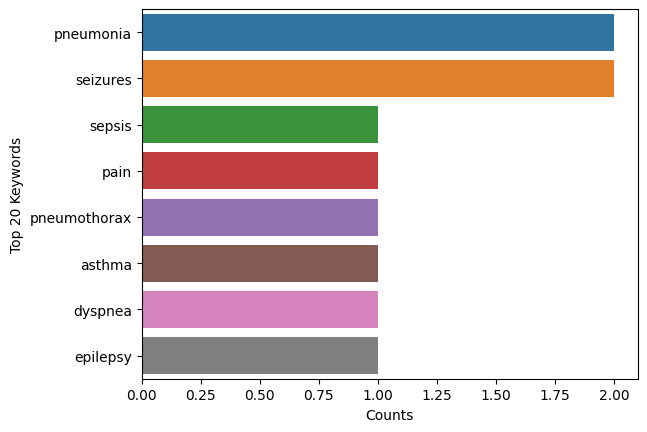

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

ax = sns.barplot(y, x = "counts", y = "keywords")
ax.set(xlabel = 'Counts', ylabel = 'Top 20 Keywords')
plt.show()

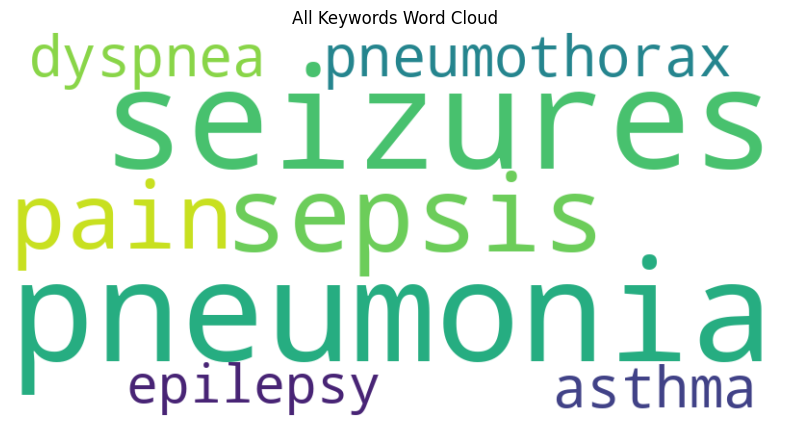

In [ ]:
word_counts = Counter(final_list)

# Create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('All Keywords Word Cloud')
plt.show()

In [ ]:
'''import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Create a sample dataset
data = {'PatientID': range(1, 1001),
        'Keywords': [['heart', 'blood pressure', 'cholesterol', 'diabetes', 'exercise']]*250 +
                    [['headache', 'migraine', 'stress', 'sleep', 'medication']]*250 +
                    [['joint pain', 'arthritis', 'physical therapy', 'inflammation', 'exercise']]*250 +
                    [['asthma', 'lung capacity', 'allergies', 'smoking', 'medication']]*250}

df = pd.DataFrame(data)

# Convert the list of keywords to a string
df['Keywords_str'] = df['Keywords'].apply(lambda x: ' '.join(x))

# TF-IDF vectorization
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['Keywords_str'])

# K-means clustering
num_clusters = 4  # You can adjust this based on your requirements
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['Cluster'] = kmeans.fit_predict(X)

# Reduce dimensionality for visualization (you can adjust the number of components)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

# Add the reduced dimensions to the DataFrame
df['PCA1'] = X_pca[:, 0]
df['PCA2'] = X_pca[:, 1]

# Plot the clusters
plt.figure(figsize=(10, 6))
for cluster in range(num_clusters):
    cluster_data = df[df['Cluster'] == cluster]
    plt.scatter(cluster_data['PCA1'], cluster_data['PCA2'], label=f'Cluster {cluster}')

plt.title('Patient Clusters')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.show()
'''

"import pandas as pd\nfrom sklearn.feature_extraction.text import TfidfVectorizer\nfrom sklearn.cluster import KMeans\nimport matplotlib.pyplot as plt\nfrom sklearn.decomposition import PCA\n\n# Create a sample dataset\ndata = {'PatientID': range(1, 1001),\n        'Keywords': [['heart', 'blood pressure', 'cholesterol', 'diabetes', 'exercise']]*250 +\n                    [['headache', 'migraine', 'stress', 'sleep', 'medication']]*250 +\n                    [['joint pain', 'arthritis', 'physical therapy', 'inflammation', 'exercise']]*250 +\n                    [['asthma', 'lung capacity', 'allergies', 'smoking', 'medication']]*250}\n\ndf = pd.DataFrame(data)\n\n# Convert the list of keywords to a string\ndf['Keywords_str'] = df['Keywords'].apply(lambda x: ' '.join(x))\n\n# TF-IDF vectorization\nvectorizer = TfidfVectorizer()\nX = vectorizer.fit_transform(df['Keywords_str'])\n\n# K-means clustering\nnum_clusters = 4  # You can adjust this based on your requirements\nkmeans = KMeans(n_clu